# Detection of Vote Fraud

In [494]:
import pandas as pd
import matplotlib.pyplot as plt
import math
from scipy.stats import chi2
import scipy.stats as stats


## Theoretical Benford's law

Benford's law states that in many naturally occurring collections of numbers, the leading digit is likely to be small. In sets that obey Benford's law, in the first position, the number 1 appears as the leading significant digit about 30% of the time, while larger digits occur in that position less frequently: 9 as the first digit less than 5% of the time. Here, a function that compute the theoretical Benford's law is implemented. This function can be used for alle digits (0-9) but for the first position the digit 0 is not allowed.

### Functions

In [495]:
def benford_nth_digit_probabilities(n):
    """
    Calculate the probabilities for all digits (0-9) appearing at the n-th position.
    For the first position, this is not applicable to digit 0.
    """
    probabilities = {}
    if n == 1:
        probabilities[0] = 0
        for d in range(1, 10):
            probabilities[d] = math.log10(1 + 1 / d)
    else:
        for d in range(10):
            total_sum = 0
            for k in range(10**(n-2), 10**(n-1)):
                total_sum += math.log10(1 + 1 / (10 * k + d))
            probabilities[d] = total_sum
    return probabilities


Now the function is generalized for other bases of numbers.

In [496]:
import math

def benford_nth_digit_probabilities_gen(base=10, n=1):
    """
    Calculate the probabilities for all digits (0 to base-1) appearing at the n-th position
    in a numeric system of the specified base.
    For the first position, this is not applicable to digit 0.
    """
    probabilities = {}
    
    if n == 1:
        # For the first digit, digit 0 is not allowed.
        probabilities[0] = 0
        for d in range(1, base):
            # Use logarithm in the specified base for the calculation
            probabilities[d] = math.log(1 + 1 / d, base)
    else:
        # For subsequent digits, all digits (0 to base-1) are considered
        for d in range(base):
            total_sum = 0
            # Sum over possible positions for digits
            for k in range(base**(n-2), base**(n-1)):
                total_sum += math.log(1 + 1 / (base * k + d), base)
            probabilities[d] = total_sum
    
    return probabilities



In [497]:
Benford_theory = pd.DataFrame([benford_nth_digit_probabilities(1), benford_nth_digit_probabilities(2), benford_nth_digit_probabilities(3), benford_nth_digit_probabilities(4)])
Benford_theory = Benford_theory.T
Benford_theory.columns = ['First position', 'Second position', 'Third position', 'Fourth position']

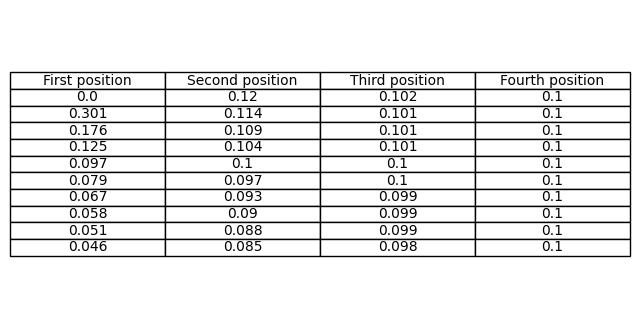

<Figure size 640x480 with 0 Axes>

In [498]:
#only 3 decimal places
Benford_theory = Benford_theory.round(3)

# table to represent the probabilities
fig, ax = plt.subplots(figsize=(8, 4))  
ax.axis('tight')
ax.axis('off')
ax.table(cellText=Benford_theory.values, colLabels=Benford_theory.columns, cellLoc='center', loc='center')

plt.show()
plt.savefig('table_with_sum_probabilities.png', dpi=300, bbox_inches='tight')
#write all the data in a type that can be used in a LaTeX table
Benford_theory.to_latex('table_with_sum_probabilities.tex', float_format="%.3f")


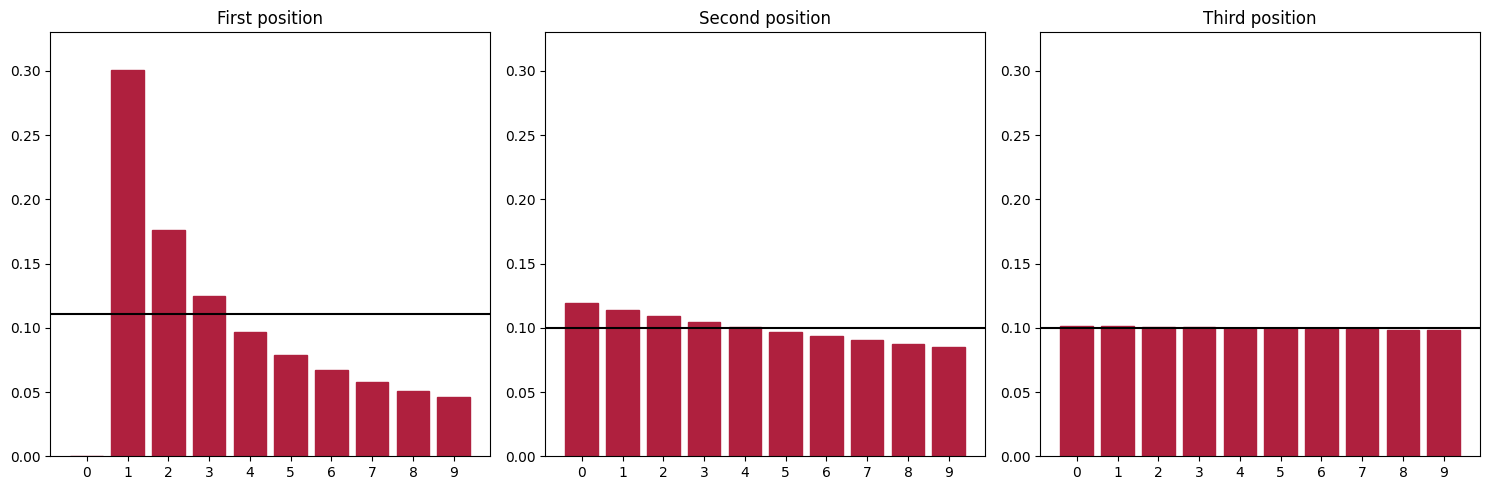

In [499]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for ax in axs:
    ax.set_ylim(0, 0.33)

for ax in axs:
    ax.set_xticks(range(10))

axs[0].bar(benford_nth_digit_probabilities(1).keys(), benford_nth_digit_probabilities(1).values())
axs[0].set_title('First position')
axs[1].bar(benford_nth_digit_probabilities(2).keys(), benford_nth_digit_probabilities(2).values())
axs[1].set_title('Second position')
axs[2].bar(benford_nth_digit_probabilities(3).keys(), benford_nth_digit_probabilities(3).values())
axs[2].set_title('Third position')

#use the color #af203e in HEX for the bars
for ax in axs:
    for bar in ax.patches:
        bar.set_color('#af203e')

for ax in axs:
    if ax.get_title() == 'First position':
        ax.axhline(y=1/9, color='black')
    else:
        ax.axhline(y=1/10, color='black')

plt.tight_layout()
plt.show()

In [500]:
def Benford_theory_firsttwo_digits():
    """
    Calculate the probabilities for the first two digits (10-99) with Benford's law that is 1/log(1+1/d) where d is the digit.
    """
    probabilities = {}
    for d in range(10, 100):
        probabilities[d] = math.log10(1 + 1 / d)
    return probabilities


Text(0.5, 1.0, 'First two digits')

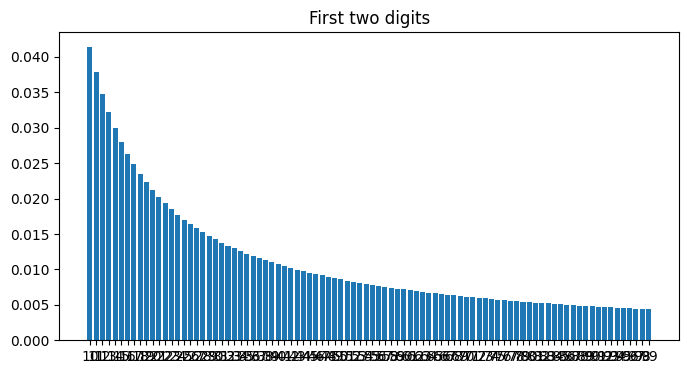

In [501]:
#plot Benford_theory_firsttwo_digits
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_xticks(range(10, 100))
ax.bar(Benford_theory_firsttwo_digits().keys(), Benford_theory_firsttwo_digits().values())
ax.set_title('First two digits')


#### Application of the Benford's law to the data

In this notebook, a function that computes the probability of the different digits is implemented. The function also take as input the position that the user want to compute the probability. Take care that for the numbers with decimal values, the point is removed. The results are also calcolate for the digits from 0 to 9 but the digit 0 is not allowed in the first position so is 0 everytimes.

In [502]:
def data_digit_probabilities(data, position):
    """
    Calculate the probabilities for the digit (0-9) at a given position according to Benford's Law for a list of numbers.
    Returns a dictionary with digits as keys and their probabilities as values.
    
    Parameters:
        data (list): A list of numerical data (int or float).
        position (int): The position of the digit to analyze (1 for the first digit, 2 for the second, etc.).
    
    Returns:
        probabilities (dict): A dictionary with digit keys (0-9) and their probabilities as values.
    """
    probabilities = {}
    for n in range(0, 10):
        probabilities[n] = 0
    total_count = 0
    
    for number in data:
        str_number = str(abs(number)).replace('.', '')

        if len(str_number) >= position:
            digit = int(str_number[position - 1])
            probabilities[digit] += 1
            total_count += 1
    
    # Compute the probabilities instead of counts
    if total_count > 0:
        for n in range(0, 10):
            probabilities[n] /= total_count
    
    return probabilities


In [503]:
def data_digit_probabilities_gen(data, base=10, position=1):
    """
    Calculate the probabilities for the digit (0 to base-1) at a given position according to Benford's Law for a list of numbers.
    Returns a dictionary with digits as keys and their probabilities as values.
    
    Parameters:
        data (list): A list of numerical data (int or float).
        base (int): The base of the numeric system (e.g., 10 for decimal, 16 for hexadecimal).
        position (int): The position of the digit to analyze (1 for the first digit, 2 for the second, etc.).
    
    Returns:
        probabilities (dict): A dictionary with digit keys (0 to base-1) and their probabilities as values.
    """
    probabilities = {n: 0 for n in range(0, base)}
    total_count = 0

    for number in data:
        str_number = str(abs(number)).replace('.', '')

        if len(str_number) >= position:
            digit = int(str_number[position - 1], base=10)  # Assumes input data is in base 10
            if digit < base:
                probabilities[digit] += 1
                total_count += 1
    
    # Compute the probabilities instead of counts
    if total_count > 0:
        for n in range(0, base):
            probabilities[n] /= total_count
    
    return probabilities


In [504]:
def data_digit_probabilities_firsttwo(data):
    """
    Calculate the probabilities for the first two digits (10-99) according to Benford's Law for a list of numbers.
    Returns a dictionary with two-digit numbers as keys and their probabilities as values.

    Parameters:
        data (list): A list of numerical data (int or float).

    Returns:
        probabilities (dict): A dictionary with two-digit number keys (10-99) and their probabilities as values.
    """

    probabilities = {}
    for n in range(10, 100):
        probabilities[n] = 0
    total_count = 0

    for number in data:
        str_number = str(abs(number)).replace('.', '')

        if len(str_number) >= 2:
            two_digits = int(str_number[:2])
            if two_digits >= 10:
                probabilities[two_digits] += 1
                total_count += 1

    # Compute the probabilities instead of counts
    if total_count > 0:
        for n in range(10, 100):
            probabilities[n] /= total_count

    return probabilities
    

In [505]:
#use the function above and test it with numbers from 1 to 1000
numbers = list(range(1, 1001))
first_digit_probabilities_for_numbers = data_digit_probabilities(numbers, 2)
first_digit_probabilities_for_numbers


{0: 0.10090817356205853,
 1: 0.09989909182643794,
 2: 0.09989909182643794,
 3: 0.09989909182643794,
 4: 0.09989909182643794,
 5: 0.09989909182643794,
 6: 0.09989909182643794,
 7: 0.09989909182643794,
 8: 0.09989909182643794,
 9: 0.09989909182643794}

#### Some statistical tests

A simple function to calculate deviations from Benford's law is here implemented. The deviation is calculated as the difference between the observed frequency and the formula of Benford's law. Delta that results is simply the maximum difference, in percent, between the probbilities of the first significant digit of the given distribution and the Benford's law. Thus, for example, delta=0 means that the distribution is perfectly following Benford's law, delta equal to 15.09 indicates that the probability of some digit d {1,2,3,4,5,6,7,8,9} differs from log10(1+1/d) by 15.09%.

In [506]:
def benford_deviation(observed_probabilities):
    """
    Calculates the deviation from Benford's Law.

    Args:
        observed_probabilities: Dictionary with keys 0 to 9 representing the observed probabilities for each first digit.

    Returns:
        The maximum deviation from Benford's Law, ignoring the key 0 as it does not apply to Benford's Law.
    """
    deviations = []
    for d in range(1, 10):  # Benford's Law applies to digits 1 through 9
        theoretical_probability = math.log10(1 + 1 / d)
        deviation = abs(observed_probabilities[d] - theoretical_probability) * 100
        deviations.append(deviation)

    return max(deviations)


##### Z-statistic

We use a Z-statistic woith two-tailed test. This because deviations cam occur in both directions. One tailed-test is used for specific deviations in one direction

In [507]:
def calculate_z_statistic(DP, BP, N, alpha_values=[0.001, 0.01, 0.05]):
    """
    Calculates and prints Z-statistics and related significance tests for given actual and expected proportions.
    Returns only the Z-values.

    Parameters:
    - DP: List of actual proportions
    - BP: List of expected proportions
    - N: Sample size
    - alpha_values: List of significance levels (default: [0.001, 0.01, 0.05])

    Returns:
    - A dictionary containing the Z-statistics for each digit.
    """
    z_values = {}

    print(f"N: {N}")
    print("Z-Statistics and Hypothesis Tests\n")

    # Calculate Z-statistics and p-values for each digit
    for idx, (dp, bp) in enumerate(zip(DP, BP), start=1):
        # Compute |DP - BP| and continuity correction
        absolute_difference = abs(dp - bp)
        continuity_correction = 1 / (2 * N)
        numerator = absolute_difference - continuity_correction if continuity_correction < absolute_difference else absolute_difference
        denominator = math.sqrt(bp * (1 - bp) / N)

        # Calculate Z-statistic
        Z = numerator / denominator
        p_value = 2 * (1 - stats.norm.cdf(abs(Z)))  # Two-tailed p-value

        print(f"Digit {idx}:")
        print(f"  Actual proportion (DP): {dp:.4f}")
        print(f"  Expected proportion (BP): {bp:.4f}")
        print(f"  Z-statistic: {Z:.4f}")
        print(f"  p-value: {p_value:.4f}")

        # Evaluate significance for each alpha level
        for alpha in alpha_values:
            critical_z = stats.norm.ppf(1 - alpha / 2)
            print(f"  Critical value at alpha={alpha*100:.1f}%: {critical_z:.4f}")
            if abs(Z) > critical_z:
                print(f"  Reject null hypothesis at alpha={alpha*100:.1f}%")
            else:
                print(f"  Fail to reject null hypothesis at alpha={alpha*100:.1f}%")

        print("=" * 60)

        # Store Z-statistic for the digit
        z_values[f"Digit_{idx}"] = Z

    # Return only the Z-values dictionary for later use
    return z_values

##### MAD

In [508]:
def calculate_mad(DP, BP, K):
    """
    Calculates the Mean Absolute Deviation (MAD) from Benford's Law.

    Parameters:
    - DP: List of actual proportions
    - BP: List of expected proportions
    - K: Number of digits

    Returns:
    - The Mean Absolute Deviation (MAD) from Benford's Law.
    """
    print("Number of digits (K):", K)
    mad = sum(abs(dp - bp) for dp, bp in zip(DP, BP)) / K
    return mad

##### Chi-squared test

In [509]:
def calculate_chi_square(DP, BP, N):
    """
    Calculates the Chi-Square statistic, compares it to critical values at multiple alpha levels, 
    and tells whether to reject or fail to reject the null hypothesis at each level.

    Parameters:
    - DP: List of actual proportions
    - BP: List of expected proportions
    - N: Sample size

    Returns:
    - Dictionary containing Chi-Square statistic, degrees of freedom, p-value, critical values, and hypothesis test results.
    """
    # Calculate observed and expected frequencies
    DP_frequencies = [dp * N for dp in DP]
    BP_frequencies = [bp * N for bp in BP]
    
    # Compute Chi-Square statistic
    chi_square = sum((df - bf)**2 / bf for df, bf in zip(DP_frequencies, BP_frequencies))
    df = len(DP) - 1  # Degrees of freedom
    
    # Alpha levels and corresponding critical values
    alpha_levels = [0.001, 0.01, 0.05]
    critical_values = {alpha: chi2.ppf(1 - alpha, df) for alpha in alpha_levels}
    
    # Compute p-value
    p_value = 1 - chi2.cdf(chi_square, df)  # Uncorrected p-value
    
    # Output results
    print(f"N: {N}")
    print(f"Chi-Square statistic: {chi_square:.4f}")
    
    # Check for each alpha level if we reject or fail to reject the null hypothesis
    results = {}
    for alpha, critical_value in critical_values.items():
        print(f"Critical value (alpha={alpha*100}%): {critical_value:.4f}")
        if chi_square > critical_value:
            decision = "Reject the null hypothesis"
        else:
            decision = "Fail to reject the null hypothesis"
        
        # Store results for each alpha level
        results[alpha] = {
            "chi_square": chi_square,
            "critical_value": critical_value,
            "p_value": p_value,
            "decision": decision
        }
        print(f"Chi-Square statistic > Critical value: {decision}")
    
    return results


In [510]:
def apply_corrections(chi_square_result, num_tests=1):
    """
    Applies Bonferroni and Benjamini-Hochberg corrections and evaluates significance.

    Parameters:
    - chi_square_result: Output from `calculate_chi_square` containing test statistics.
    - num_tests: Number of tests (for Bonferroni correction).

    Returns:
    - None. Prints corrected p-values and hypothesis testing results.
    """
    # Extract information from chi_square_result
    chi_square = chi_square_result["chi_square"]
    df = chi_square_result["df"]
    p_value = chi_square_result["p_value"]
    N = chi_square_result["N"]

    # Calculate corrected p-values
    bonferroni_p_value = min(p_value * num_tests, 1)
    bh_p_value = p_value  # For single test, BH correction is the same

    # Print corrected p-values
    print(f"Bonferroni corrected p-value: {bonferroni_p_value:.4f}")
    print(f"Benjamini-Hochberg corrected p-value: {bh_p_value:.4f}")

    # Test significance at different alpha levels
    alpha_levels = [0.001, 0.01, 0.05]
    for alpha in alpha_levels:
        # Uncorrected critical value
        critical_value = chi2.ppf(1 - alpha, df)
        print(f"\nCritical value at alpha={alpha*100}%: {critical_value:.4f}")
        if chi_square > critical_value:
            print(f"Reject null hypothesis at alpha={alpha*100}% (uncorrected)")
        else:
            print(f"Fail to reject null hypothesis at alpha={alpha*100}% (uncorrected)")
        
        # Bonferroni corrected critical value
        corrected_alpha = alpha / num_tests
        critical_value_corrected = chi2.ppf(1 - corrected_alpha, df)
        print(f"Critical value with Bonferroni correction at alpha={alpha*100}%: {critical_value_corrected:.4f}")
        if chi_square > critical_value_corrected:
            print(f"Reject null hypothesis at alpha={alpha*100}% (Bonferroni corrected)")
        else:
            print(f"Fail to reject null hypothesis at alpha={alpha*100}% (Bonferroni corrected)")

##### Mean of the significant digits


In [511]:
def calculate_fsd_mean(probabilities, start_digit=1, num_digits=9):
    """
    Calculate the mean of the first significant digit (FSD) for a dataset.

    Parameters:
    - probabilities (list): A list of probabilities (p_j) for each digit d_j (from `start_digit` to `start_digit + num_digits - 1`).
    - start_digit (int): The starting digit (default is 1).
    - num_digits (int): The total number of digits (default is 9).

    Returns:
    - float: The mean FSD value.
    """
    if len(probabilities) != num_digits:
        raise ValueError(f"The input probabilities list must contain {num_digits} values corresponding to digits from {start_digit} to {start_digit + num_digits - 1}.")

    # Compute the weighted mean of the first significant digit
    mean_fsd = sum(d * p for d, p in zip(range(start_digit, start_digit + num_digits), probabilities))
    return mean_fsd


##### Kolmogorov-Smirnov test
Kolmogorov-Smirnov test is a non-parametric test that compares the cumulative distribution of the data with the cumulative distribution of the theoretical distribution. The test statistic is the maximum absolute difference between the two cumulative distributions. The null hypothesis is that the two distributions are the same. The test is applied to the significant digits of the data.

The largest difference of the absolute values of these digits is also called supremum distance.

In [512]:
def calculate_ks_statistic(DP, BP, n):
    """
    Calculates the Kolmogorov-Smirnov (KS) statistic and compares it with the critical values 
    for various significance levels (alpha).

    Parameters:
    - DP: List of actual proportions
    - BP: List of expected proportions
    - n: Sample size

    Returns:
    - KS statistic value and results for critical value comparison.
    """
    # Calculate cumulative distributions
    DP_cumulative = [sum(DP[:i+1]) for i in range(len(DP))]
    BP_cumulative = [sum(BP[:i+1]) for i in range(len(BP))]
    
    # Calculate the KS statistic
    ks_values = [abs(dp - bp) for dp, bp in zip(DP_cumulative, BP_cumulative)]
    ks_statistic = max(ks_values)

    # Define critical values for the three alpha levels
    critical_values = {
        0.001: 1.95 / math.sqrt(n),
        0.01: 1.63 / math.sqrt(n),
        0.05: 1.36 / math.sqrt(n)
    }

    # Compare KS statistic with critical values
    results = {}
    for alpha, critical_value in critical_values.items():
        if ks_statistic > critical_value:
            results[alpha] = f"Reject null hypothesis (KS={ks_statistic:.4f} > Critical={critical_value:.4f})"
        else:
            results[alpha] = f"Fail to reject null hypothesis (KS={ks_statistic:.4f} <= Critical={critical_value:.4f})"

    # Output KS statistic and comparison results
    print(f"KS statistic: {ks_statistic:.4f}")
    for alpha, result in results.items():
        print(f"Alpha={alpha:.3f}: {result}")

    return ks_statistic, results

## Application of the function

### Uniform distribution


In [513]:
#create a unuform distribution with the proportion 9 proportion of 0.1111111111111111 for 
#the first digit and 0.1 for the other digits
#the first is called uniform_first_digit and the second uniform_other_digits
uniform_first_digit = [0.1111111111111111] * 9
uniform_other_digits = [0.1] * 10
def uniform_10_99():
    probability = 1 / 90  # Equal probability for each number
    return [probability] * 90
uniform_10_99 = uniform_10_99()


In [514]:
print(uniform_10_99)
sum(uniform_10_99)  

[0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.011111111111111112, 0.0111111

0.9999999999999984

#### Statistical tests

##### Z-statistic

In [515]:
uniform_first_digit

[0.1111111111111111,
 0.1111111111111111,
 0.1111111111111111,
 0.1111111111111111,
 0.1111111111111111,
 0.1111111111111111,
 0.1111111111111111,
 0.1111111111111111,
 0.1111111111111111]

In [516]:
#apply the z statistic to the uniform_first_digit and uniform_other_digits
#the sample size is 1000
N = 100
z_values_first_digit = calculate_z_statistic(uniform_first_digit, list(benford_nth_digit_probabilities(1).values())[1:], N)
z_values_first_digit

N: 100
Z-Statistics and Hypothesis Tests

Digit 1:
  Actual proportion (DP): 0.1111
  Expected proportion (BP): 0.3010
  Z-statistic: 4.0313
  p-value: 0.0001
  Critical value at alpha=0.1%: 3.2905
  Reject null hypothesis at alpha=0.1%
  Critical value at alpha=1.0%: 2.5758
  Reject null hypothesis at alpha=1.0%
  Critical value at alpha=5.0%: 1.9600
  Reject null hypothesis at alpha=5.0%
Digit 2:
  Actual proportion (DP): 0.1111
  Expected proportion (BP): 0.1761
  Z-statistic: 1.5747
  p-value: 0.1153
  Critical value at alpha=0.1%: 3.2905
  Fail to reject null hypothesis at alpha=0.1%
  Critical value at alpha=1.0%: 2.5758
  Fail to reject null hypothesis at alpha=1.0%
  Critical value at alpha=5.0%: 1.9600
  Fail to reject null hypothesis at alpha=5.0%
Digit 3:
  Actual proportion (DP): 0.1111
  Expected proportion (BP): 0.1249
  Z-statistic: 0.2670
  p-value: 0.7895
  Critical value at alpha=0.1%: 3.2905
  Fail to reject null hypothesis at alpha=0.1%
  Critical value at alpha=1.0

{'Digit_1': 4.031318480935619,
 'Digit_2': 1.5747045346339776,
 'Digit_3': 0.26697839371058524,
 'Digit_4': 0.31102107760695025,
 'Digit_5': 0.9973232267925218,
 'Digit_6': 1.5670127251561699,
 'Digit_7': 2.0587656906872374,
 'Digit_8': 2.494616786975264,
 'Digit_9': 2.8883036489955485}

In [517]:
#apply the z statistic to the uniform_other_digits and benford second digit
#the sample size is 1000
z_values_other_digits = calculate_z_statistic(uniform_other_digits, list(benford_nth_digit_probabilities(2).values()), N)
z_values_other_digits


N: 100
Z-Statistics and Hypothesis Tests

Digit 1:
  Actual proportion (DP): 0.1000
  Expected proportion (BP): 0.1197
  Z-statistic: 0.4522
  p-value: 0.6511
  Critical value at alpha=0.1%: 3.2905
  Fail to reject null hypothesis at alpha=0.1%
  Critical value at alpha=1.0%: 2.5758
  Fail to reject null hypothesis at alpha=1.0%
  Critical value at alpha=5.0%: 1.9600
  Fail to reject null hypothesis at alpha=5.0%
Digit 2:
  Actual proportion (DP): 0.1000
  Expected proportion (BP): 0.1139
  Z-statistic: 0.2798
  p-value: 0.7796
  Critical value at alpha=0.1%: 3.2905
  Fail to reject null hypothesis at alpha=0.1%
  Critical value at alpha=1.0%: 2.5758
  Fail to reject null hypothesis at alpha=1.0%
  Critical value at alpha=5.0%: 1.9600
  Fail to reject null hypothesis at alpha=5.0%
Digit 3:
  Actual proportion (DP): 0.1000
  Expected proportion (BP): 0.1088
  Z-statistic: 0.1227
  p-value: 0.9023
  Critical value at alpha=0.1%: 3.2905
  Fail to reject null hypothesis at alpha=0.1%
  Cri

{'Digit_1': 0.4522457447165669,
 'Digit_2': 0.27984659397213985,
 'Digit_3': 0.12271398185855725,
 'Digit_4': 0.14163349651820872,
 'Digit_5': 0.01025937077619807,
 'Digit_6': 0.1124387302799609,
 'Digit_7': 0.05585928497501205,
 'Digit_8': 0.16212932535216573,
 'Digit_9': 0.26285007723659826,
 'Digit_10': 0.35867500240124117}

In [518]:
#apply z statistic to the uniform_10_99 and Benford_theory_firsttwo_digits
#the sample size is 1000
z_values_10_99 = calculate_z_statistic(uniform_10_99, list(Benford_theory_firsttwo_digits().values()), N)
z_values_10_99
len(z_values_10_99)

N: 100
Z-Statistics and Hypothesis Tests

Digit 1:
  Actual proportion (DP): 0.0111
  Expected proportion (BP): 0.0414
  Z-statistic: 1.2692
  p-value: 0.2044
  Critical value at alpha=0.1%: 3.2905
  Fail to reject null hypothesis at alpha=0.1%
  Critical value at alpha=1.0%: 2.5758
  Fail to reject null hypothesis at alpha=1.0%
  Critical value at alpha=5.0%: 1.9600
  Fail to reject null hypothesis at alpha=5.0%
Digit 2:
  Actual proportion (DP): 0.0111
  Expected proportion (BP): 0.0378
  Z-statistic: 1.1368
  p-value: 0.2556
  Critical value at alpha=0.1%: 3.2905
  Fail to reject null hypothesis at alpha=0.1%
  Critical value at alpha=1.0%: 2.5758
  Fail to reject null hypothesis at alpha=1.0%
  Critical value at alpha=5.0%: 1.9600
  Fail to reject null hypothesis at alpha=5.0%
Digit 3:
  Actual proportion (DP): 0.0111
  Expected proportion (BP): 0.0348
  Z-statistic: 1.0182
  p-value: 0.3086
  Critical value at alpha=0.1%: 3.2905
  Fail to reject null hypothesis at alpha=0.1%
  Cri

90

##### MAD

Comparison between uniform first significant digit and Benford's law first significant digit

In [519]:
BP=list(benford_nth_digit_probabilities(1).values())[1:]
AP=list(uniform_first_digit)
K=len(BP)
mad = calculate_mad(AP, BP, K)
print(f"Mean Absolute Deviation (MAD) from Benford's Law: {mad}")

Number of digits (K): 9
Mean Absolute Deviation (MAD) from Benford's Law: 0.05971703510991756


Comparison between uniform second significant digit and Benford's law second significant digit

In [520]:
BP=list(benford_nth_digit_probabilities(2).values())
AP=list(uniform_other_digits)
K=len(BP)
mad = calculate_mad(AP, BP, K)
print(f"Mean Absolute Deviation (MAD) from Benford's Law: {mad}")

Number of digits (K): 10
Mean Absolute Deviation (MAD) from Benford's Law: 0.009405726701696863


Comparison between uniform first two significant digits and Benford's law first two significant digits

In [521]:
BP=list(Benford_theory_firsttwo_digits().values())
AP=list(uniform_10_99)
K=len(BP)
mad = calculate_mad(AP, BP, K)
print(f"Mean Absolute Deviation (MAD) from Benford's Law: {mad}")

Number of digits (K): 90
Mean Absolute Deviation (MAD) from Benford's Law: 0.005974275217872824


##### Chi-square test

In [522]:
uniform_first_digit

[0.1111111111111111,
 0.1111111111111111,
 0.1111111111111111,
 0.1111111111111111,
 0.1111111111111111,
 0.1111111111111111,
 0.1111111111111111,
 0.1111111111111111,
 0.1111111111111111]

In [523]:
#apply the chi square to the uniform_first_digit
n=1000
calculate_chi_square(uniform_first_digit, list(benford_nth_digit_probabilities(1).values())[1:], n)

N: 1000
Chi-Square statistic: 401.6983
Critical value (alpha=0.1%): 26.1245
Chi-Square statistic > Critical value: Reject the null hypothesis
Critical value (alpha=1.0%): 20.0902
Chi-Square statistic > Critical value: Reject the null hypothesis
Critical value (alpha=5.0%): 15.5073
Chi-Square statistic > Critical value: Reject the null hypothesis


{0.001: {'chi_square': 401.69829291218,
  'critical_value': 26.12448155837614,
  'p_value': 0.0,
  'decision': 'Reject the null hypothesis'},
 0.01: {'chi_square': 401.69829291218,
  'critical_value': 20.090235029663233,
  'p_value': 0.0,
  'decision': 'Reject the null hypothesis'},
 0.05: {'chi_square': 401.69829291218,
  'critical_value': 15.507313055865453,
  'p_value': 0.0,
  'decision': 'Reject the null hypothesis'}}

In [524]:
#apply the chi square to the uniform_other_digits
calculate_chi_square(uniform_other_digits, list(benford_nth_digit_probabilities(2).values()),n)

N: 1000
Chi-Square statistic: 11.8526
Critical value (alpha=0.1%): 27.8772
Chi-Square statistic > Critical value: Fail to reject the null hypothesis
Critical value (alpha=1.0%): 21.6660
Chi-Square statistic > Critical value: Fail to reject the null hypothesis
Critical value (alpha=5.0%): 16.9190
Chi-Square statistic > Critical value: Fail to reject the null hypothesis


{0.001: {'chi_square': 11.852643482822135,
  'critical_value': 27.877164871256568,
  'p_value': 0.22174463687645463,
  'decision': 'Fail to reject the null hypothesis'},
 0.01: {'chi_square': 11.852643482822135,
  'critical_value': 21.665994333461924,
  'p_value': 0.22174463687645463,
  'decision': 'Fail to reject the null hypothesis'},
 0.05: {'chi_square': 11.852643482822135,
  'critical_value': 16.918977604620448,
  'p_value': 0.22174463687645463,
  'decision': 'Fail to reject the null hypothesis'}}

In [525]:
#apply the chi square to the uniform_10_99
calculate_chi_square(uniform_10_99, list(Benford_theory_firsttwo_digits().values()),n)

N: 1000
Chi-Square statistic: 407.0808
Critical value (alpha=0.1%): 135.9776
Chi-Square statistic > Critical value: Reject the null hypothesis
Critical value (alpha=1.0%): 122.9422
Chi-Square statistic > Critical value: Reject the null hypothesis
Critical value (alpha=5.0%): 112.0220
Chi-Square statistic > Critical value: Reject the null hypothesis


{0.001: {'chi_square': 407.0807902822811,
  'critical_value': 135.97756707124026,
  'p_value': 0.0,
  'decision': 'Reject the null hypothesis'},
 0.01: {'chi_square': 407.0807902822811,
  'critical_value': 122.9422067982886,
  'p_value': 0.0,
  'decision': 'Reject the null hypothesis'},
 0.05: {'chi_square': 407.0807902822811,
  'critical_value': 112.02198574980785,
  'p_value': 0.0,
  'decision': 'Reject the null hypothesis'}}

##### FSD mean

Benford reference mean

In [526]:
print("Benford's Law FSD Mean:", calculate_fsd_mean(list(benford_nth_digit_probabilities(1).values())[1:], start_digit=1, num_digits=9), " | Uniform FSD Mean:", calculate_fsd_mean(uniform_first_digit, start_digit=1, num_digits=9))

Benford's Law FSD Mean: 3.440236967123206  | Uniform FSD Mean: 5.0


In [527]:
print("Benford's Law FSD Mean:", calculate_fsd_mean(list(benford_nth_digit_probabilities(2).values()), start_digit=0, num_digits=10), " | Uniform FSD Mean:", calculate_fsd_mean(uniform_other_digits, start_digit=0, num_digits=10))

Benford's Law FSD Mean: 4.1873897069289425  | Uniform FSD Mean: 4.500000000000001


In [528]:
print("Benford's Law FSD Mean:", calculate_fsd_mean(list(Benford_theory_firsttwo_digits().values()), start_digit=10, num_digits=90), " | Uniform FSD Mean:", calculate_fsd_mean(uniform_10_99, start_digit=10, num_digits=90))


Benford's Law FSD Mean: 38.589759378161006  | Uniform FSD Mean: 54.5


##### Kolmogorov-Smirnov test

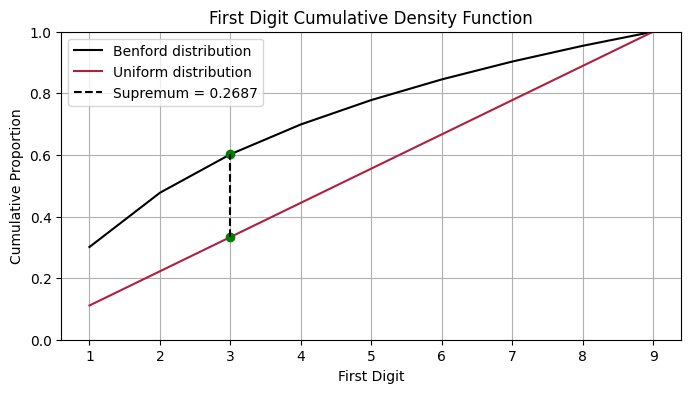

In [529]:
# Calculate cumulative proportions for Benford's law and Uniform distribution
benford_digits = list(benford_nth_digit_probabilities(1).keys())[1:]  # Exclude digit 0
benford_probs = list(benford_nth_digit_probabilities(1).values())[1:]  # Exclude probability for digit 0
benford_cumulative = [sum(benford_probs[:i+1]) for i in range(len(benford_probs))]

# Uniform probabilities: 1/9 for each digit from 1 to 9
uni_digits = benford_digits  # Ensure the digits align with Benford's digits
uni_probs = [1 / 9] * len(uni_digits)  # Uniform probabilities (exact 11.11%)
uni_cumulative = [sum(uni_probs[:i+1]) for i in range(len(uni_probs))]

# Calculate the supremum (maximum difference) and find the corresponding x value
differences = [abs(b - u) for b, u in zip(benford_cumulative, uni_cumulative)]
supremum = max(differences)
supremum_index = differences.index(supremum)
supremum_x = benford_digits[supremum_index]
supremum_y_benford = benford_cumulative[supremum_index]
supremum_y_uni = uni_cumulative[supremum_index]

# Plot cumulative density functions
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(benford_digits, benford_cumulative, 'black', label='Benford distribution')
ax.plot(uni_digits, uni_cumulative, color="#af203e", label='Uniform distribution')

# Highlight the supremum point
ax.plot([supremum_x], [supremum_y_benford], 'go')  # Point on Benford curve
ax.plot([supremum_x], [supremum_y_uni], 'go')  # Point on Uniform curve
ax.vlines(supremum_x, supremum_y_uni, supremum_y_benford, colors='k', linestyle='--', label=f'Supremum = {supremum:.4f}')

ax.set_xticks(range(1, 10))

# Add title, labels, and legend
ax.set_title('First Digit Cumulative Density Function')
ax.set_xlabel('First Digit')
ax.set_ylabel('Cumulative Proportion')
ax.set_ylim(0, 1)  # Ensure the y-axis starts at 0 and ends at 1
ax.legend()
ax.grid(True)
plt.show()


In [530]:
#calculate the ks statistic for the uniform_first_digit
calculate_ks_statistic(uniform_first_digit, list(benford_nth_digit_probabilities(1).values())[1:],n)




KS statistic: 0.2687
Alpha=0.001: Reject null hypothesis (KS=0.2687 > Critical=0.0617)
Alpha=0.010: Reject null hypothesis (KS=0.2687 > Critical=0.0515)
Alpha=0.050: Reject null hypothesis (KS=0.2687 > Critical=0.0430)


(0.2687266579946291,
 {0.001: 'Reject null hypothesis (KS=0.2687 > Critical=0.0617)',
  0.01: 'Reject null hypothesis (KS=0.2687 > Critical=0.0515)',
  0.05: 'Reject null hypothesis (KS=0.2687 > Critical=0.0430)'})

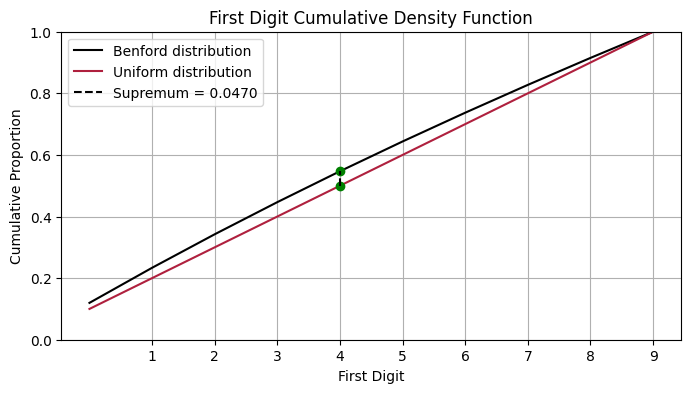

In [531]:
# Calculate cumulative proportions for Benford's law and Uniform distribution
benford_digits = list(benford_nth_digit_probabilities(2).keys())
benford_probs = list(benford_nth_digit_probabilities(2).values())
benford_cumulative = [sum(benford_probs[:i+1]) for i in range(len(benford_probs))]

# Uniform probabilities: 1/9 for each digit from 1 to 9
uni_digits = benford_digits  # Ensure the digits align with Benford's digits
uni_probs = [1 / 10] * len(uni_digits)  # Uniform probabilities (exact 11.11%)
uni_cumulative = [sum(uni_probs[:i+1]) for i in range(len(uni_probs))]

# Calculate the supremum (maximum difference) and find the corresponding x value
differences = [abs(b - u) for b, u in zip(benford_cumulative, uni_cumulative)]
supremum = max(differences)
supremum_index = differences.index(supremum)
supremum_x = benford_digits[supremum_index]
supremum_y_benford = benford_cumulative[supremum_index]
supremum_y_uni = uni_cumulative[supremum_index]

# Plot cumulative density functions
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(benford_digits, benford_cumulative, 'black', label='Benford distribution')
ax.plot(uni_digits, uni_cumulative, color="#af203e", label='Uniform distribution')

# Highlight the supremum point
ax.plot([supremum_x], [supremum_y_benford], 'go')  # Point on Benford curve
ax.plot([supremum_x], [supremum_y_uni], 'go')  # Point on Uniform curve
ax.vlines(supremum_x, supremum_y_uni, supremum_y_benford, colors='k', linestyle='--', label=f'Supremum = {supremum:.4f}')

ax.set_xticks(range(1, 10))

# Add title, labels, and legend
ax.set_title('First Digit Cumulative Density Function')
ax.set_xlabel('First Digit')
ax.set_ylabel('Cumulative Proportion')
ax.set_ylim(0, 1)  # Ensure the y-axis starts at 0 and ends at 1
ax.legend()
ax.grid(True)
plt.show()

    

In [532]:
#apply the ks test to the uniform_other_digits
calculate_ks_statistic(uniform_other_digits, list(benford_nth_digit_probabilities(2).values()),n)

KS statistic: 0.0470
Alpha=0.001: Fail to reject null hypothesis (KS=0.0470 <= Critical=0.0617)
Alpha=0.010: Fail to reject null hypothesis (KS=0.0470 <= Critical=0.0515)
Alpha=0.050: Reject null hypothesis (KS=0.0470 > Critical=0.0430)


(0.047028633508484186,
 {0.001: 'Fail to reject null hypothesis (KS=0.0470 <= Critical=0.0617)',
  0.01: 'Fail to reject null hypothesis (KS=0.0470 <= Critical=0.0515)',
  0.05: 'Reject null hypothesis (KS=0.0470 > Critical=0.0430)'})

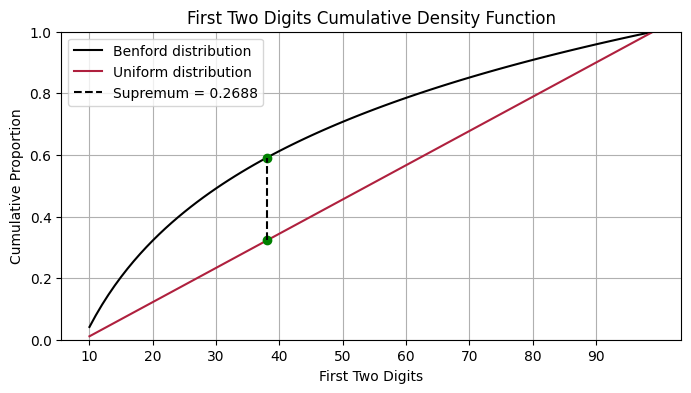

In [533]:
# Calculate cumulative proportions for Benford's law and Uniform distribution for first two digits
benford_digits = list(Benford_theory_firsttwo_digits().keys())
benford_probs = list(Benford_theory_firsttwo_digits().values())
benford_cumulative = [sum(benford_probs[:i+1]) for i in range(len(benford_probs))]

# Uniform probabilities: same for all two-digit numbers from 10 to 99
uni_digits = benford_digits  # Ensure the digits align with Benford's digits
uni_probs=uniform_10_99
uni_cumulative = [sum(uni_probs[:i+1]) for i in range(len(uni_probs))]

# Calculate the supremum (maximum difference) and find the corresponding x value
differences = [abs(b - u) for b, u in zip(benford_cumulative, uni_cumulative)]
supremum = max(differences)
supremum_index = differences.index(supremum)
supremum_x = benford_digits[supremum_index]
supremum_y_benford = benford_cumulative[supremum_index]
supremum_y_uni = uni_cumulative[supremum_index]

# Plot cumulative density functions
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(benford_digits, benford_cumulative, 'black', label='Benford distribution')
ax.plot(uni_digits, uni_cumulative, color="#af203e", label='Uniform distribution')

# Highlight the supremum point
ax.plot([supremum_x], [supremum_y_benford], 'go')  # Point on Benford curve
ax.plot([supremum_x], [supremum_y_uni], 'go')  # Point on Uniform curve

ax.vlines(supremum_x, supremum_y_uni, supremum_y_benford, colors='k', linestyle='--', label=f'Supremum = {supremum:.4f}')

ax.set_xticks(range(10, 100,10))

# Add title, labels, and legend
ax.set_title('First Two Digits Cumulative Density Function')
ax.set_xlabel('First Two Digits')
ax.set_ylabel('Cumulative Proportion')
ax.set_ylim(0, 1)  # Ensure the y-axis starts at 0 and ends at 1
ax.legend()
ax.grid(True)
plt.show()


In [534]:
#apply the ks test to the uniform_10_90
calculate_ks_statistic(uniform_10_99, list(Benford_theory_firsttwo_digits().values()),n)

KS statistic: 0.2688
Alpha=0.001: Reject null hypothesis (KS=0.2688 > Critical=0.0617)
Alpha=0.010: Reject null hypothesis (KS=0.2688 > Critical=0.0515)
Alpha=0.050: Reject null hypothesis (KS=0.2688 > Critical=0.0430)


(0.2688423848042769,
 {0.001: 'Reject null hypothesis (KS=0.2688 > Critical=0.0617)',
  0.01: 'Reject null hypothesis (KS=0.2688 > Critical=0.0515)',
  0.05: 'Reject null hypothesis (KS=0.2688 > Critical=0.0430)'})

### Fibonacci sequence

In [535]:
def fibonacci(n):
    a, b = 1, 1
    for _ in range(n):
        yield a
        a, b = b, a + b


In [536]:
fib = list(fibonacci(10000))
fcount=data_digit_probabilities(fib, 1)

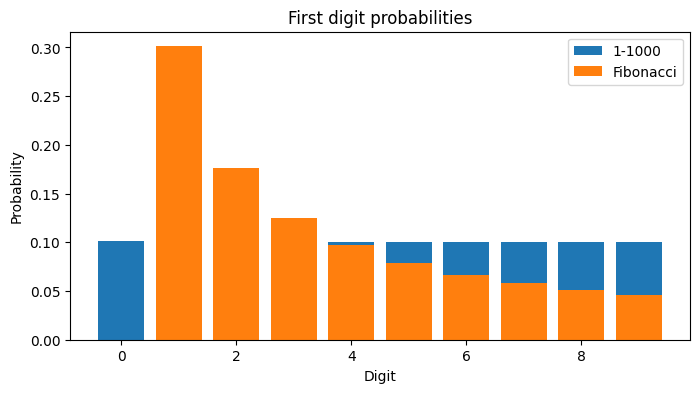

In [537]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(first_digit_probabilities_for_numbers.keys(), first_digit_probabilities_for_numbers.values(), label='1-1000')
ax.bar(fcount.keys(), fcount.values(), label='Fibonacci')
ax.set_title('First digit probabilities')
ax.set_xlabel('Digit')
ax.set_ylabel('Probability')
ax.legend()
plt.show()

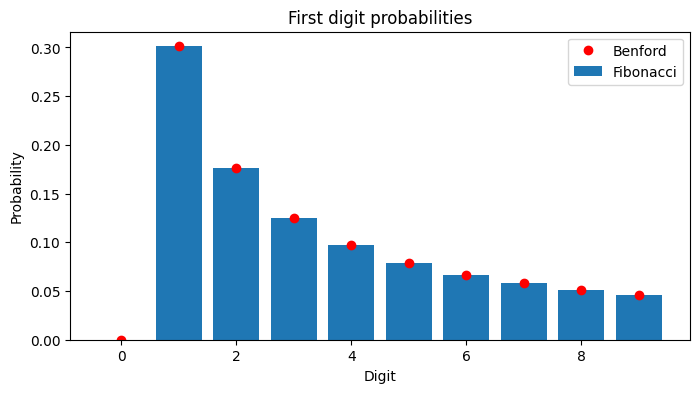

In [538]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(benford_nth_digit_probabilities(1).keys()), list(benford_nth_digit_probabilities(1).values()), 'ro', label='Benford')
ax.bar(fcount.keys(), fcount.values(), label='Fibonacci')
ax.set_title('First digit probabilities')
ax.set_xlabel('Digit')
ax.set_ylabel('Probability')
ax.legend()
plt.show()


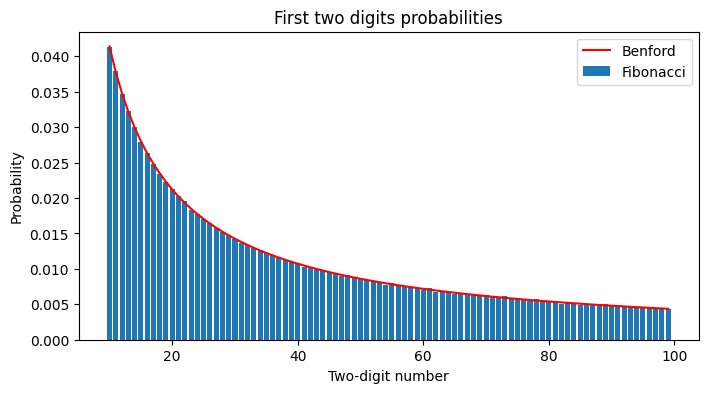

In [539]:
#plot in a graph Benford's first two digits probabilities as a red circle and the Fibonacci sequence as a bar chart
#For first two digits so use the function Benford_theory_firsttwo_digits and data_digit_probabilities_firsttwo
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(Benford_theory_firsttwo_digits().keys()), list(Benford_theory_firsttwo_digits().values()), 'r', label='Benford')
ax.bar(data_digit_probabilities_firsttwo(fib).keys(), data_digit_probabilities_firsttwo(fib).values(), label='Fibonacci')
ax.set_title('First two digits probabilities')
ax.set_xlabel('Two-digit number')
ax.set_ylabel('Probability')
ax.legend()
plt.show()



In [540]:
#create a table with this columns: first digit, Benford's probabilities, Fibonacci's sequence probabilities, Difference
Benford_theory = pd.DataFrame(benford_nth_digit_probabilities(1).items(), columns=['First digit', 'Benford probabilities'])
Benford_theory['Fibonacci\'s sequence probabilities'] = data_digit_probabilities(fib, 1).values()
Benford_theory['Difference'] = Benford_theory['Fibonacci\'s sequence probabilities'] - Benford_theory['Benford probabilities']
#Benford_theory = Benford_theory.round(3)
Benford_theory

,First digit,Benford probabilities,Fibonacci's sequence probabilities,Difference
0,0,0.000000,0.0000,0.000000
1,1,0.301030,0.3011,0.000070
2,2,0.176091,0.1762,0.000109
3,3,0.124939,0.1250,0.000061
4,4,0.096910,0.0968,-0.000110
5,5,0.079181,0.0792,0.000019
6,6,0.066947,0.0668,-0.000147
7,7,0.057992,0.0580,0.000008
8,8,0.051153,0.0513,0.000147
9,9,0.045757,0.0456,-0.000157


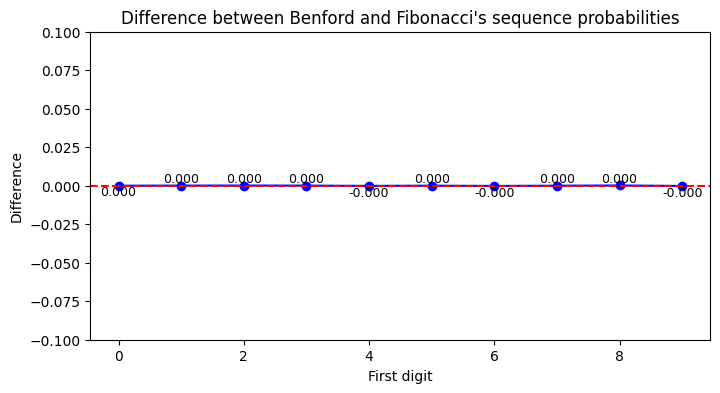

In [541]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(Benford_theory['First digit'], Benford_theory['Difference'], 'bo-')
ax.axhline(0, color='red', linestyle='--')
ax.set_title('Difference between Benford and Fibonacci\'s sequence probabilities')
ax.set_xlabel('First digit')
ax.set_ylabel('Difference')

for i, (x, y) in enumerate(zip(Benford_theory['First digit'], Benford_theory['Difference'])):
    ax.text(x, y, f'{y:.3f}', ha='center', va='bottom' if y > 0 else 'top', fontsize=9, color='black')

ax.set_ylim(-0.1, 0.1)
plt.show()


In [542]:
#create a table with this columns: first digit, Benford's probabilities, Election data 2018 probabilities, Difference
Benford_theory = pd.DataFrame(benford_nth_digit_probabilities_gen(6,1).items(), columns=['First digit', 'Benford probabilities'])
Benford_theory['Fibonacci\'s sequence probabilities'] = data_digit_probabilities_gen(fib, 6,1).values()
Benford_theory['Difference'] = Benford_theory['Fibonacci\'s sequence probabilities'] - Benford_theory['Benford probabilities']
#Benford_theory = Benford_theory.round(3)
Benford_theory

,First digit,Benford probabilities,Fibonacci's sequence probabilities,Difference
0,0,0.000000,0.000000,0.000000
1,1,0.386853,0.386869,0.000016
2,2,0.226294,0.226391,0.000096
3,3,0.160558,0.160606,0.000048
4,4,0.124539,0.124374,-0.000165
5,5,0.101756,0.101760,0.000005


#### Fibonacci's tests

##### Z-Statistic

In [543]:
benford_nth_digit_probabilities(1).values()

dict_values([0, 0.3010299956639812, 0.17609125905568124, 0.12493873660829993, 0.09691001300805642, 0.07918124604762482, 0.06694678963061322, 0.05799194697768673, 0.05115252244738129, 0.04575749056067514])

In [544]:
#count the number of rows in Fibonacci dataset
len(fib)

10000

In [545]:
BP=Benford_theory_firsttwo_digits().values()
BP

dict_values([0.04139268515822508, 0.037788560889399754, 0.03476210625921191, 0.032184683371401235, 0.029963223377443202, 0.028028723600243534, 0.02632893872234915, 0.024823583725032145, 0.0234810958495229, 0.022276394711152208, 0.021189299069938092, 0.02020338608828699, 0.019305155195386624, 0.018483405694013133, 0.017728766960431616, 0.01703333929878037, 0.016390416188169384, 0.015794267183231885, 0.015239966556736905, 0.014723256820706378, 0.014240439114610285, 0.013788284485633285, 0.013363961557981502, 0.012964977164367635, 0.012589127308020467, 0.012234456417011586, 0.01189922329970769, 0.011581872549815138, 0.011281010409689084, 0.010995384301463145, 0.010723865391773066, 0.010465433678164979, 0.010219165181686028, 0.009984220906600923, 0.00975983728915624, 0.009545317906230361, 0.009340026254143432, 0.009143379439869719, 0.008954842652926412, 0.008773924307505152, 0.00860017176191757, 0.008433167536862764, 0.008272525965989857, 0.00811789022217946, 0.007968929671275373, 0.007825

In [546]:
data_digit_probabilities_firsttwo(fib).values()

dict_values([0.041324794876926155, 0.03792275365219131, 0.0347208324994997, 0.03221933159895938, 0.03001801080648389, 0.02791675005003002, 0.026415849509705824, 0.024814888933360015, 0.023414048429057435, 0.02231338803281969, 0.021212727636581948, 0.02021212727636582, 0.01951170702421453, 0.018310986591955174, 0.017710626375825496, 0.017010206123674206, 0.01650990594356614, 0.015709425655393235, 0.015209125475285171, 0.014808885331198719, 0.01420852511506904, 0.013708224934960976, 0.013307984790874524, 0.013007804682809685, 0.012707624574744846, 0.012307384430658395, 0.011907144286571943, 0.01150690414248549, 0.011306784070442265, 0.011006603962377426, 0.010806483890334201, 0.010306183710226135, 0.010206123674204523, 0.010006003602161296, 0.00980588353011807, 0.009605763458074845, 0.009305583350010006, 0.009005403241945167, 0.00910546327796678, 0.008705223133880328, 0.008605163097858715, 0.00840504302581549, 0.008304982989793876, 0.008204922953772264, 0.007704622773664198, 0.0080048028

In [547]:

BP=list(Benford_theory_firsttwo_digits().values())
AP=list(data_digit_probabilities_firsttwo(fib).values())
N=len(fib)

# Calculate the Z-statistic, I want to pass two list of dictionaries keys
z_value = calculate_z_statistic(AP, BP, N)
print(f"Z-statistic value: {z_value}")





N: 10000
Z-Statistics and Hypothesis Tests

Digit 1:
  Actual proportion (DP): 0.0413
  Expected proportion (BP): 0.0414
  Z-statistic: 0.0090
  p-value: 0.9928
  Critical value at alpha=0.1%: 3.2905
  Fail to reject null hypothesis at alpha=0.1%
  Critical value at alpha=1.0%: 2.5758
  Fail to reject null hypothesis at alpha=1.0%
  Critical value at alpha=5.0%: 1.9600
  Fail to reject null hypothesis at alpha=5.0%
Digit 2:
  Actual proportion (DP): 0.0379
  Expected proportion (BP): 0.0378
  Z-statistic: 0.0442
  p-value: 0.9648
  Critical value at alpha=0.1%: 3.2905
  Fail to reject null hypothesis at alpha=0.1%
  Critical value at alpha=1.0%: 2.5758
  Fail to reject null hypothesis at alpha=1.0%
  Critical value at alpha=5.0%: 1.9600
  Fail to reject null hypothesis at alpha=5.0%
Digit 3:
  Actual proportion (DP): 0.0347
  Expected proportion (BP): 0.0348
  Z-statistic: 0.0225
  p-value: 0.9820
  Critical value at alpha=0.1%: 3.2905
  Fail to reject null hypothesis at alpha=0.1%
  C

In [548]:
#create a table with this columns: two-digit number, Benford's probabilities, Fibonacci's sequence probabilities, Z-statistic
Benford_theory = pd.DataFrame(Benford_theory_firsttwo_digits().items(), columns=['Two-digit number', 'Benford probabilities'])
Benford_theory['Fibonacci\'s sequence probabilities'] = data_digit_probabilities_firsttwo(fib).values()
Benford_theory['Z-statistic'] = z_value
Benford_theory = Benford_theory.round(3)
Benford_theory


,Two-digit number,Benford probabilities,Fibonacci's sequence probabilities,Z-statistic
0,10,0.041,0.041,NaN
1,11,0.038,0.038,NaN
2,12,0.035,0.035,NaN
3,13,0.032,0.032,NaN
4,14,0.030,0.030,NaN
...,...,...,...,...
85,95,0.005,0.005,NaN
86,96,0.005,0.005,NaN
87,97,0.004,0.005,NaN
88,98,0.004,0.004,NaN


In [549]:
#calculate the z-statistic with the function above for the first position, keep only the pnumbers that come from benford_nth_digit_probabilities(1) and data_digit_probabilities(fib, 1) from index 1 to 9, so remove
#the first element of the list
BP=list(benford_nth_digit_probabilities(1).values())[1:]
AP=list(data_digit_probabilities(fib, 1).values())[1:]
N=len(fib)
z_value = calculate_z_statistic(AP, BP, N)
print(f"Z-statistic value: {z_value}")


N: 10000
Z-Statistics and Hypothesis Tests

Digit 1:
  Actual proportion (DP): 0.3011
  Expected proportion (BP): 0.3010
  Z-statistic: 0.0044
  p-value: 0.9965
  Critical value at alpha=0.1%: 3.2905
  Fail to reject null hypothesis at alpha=0.1%
  Critical value at alpha=1.0%: 2.5758
  Fail to reject null hypothesis at alpha=1.0%
  Critical value at alpha=5.0%: 1.9600
  Fail to reject null hypothesis at alpha=5.0%
Digit 2:
  Actual proportion (DP): 0.1762
  Expected proportion (BP): 0.1761
  Z-statistic: 0.0154
  p-value: 0.9877
  Critical value at alpha=0.1%: 3.2905
  Fail to reject null hypothesis at alpha=0.1%
  Critical value at alpha=1.0%: 2.5758
  Fail to reject null hypothesis at alpha=1.0%
  Critical value at alpha=5.0%: 1.9600
  Fail to reject null hypothesis at alpha=5.0%
Digit 3:
  Actual proportion (DP): 0.1250
  Expected proportion (BP): 0.1249
  Z-statistic: 0.0034
  p-value: 0.9973
  Critical value at alpha=0.1%: 3.2905
  Fail to reject null hypothesis at alpha=0.1%
  C

In [550]:
#calculate the z-statistic with the function above for the second position
BP=list(benford_nth_digit_probabilities(2).values())
AP=list(data_digit_probabilities(fib, 2).values())
N=len(fib)
z_value = calculate_z_statistic(AP, BP, N)
print(f"Z-statistic value: {z_value}")


N: 10000
Z-Statistics and Hypothesis Tests

Digit 1:
  Actual proportion (DP): 0.1198
  Expected proportion (BP): 0.1197
  Z-statistic: 0.0131
  p-value: 0.9895
  Critical value at alpha=0.1%: 3.2905
  Fail to reject null hypothesis at alpha=0.1%
  Critical value at alpha=1.0%: 2.5758
  Fail to reject null hypothesis at alpha=1.0%
  Critical value at alpha=5.0%: 1.9600
  Fail to reject null hypothesis at alpha=5.0%
Digit 2:
  Actual proportion (DP): 0.1139
  Expected proportion (BP): 0.1139
  Z-statistic: 0.0069
  p-value: 0.9945
  Critical value at alpha=0.1%: 3.2905
  Fail to reject null hypothesis at alpha=0.1%
  Critical value at alpha=1.0%: 2.5758
  Fail to reject null hypothesis at alpha=1.0%
  Critical value at alpha=5.0%: 1.9600
  Fail to reject null hypothesis at alpha=5.0%
Digit 3:
  Actual proportion (DP): 0.1086
  Expected proportion (BP): 0.1088
  Z-statistic: 0.0663
  p-value: 0.9472
  Critical value at alpha=0.1%: 3.2905
  Fail to reject null hypothesis at alpha=0.1%
  C

##### MAD

Comparison between Fibonacci first significant digit and Benford's law first significant digit

In [551]:
BP=list(benford_nth_digit_probabilities(1).values())[1:]
AP=list(data_digit_probabilities(fib, 1).values())[1:]
K=len(BP)
mad = calculate_mad(AP, BP, K)
print(f"Mean Absolute Deviation (MAD) from Benford's Law: {mad}")

Number of digits (K): 9
Mean Absolute Deviation (MAD) from Benford's Law: 9.206515540995108e-05


In [552]:
#apply the function calculate_mad to the second position of the Fibonacci sequence
BP=list(benford_nth_digit_probabilities(2).values())
AP=list(data_digit_probabilities(fib, 2).values())
K=len(BP)   #number of digits
mad = calculate_mad(AP, BP, K)
print(f"Mean Absolute Deviation (MAD) from Benford's Law: {mad}")

Number of digits (K): 10
Mean Absolute Deviation (MAD) from Benford's Law: 0.00015219369250198816


In [553]:
#apply the function calculate_mad to the firsttwo position of the Fibonacci sequence
BP=list(Benford_theory_firsttwo_digits().values())
AP=list(data_digit_probabilities_firsttwo(fib).values())
K=len(BP)   #number of digits
mad = calculate_mad(AP, BP, K)
print(f"Mean Absolute Deviation (MAD) from Benford's Law: {mad}")


Number of digits (K): 90
Mean Absolute Deviation (MAD) from Benford's Law: 8.210617381083443e-05


##### Chi-square test

In [554]:
#apply the chi square to the first position of the Fibonacci sequence
BP=list(benford_nth_digit_probabilities(1).values())[1:]
AP=list(data_digit_probabilities(fib, 1).values())[1:]
N=len(fib)
calculate_chi_square(AP, BP, N)


N: 10000
Chi-Square statistic: 0.0153
Critical value (alpha=0.1%): 26.1245
Chi-Square statistic > Critical value: Fail to reject the null hypothesis
Critical value (alpha=1.0%): 20.0902
Chi-Square statistic > Critical value: Fail to reject the null hypothesis
Critical value (alpha=5.0%): 15.5073
Chi-Square statistic > Critical value: Fail to reject the null hypothesis


{0.001: {'chi_square': 0.015330245678050618,
  'critical_value': 26.12448155837614,
  'p_value': 0.999999999857044,
  'decision': 'Fail to reject the null hypothesis'},
 0.01: {'chi_square': 0.015330245678050618,
  'critical_value': 20.090235029663233,
  'p_value': 0.999999999857044,
  'decision': 'Fail to reject the null hypothesis'},
 0.05: {'chi_square': 0.015330245678050618,
  'critical_value': 15.507313055865453,
  'p_value': 0.999999999857044,
  'decision': 'Fail to reject the null hypothesis'}}

In [555]:
#apply the chi square to the second position of the Fibonacci sequence
BP=list(benford_nth_digit_probabilities(2).values())
AP=list(data_digit_probabilities(fib, 2).values())
N=len(fib)
calculate_chi_square(AP, BP, N)


N: 10000
Chi-Square statistic: 0.0367
Critical value (alpha=0.1%): 27.8772
Chi-Square statistic > Critical value: Fail to reject the null hypothesis
Critical value (alpha=1.0%): 21.6660
Chi-Square statistic > Critical value: Fail to reject the null hypothesis
Critical value (alpha=5.0%): 16.9190
Chi-Square statistic > Critical value: Fail to reject the null hypothesis


{0.001: {'chi_square': 0.036684439117149144,
  'critical_value': 27.877164871256568,
  'p_value': 0.99999999971149,
  'decision': 'Fail to reject the null hypothesis'},
 0.01: {'chi_square': 0.036684439117149144,
  'critical_value': 21.665994333461924,
  'p_value': 0.99999999971149,
  'decision': 'Fail to reject the null hypothesis'},
 0.05: {'chi_square': 0.036684439117149144,
  'critical_value': 16.918977604620448,
  'p_value': 0.99999999971149,
  'decision': 'Fail to reject the null hypothesis'}}

In [556]:
len(fib)

10000

In [557]:
#apply the chi square to the firsttwo position of the Fibonacci sequence
BP=list(Benford_theory_firsttwo_digits().values())
AP=list(data_digit_probabilities_firsttwo(fib).values())
N=len(fib)
calculate_chi_square(AP, BP, N)


N: 10000
Chi-Square statistic: 1.3222
Critical value (alpha=0.1%): 135.9776
Chi-Square statistic > Critical value: Fail to reject the null hypothesis
Critical value (alpha=1.0%): 122.9422
Chi-Square statistic > Critical value: Fail to reject the null hypothesis
Critical value (alpha=5.0%): 112.0220
Chi-Square statistic > Critical value: Fail to reject the null hypothesis


{0.001: {'chi_square': 1.322200666733364,
  'critical_value': 135.97756707124026,
  'p_value': 1.0,
  'decision': 'Fail to reject the null hypothesis'},
 0.01: {'chi_square': 1.322200666733364,
  'critical_value': 122.9422067982886,
  'p_value': 1.0,
  'decision': 'Fail to reject the null hypothesis'},
 0.05: {'chi_square': 1.322200666733364,
  'critical_value': 112.02198574980785,
  'p_value': 1.0,
  'decision': 'Fail to reject the null hypothesis'}}

##### FSD mean

In [658]:
print("Benford's Law FSD Mean:", calculate_fsd_mean(list(benford_nth_digit_probabilities(1).values())[1:], start_digit=1, num_digits=9), 
      " | Uniform FSD Mean:", calculate_fsd_mean(uniform_first_digit, start_digit=1, num_digits=9),
      " | Fibonacci FSD Mean:", calculate_fsd_mean(list(data_digit_probabilities(fib, 1).values())[1:], start_digit=1, num_digits=9))

Benford's Law FSD Mean: 3.440236967123206  | Uniform FSD Mean: 5.0  | Fibonacci FSD Mean: 3.4393000000000002


In [656]:
print("Benford's Law FSD Mean:", calculate_fsd_mean(list(benford_nth_digit_probabilities(2).values()), start_digit=0, num_digits=10), 
      " | Uniform FSD Mean:", calculate_fsd_mean(uniform_other_digits, start_digit=0, num_digits=10),
      " | Fibonacci FSD Mean:", calculate_fsd_mean(list(data_digit_probabilities(fib, 2).values()), start_digit=0, num_digits=10))

Benford's Law FSD Mean: 4.1873897069289425  | Uniform FSD Mean: 4.500000000000001  | Fibonacci FSD Mean: 4.187012207324394


In [657]:
print("Benford's Law FSD Mean:", calculate_fsd_mean(list(Benford_theory_firsttwo_digits().values()), start_digit=10, num_digits=90),
       " | Uniform FSD Mean:", calculate_fsd_mean(uniform_10_99, start_digit=10, num_digits=90), 
       " | Fibonacci FSD Mean:", calculate_fsd_mean(list(data_digit_probabilities_firsttwo(fib).values()), start_digit=10, num_digits=90))


Benford's Law FSD Mean: 38.589759378161006  | Uniform FSD Mean: 54.5  | Fibonacci FSD Mean: 38.58064838903343


##### Kolmogorov-Smirnov test

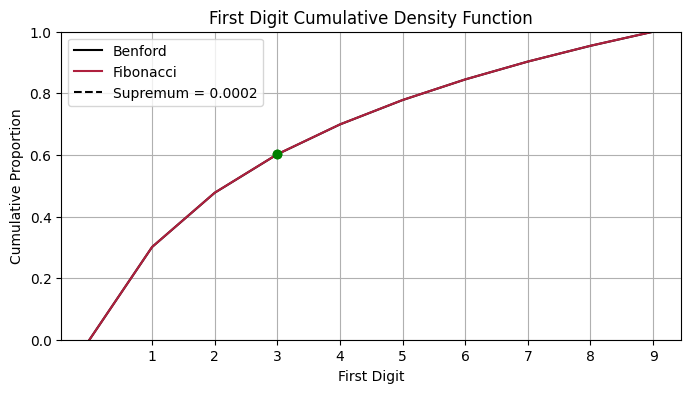

(0.0002400086720375505, 3)

In [561]:
# Calculate cumulative proportions for Benford's law and Fibonacci sequence
benford_digits = list(benford_nth_digit_probabilities(1).keys())
benford_probs = list(benford_nth_digit_probabilities(1).values())
benford_cumulative = [sum(benford_probs[:i+1]) for i in range(len(benford_probs))]

fib_digits = list(data_digit_probabilities(fib, 1).keys())
fib_probs = list(data_digit_probabilities(fib, 1).values())
fib_cumulative = [sum(fib_probs[:i+1]) for i in range(len(fib_probs))]

# Calculate the supremum (maximum difference) and find the corresponding x value
differences = [abs(b - f) for b, f in zip(benford_cumulative, fib_cumulative)]
supremum = max(differences)
supremum_index = differences.index(supremum)
supremum_x = benford_digits[supremum_index]
supremum_y_benford = benford_cumulative[supremum_index]
supremum_y_fib = fib_cumulative[supremum_index]

# Plot cumulative density functions
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(benford_digits, benford_cumulative, 'black', label='Benford')
ax.plot(fib_digits, fib_cumulative, color="#af203e", label='Fibonacci')

# Highlight the supremum point
ax.plot([supremum_x], [supremum_y_benford], 'go')  # Point on Benford curve
ax.plot([supremum_x], [supremum_y_fib], 'go')  # Point on Fibonacci curve
ax.vlines(supremum_x, supremum_y_fib, supremum_y_benford, colors='k', linestyle='--', label=f'Supremum = {supremum:.4f}')

ax.set_xticks(range(1, 10))

# Add title, labels, and legend
ax.set_title('First Digit Cumulative Density Function')
ax.set_xlabel('First Digit')
ax.set_ylabel('Cumulative Proportion')
ax.set_ylim(0, 1)  # Ensure the y-axis starts at 0 and ends at 1
ax.legend()
ax.grid(True)
plt.show()

supremum, supremum_x




In [562]:
#calculate the ks statistic for the first position of the Fibonacci sequence
N=len(fib)
calculate_ks_statistic(list(data_digit_probabilities(fib, 1).values())[1:], list(benford_nth_digit_probabilities(1).values())[1:],N)



KS statistic: 0.0002
Alpha=0.001: Fail to reject null hypothesis (KS=0.0002 <= Critical=0.0195)
Alpha=0.010: Fail to reject null hypothesis (KS=0.0002 <= Critical=0.0163)
Alpha=0.050: Fail to reject null hypothesis (KS=0.0002 <= Critical=0.0136)


(0.0002400086720375505,
 {0.001: 'Fail to reject null hypothesis (KS=0.0002 <= Critical=0.0195)',
  0.01: 'Fail to reject null hypothesis (KS=0.0002 <= Critical=0.0163)',
  0.05: 'Fail to reject null hypothesis (KS=0.0002 <= Critical=0.0136)'})

### 2018 Italian elections

#### Data cleaning and preparation

In this cell, we select only the columns that we need for the analysis. We don't have the data for the polling stations so we use the aggregation for comune.

In [677]:
file_path = "C:/Users/franc/Desktop/Tesi/Benford/Codice/Dati/Camera2018_livComune.txt"
election_data_18 = pd.read_csv(file_path, sep=";", encoding='latin1')
election_data_18_region=election_data_18
election_data_18 = election_data_18[['COMUNE','VOTANTI', 'LISTA', 'COGNOME', 'NOME', 'VOTI_LISTA']]
election_data_18



,COMUNE,VOTANTI,LISTA,COGNOME,NOME,VOTI_LISTA
0,TORINO,124770,CASAPOUND ITALIA,ARNONE,GINO MICHELE DOMENICO,972.0
1,TORINO,124770,IL POPOLO DELLA FAMIGLIA,COLUCCI,VITANTONIO,765.0
2,TORINO,124770,NOI CON L'ITALIA - UDC,FRANCIA,MARCO,743.0
3,TORINO,124770,LEGA,FRANCIA,MARCO,15783.0
4,TORINO,124770,FORZA ITALIA,FRANCIA,MARCO,15055.0
...,...,...,...,...,...,...
133819,VILLENEUVE,705,POUR TOUS PER TUTTI PE TCHEUT,MARCOZ,GIAMPAOLO,NaN
133820,VILLENEUVE,705,FI -FRAT. D'IT. -MOV.NUOVA VALLE D'AOSTA,MELGARA,EDOARDO,NaN
133821,VILLENEUVE,705,RISPOSTA CIVICA,MINELLI,CHIARA,NaN
133822,VILLENEUVE,705,POTERE AL POPOLO!,RAPPAZZO,FRANCESCO,NaN


In [564]:
#show me the highest and lowest value of "VOTANTI" with all the row
election_data_18.loc[election_data_18['VOTANTI'].idxmax()]
election_data_18.loc[election_data_18['VOTANTI'].idxmin()]


COMUNE                  MONCENISIO
VOTANTI                         24
LISTA         PARTITO VALORE UMANO
COGNOME                    CARELLA
NOME                       CLAUDIA
VOTI_LISTA                     0.0
Name: 3820, dtype: object

Here we remove all the municipalities with the same name. This are CALLIANO, CASTRO, LIVO, PEGLIO, SAMONE, SAN TEODORO and VALVERDE.


In [565]:
#remove from the dataset the rows with COMUNE == ["CALLIANO", "CASTRO", "LIVO", "PEGLIO", "SAMONE", "SAN TEODORO", "VALVERDE"]
election_data_18 = election_data_18[~election_data_18['COMUNE'].isin(["CALLIANO", "CASTRO", "LIVO", "PEGLIO", "SAMONE", "SAN TEODORO", "VALVERDE"])]

In [566]:
#show me the column with the same name of COMUNE, bigger than 18. FOr example, if I have 18 columns with COMUNE=="CASIER" I don't want to show "CASIER", 
# if instead I have 100 column with COMUNE=="TORINO" I want to show "TORINO"
# I want to do it for all the variables in COMUNE
election_data_18.groupby('COMUNE').filter(lambda x: x.shape[0] > 25)['COMUNE'].unique()


array(['TORINO', 'MILANO', 'GENOVA', 'BOLOGNA', 'FIRENZE', 'ROMA',
       'NAPOLI', 'BARI', 'PALERMO'], dtype=object)

In the next cell, we group the data by comune and we sum the votes for each party, without taking into consideration the different candidates. Due to the electoral law (Rosatellum bis), the voters can't write the preference for the candidate, that are elected in the order of the blocked list, but can choose only the party. So we will consider only the votes for the party, for each comune.

In [567]:
#group by comune and lista and sum the VOTI_LISTA
election_18_grouped = election_data_18.groupby(['COMUNE', 'LISTA'])['VOTI_LISTA'].sum().reset_index()
election_18_grouped


,COMUNE,LISTA,VOTI_LISTA
0,ABANO TERME,+EUROPA,343.0
1,ABANO TERME,10 VOLTE MEGLIO,47.0
2,ABANO TERME,CASAPOUND ITALIA,72.0
3,ABANO TERME,CIVICA POPOLARE LORENZIN,48.0
4,ABANO TERME,FORZA ITALIA,1408.0
...,...,...,...
133112,ZUNGRI,PARTITO COMUNISTA,2.0
133113,ZUNGRI,PARTITO DEMOCRATICO,165.0
133114,ZUNGRI,PARTITO VALORE UMANO,1.0
133115,ZUNGRI,PER UNA SINISTRA RIVOLUZIONARIA,1.0


In order to apply the Benford's law, we need to consider the first significant digit of the votes. For doing this, we have to removes all the parties that has zero votes.

In [675]:
#count the values of VOTI_LISTA equal to 1
election_18_grouped[election_18_grouped['VOTI_LISTA'] == 0].shape[0]

0

In [569]:
election_18_grouped = election_18_grouped[election_18_grouped['VOTI_LISTA'] != 0].reset_index(drop=True)
election_18_grouped['VOTI_LISTA'] = election_18_grouped['VOTI_LISTA'].astype(int)
print(election_18_grouped)


             COMUNE                            LISTA  VOTI_LISTA
0       ABANO TERME                          +EUROPA         343
1       ABANO TERME                  10 VOLTE MEGLIO          47
2       ABANO TERME                 CASAPOUND ITALIA          72
3       ABANO TERME         CIVICA POPOLARE LORENZIN          48
4       ABANO TERME                     FORZA ITALIA        1408
...             ...                              ...         ...
121954       ZUNGRI                PARTITO COMUNISTA           2
121955       ZUNGRI              PARTITO DEMOCRATICO         165
121956       ZUNGRI             PARTITO VALORE UMANO           1
121957       ZUNGRI  PER UNA SINISTRA RIVOLUZIONARIA           1
121958       ZUNGRI                POTERE AL POPOLO!           2

[121959 rows x 3 columns]


In [570]:
#count the values of VOTI_LISTA equal to 1
election_18_grouped[election_18_grouped['VOTI_LISTA'] == 1].shape[0]


8609

In [571]:
#print the list of LISTA and the number of unique values
election_18_grouped['LISTA'].unique()
#election_18_grouped['LISTA'].nunique()

array(['+EUROPA', '10 VOLTE MEGLIO', 'CASAPOUND ITALIA',
       'CIVICA POPOLARE LORENZIN', 'FORZA ITALIA',
       "FRATELLI D'ITALIA CON GIORGIA MELONI", 'GRANDE NORD',
       'IL POPOLO DELLA FAMIGLIA', 'ITALIA AGLI ITALIANI',
       'ITALIA EUROPA INSIEME', 'LEGA', 'LIBERI E UGUALI',
       'MOVIMENTO 5 STELLE', "NOI CON L'ITALIA - UDC",
       'PARTITO DEMOCRATICO', 'PARTITO REPUBBLICANO ITALIANO - ALA',
       'PARTITO VALORE UMANO', 'POTERE AL POPOLO!',
       'PER UNA SINISTRA RIVOLUZIONARIA', 'PARTITO COMUNISTA',
       'AUTODETERMINATZIONE', "BLOCCO NAZIONALE PER LE LIBERTA'",
       'LISTA DEL POPOLO PER LA COSTITUZIONE', 'ITALIA NEL CUORE',
       "PATTO PER L'AUTONOMIA", 'SIAMO', 'SVP - PATT', 'RINASCIMENTO MIR'],
      dtype=object)

In [572]:
#count the number of column with COMUNE == 'ROMA' and give me a number
election_18_grouped[election_18_grouped['COMUNE'] == 'ROMA'].shape[0]

19

In [573]:
election_18_grouped.loc[election_18_grouped['VOTI_LISTA'].idxmax()]
#election_data_18.loc[election_data_18['VOTANTI'].idxmin()]

COMUNE                      ROMA
LISTA         MOVIMENTO 5 STELLE
VOTI_LISTA                423382
Name: 88897, dtype: object

In [574]:
#compute general statistics like mean, median, std, min, max, qqplot, quantiles, skewness for the VOTI_LISTA
election_18_grouped['VOTI_LISTA'].describe()

#save it in a table that I can use in a LaTeX document
#election_18_grouped['VOTI_LISTA'].describe().to_latex('election_data_18_statistics.tex', float_format="%.3f")


count    121959.000000
mean        258.852065
std        2393.420465
min           1.000000
25%           6.000000
50%          22.000000
75%         110.000000
max      423382.000000
Name: VOTI_LISTA, dtype: float64

###### Some preliminar tests


In [575]:
#check if there are zero values in election_18_grouped['VOTI_LISTA]
election_18_grouped[election_18_grouped['VOTI_LISTA'] == 0].shape[0]

#check if there are negative values in election_18_grouped['VOTI_LISTA]
election_18_grouped[election_18_grouped['VOTI_LISTA'] < 0].shape[0]

#compute the mean of the VOTI_LISTA
election_18_grouped['VOTI_LISTA'].mean()

#compute the median of the VOTI_LISTA
election_18_grouped['VOTI_LISTA'].median()


22.0

In [576]:
#write the deciles of the VOTI_LISTA
election_18_grouped['VOTI_LISTA'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])



0.1      2.0
0.2      4.0
0.3      7.0
0.4     13.0
0.5     22.0
0.6     39.0
0.7     76.0
0.8    166.0
0.9    460.0
Name: VOTI_LISTA, dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Deciles of VOTI_LISTA:
0.1      2.0
0.2      4.0
0.3      7.0
0.4     13.0
0.5     22.0
0.6     39.0
0.7     76.0
0.8    166.0
0.9    460.0
Name: VOTI_LISTA, dtype: float64
Mean of VOTI_LISTA: 258.85206503825054
Median of VOTI_LISTA: 22.0


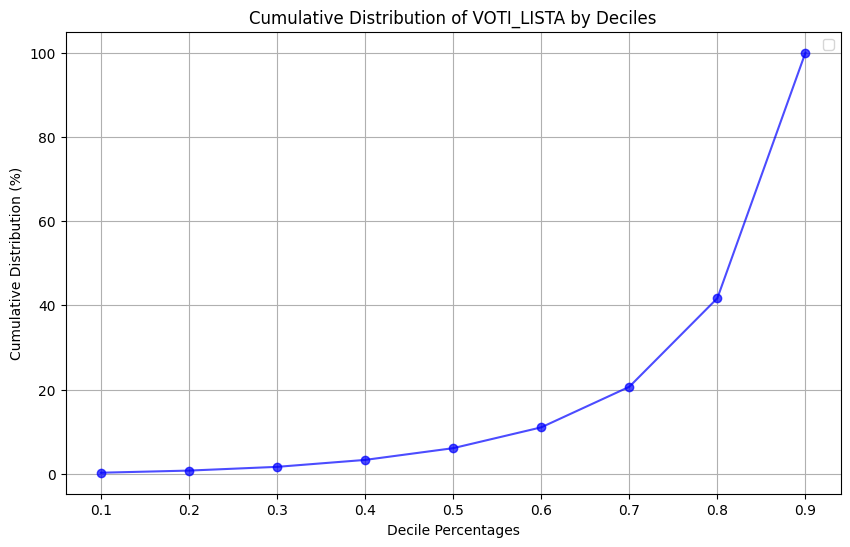


Cumulative Distribution (in percentage):
0.1      0.253485
0.2      0.760456
0.3      1.647655
0.4      3.295311
0.5      6.083650
0.6     11.026616
0.7     20.659062
0.8     41.698352
0.9    100.000000
Name: VOTI_LISTA, dtype: float64


In [577]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the deciles of VOTI_LISTA
deciles = election_18_grouped['VOTI_LISTA'].quantile([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

# Calculate the mean and median of VOTI_LISTA
mean = election_18_grouped['VOTI_LISTA'].mean()
median = election_18_grouped['VOTI_LISTA'].median()

# Print the deciles, mean, and median
print("Deciles of VOTI_LISTA:")
print(deciles)
print(f"Mean of VOTI_LISTA: {mean}")
print(f"Median of VOTI_LISTA: {median}")

# Calculate the cumulative distribution based on deciles
cumulative_percentage = deciles.cumsum()  # Calculate the cumulative sum
cumulative_percentage = cumulative_percentage / cumulative_percentage.iloc[-1] * 100  # Normalize to percentage

# Plotting the cumulative distribution
plt.figure(figsize=(10, 6))
plt.plot(cumulative_percentage.index, cumulative_percentage.values, marker='o', color='blue', linestyle='-', alpha=0.7)

# Adding labels and title
plt.title("Cumulative Distribution of VOTI_LISTA by Deciles")
plt.xlabel("Decile Percentages")
plt.ylabel("Cumulative Distribution (%)")
plt.grid(True)
plt.xticks(cumulative_percentage.index)

# Display the legend for the mean and median lines
plt.legend()

# Show the plot
plt.show()

# Print cumulative percentages for reference
print("\nCumulative Distribution (in percentage):")
print(cumulative_percentage)


In [578]:
# Calcolare i quartili di VOTI_LISTA
quartiles = election_18_grouped['VOTI_LISTA'].quantile([0.25, 0.5, 0.75])

# Stampare i quartili
print("Quartiles of VOTI_LISTA:")
print(quartiles)

Quartiles of VOTI_LISTA:
0.25      6.0
0.50     22.0
0.75    110.0
Name: VOTI_LISTA, dtype: float64


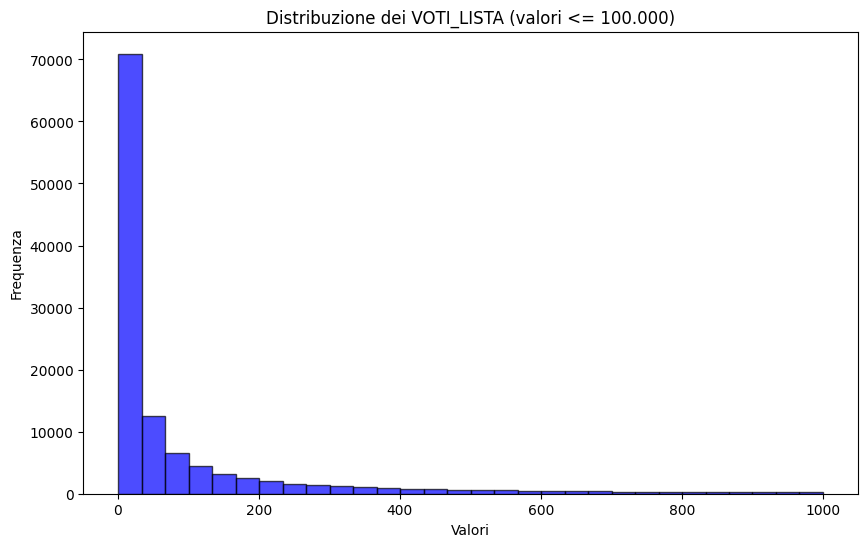

90.21414346922765 19.0


In [579]:
import matplotlib.pyplot as plt

# Filtrare i valori di VOTI_LISTA per includere solo quelli <= 100.000
filtered_voti_lista = election_18_grouped['VOTI_LISTA'][election_18_grouped['VOTI_LISTA'] <= 1000]

# Creare il grafico solo con i valori filtrati
plt.figure(figsize=(10, 6))
plt.hist(filtered_voti_lista, bins=30, color='blue', alpha=0.7, edgecolor='black')
plt.title("Distribuzione dei VOTI_LISTA (valori <= 100.000)")
plt.xlabel("Valori")
plt.ylabel("Frequenza")
plt.show()

print(filtered_voti_lista.mean(), filtered_voti_lista.median())

If the mean is less than the median, the distribution is right-skewed. If the mean is greater than the median, the distribution is left-skewed. If the mean is equal to the median, the distribution is perfectly symmetrical.

#### First digit analysis

The first digit test compares the actual first digit frequency distribution of data that come from the italian election
with that developed by Benford.
It is an extremely high-level test and will only identify obvious anomalies (i.e., it will only point
you in the right direction)

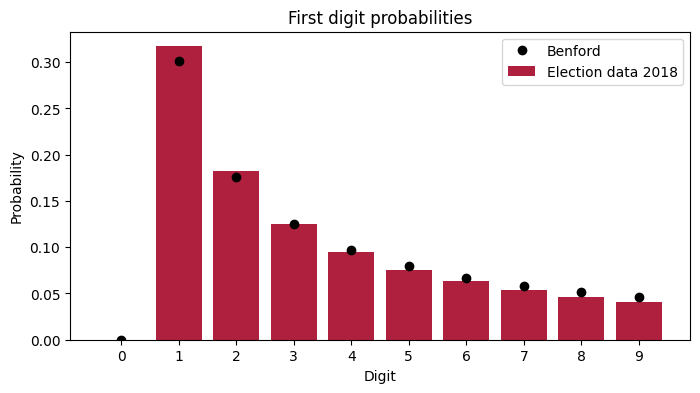

In [581]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(benford_nth_digit_probabilities(1).keys()), list(benford_nth_digit_probabilities(1).values()), 'ko', label='Benford')
ax.bar(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).keys(), data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).values(), label='Election data 2018', color='#af203e')
ax.set_title('First digit probabilities')
ax.set_xlabel('Digit')
ax.set_ylabel('Probability')
ax.legend()
plt.xticks(range(10))
plt.show()


In [582]:
#create a table with this columns: first digit, Benford's probabilities, Election data 2018 probabilities, Difference
Benford_theory = pd.DataFrame(benford_nth_digit_probabilities(1).items(), columns=['First digit', 'Benford probabilities'])
Benford_theory['Election data 2018 probabilities'] = data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).values()
Benford_theory['Difference'] = Benford_theory['Election data 2018 probabilities'] - Benford_theory['Benford probabilities']
#Benford_theory = Benford_theory.round(3)
Benford_theory

#write the result for a LaTeX table
#Benford_theory.to_latex('italy_first_digit.tex', float_format="%.3f")



,First digit,Benford probabilities,Election data 2018 probabilities,Difference
0,0,0.000000,0.000000,0.000000
1,1,0.301030,0.317074,0.016044
2,2,0.176091,0.182217,0.006126
3,3,0.124939,0.125624,0.000685
4,4,0.096910,0.095352,-0.001558
5,5,0.079181,0.075730,-0.003451
6,6,0.066947,0.063390,-0.003557
7,7,0.057992,0.054092,-0.003900
8,8,0.051153,0.045827,-0.005326
9,9,0.045757,0.040694,-0.005063


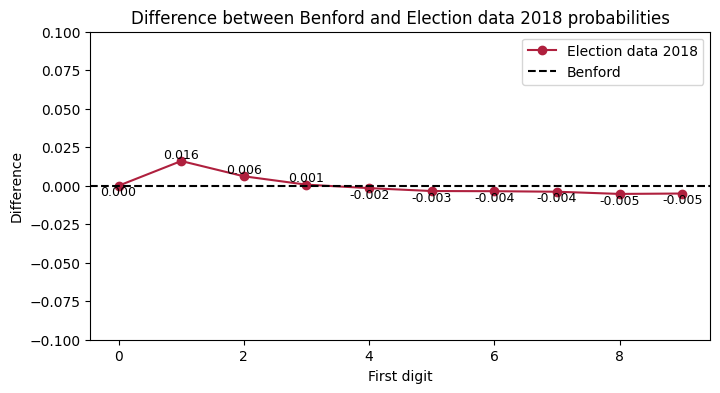

In [583]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(Benford_theory['First digit'], Benford_theory['Difference'], 'o-', color='#af203e')
ax.axhline(0, color='black', linestyle='--')
ax.set_title('Difference between Benford and Election data 2018 probabilities')
ax.set_xlabel('First digit')
ax.set_ylabel('Difference')

for i, (x, y) in enumerate(zip(Benford_theory['First digit'], Benford_theory['Difference'])):
    ax.text(x, y, f'{y:.3f}', ha='center', va='bottom' if y > 0 else 'top', fontsize=9, color='black')

ax.set_ylim(-0.1, 0.1)

ax.legend(['Election data 2018', 'Benford'], loc='upper right')

plt.show()


##### Z-Statistic

In [584]:
#apply z-statistic to the election data 2018, first position
BP=list(benford_nth_digit_probabilities(1).values())[1:]
print(BP)
AP=list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).values())[1:]
print(AP)
N=len(election_18_grouped)
print(N)
z_value = calculate_z_statistic(AP, BP, N)
print(f"Z-statistic value: {z_value}")
#print z-statistic values i for LaTeX table, with digits from 1 to 9, diffrences between percentages and z-statistic values
#write the result for a LaTeX table called z_statistic_18_first.tex
Benford_theory = pd.DataFrame(benford_nth_digit_probabilities(1).items(), columns=['First digit', 'Benford probabilities'])
Benford_theory['Election data 2018 probabilities'] = data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).values()
Benford_theory['Difference'] = Benford_theory['Election data 2018 probabilities'] - Benford_theory['Benford probabilities']
#remove the index 0
Benford_theory = Benford_theory[1:]
Benford_theory['Z-statistic'] = z_value
Benford_theory.to_latex('z_statistic_18_first.tex', float_format="%.3f")



[0.3010299956639812, 0.17609125905568124, 0.12493873660829993, 0.09691001300805642, 0.07918124604762482, 0.06694678963061322, 0.05799194697768673, 0.05115252244738129, 0.04575749056067514]
[0.31707377069342974, 0.18221697455702326, 0.1256241851769857, 0.09535171656048344, 0.07573036840249592, 0.06339015570806583, 0.054091948933658034, 0.04582687624529555, 0.0406940037225625]
121959
N: 121959
Z-Statistics and Hypothesis Tests

Digit 1:
  Actual proportion (DP): 0.3171
  Expected proportion (BP): 0.3010
  Z-statistic: 12.2115
  p-value: 0.0000
  Critical value at alpha=0.1%: 3.2905
  Reject null hypothesis at alpha=0.1%
  Critical value at alpha=1.0%: 2.5758
  Reject null hypothesis at alpha=1.0%
  Critical value at alpha=5.0%: 1.9600
  Reject null hypothesis at alpha=5.0%
Digit 2:
  Actual proportion (DP): 0.1822
  Expected proportion (BP): 0.1761
  Z-statistic: 5.6126
  p-value: 0.0000
  Critical value at alpha=0.1%: 3.2905
  Reject null hypothesis at alpha=0.1%
  Critical value at alp

##### MAD

In [585]:
#apply MAD function to the election data, first position
BP=list(benford_nth_digit_probabilities(1).values())[1:]
AP=list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).values())[1:]
K=len(BP)   #number of digits
mad = calculate_mad(AP, BP, K)
print(f"Mean Absolute Deviation (MAD) from Benford's Law: {mad}")


Number of digits (K): 9
Mean Absolute Deviation (MAD) from Benford's Law: 0.005078875355439187


##### Chi-square test

In [586]:
#apply chi square to the election data, first position
BP=list(benford_nth_digit_probabilities(1).values())[1:]
AP=list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).values())[1:]
N=len(election_18_grouped)
cs_first_digit=calculate_chi_square(AP, BP, N)
cs_first_digit



N: 121959
Chi-Square statistic: 343.1198
Critical value (alpha=0.1%): 26.1245
Chi-Square statistic > Critical value: Reject the null hypothesis
Critical value (alpha=1.0%): 20.0902
Chi-Square statistic > Critical value: Reject the null hypothesis
Critical value (alpha=5.0%): 15.5073
Chi-Square statistic > Critical value: Reject the null hypothesis


{0.001: {'chi_square': 343.11975065660795,
  'critical_value': 26.12448155837614,
  'p_value': 0.0,
  'decision': 'Reject the null hypothesis'},
 0.01: {'chi_square': 343.11975065660795,
  'critical_value': 20.090235029663233,
  'p_value': 0.0,
  'decision': 'Reject the null hypothesis'},
 0.05: {'chi_square': 343.11975065660795,
  'critical_value': 15.507313055865453,
  'p_value': 0.0,
  'decision': 'Reject the null hypothesis'}}

The data suggest a significant difference between the observed and expected frequencies. This result confirms the strong deviation of the observed frequencies from the expected proportions, indicating that the theoretical model (expected distribution) does not fit well with the observed data.

##### FSD mean

In [587]:
print("Benford's Law FSD Mean:", calculate_fsd_mean(list(benford_nth_digit_probabilities(1).values())[1:], start_digit=1, num_digits=9), 
      " | Uniform FSD Mean:", calculate_fsd_mean(uniform_first_digit, start_digit=1, num_digits=9),
        " | Election data 2018 FSD Mean:", calculate_fsd_mean(list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).values())[1:], start_digit=1, num_digits=9))

Benford's Law FSD Mean: 3.440236967123206  | Uniform FSD Mean: 5.0  | Election data 2018 FSD Mean: 3.3102846038422755


##### Kolmogorov-Smirnov test

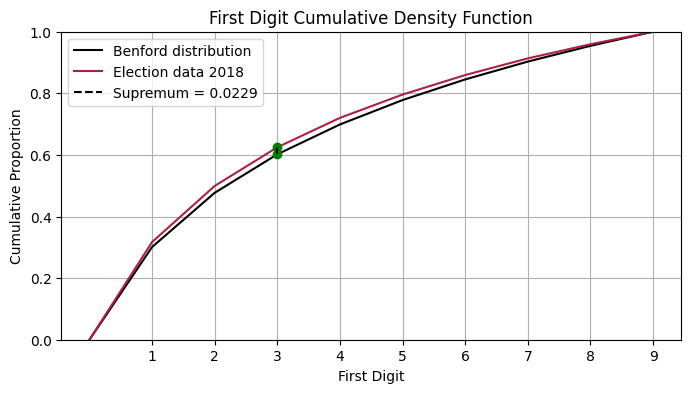

In [588]:
# Calculate cumulative proportions for Benford's law and first position of the election data
benford_digits = list(benford_nth_digit_probabilities(1).keys())
benford_probs = list(benford_nth_digit_probabilities(1).values())
benford_cumulative = [sum(benford_probs[:i+1]) for i in range(len(benford_probs))]

election_digits = list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).keys())
election_probs = list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).values())
election_cumulative = [sum(election_probs[:i+1]) for i in range(len(election_probs))]

# Calculate the supremum (maximum difference) and find the corresponding x value
differences = [abs(b - u) for b, u in zip(benford_cumulative, election_cumulative)]
supremum = max(differences)
supremum_index = differences.index(supremum)
supremum_x = benford_digits[supremum_index]
supremum_y_benford = benford_cumulative[supremum_index]
supremum_y_el = election_cumulative[supremum_index]

# Plot cumulative density functions
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(benford_digits, benford_cumulative, 'black', label='Benford distribution')
ax.plot(election_digits, election_cumulative, color="#af203e", label='Election data 2018')

# Highlight the supremum point
ax.plot([supremum_x], [supremum_y_benford], 'go')  # Point on Benford curve
ax.plot([supremum_x], [supremum_y_el], 'go')  # Point on Election curve
ax.vlines(supremum_x, supremum_y_el, supremum_y_benford, colors='k', linestyle='--', label=f'Supremum = {supremum:.4f}')

ax.set_xticks(range(1, 10))
# Add title, labels, and legend
ax.set_title('First Digit Cumulative Density Function')
ax.set_xlabel('First Digit')
ax.set_ylabel('Cumulative Proportion')
ax.set_ylim(0, 1)  # Ensure the y-axis starts at 0 and ends at 1
ax.legend()
ax.grid(True)
plt.show()

In [589]:
#calculate the ks statistic for the first position of the election data
N=len(election_18_grouped)
calculate_ks_statistic(list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 1).values())[1:], list(benford_nth_digit_probabilities(1).values())[1:],N)
supremum, supremum_x


KS statistic: 0.0229
Alpha=0.001: Reject null hypothesis (KS=0.0229 > Critical=0.0056)
Alpha=0.010: Reject null hypothesis (KS=0.0229 > Critical=0.0047)
Alpha=0.050: Reject null hypothesis (KS=0.0229 > Critical=0.0039)


(0.022854939099476335, 3)

In [590]:
z_value

{'Digit_1': 12.211481164429287,
 'Digit_2': 5.612605783886533,
 'Digit_3': 0.7196290015543682,
 'Digit_4': 1.8346916015325403,
 'Digit_5': 4.457814413263635,
 'Digit_6': 4.9639466969032116,
 'Digit_7': 5.821077572173993,
 'Digit_8': 8.435543217728098,
 'Digit_9': 8.45559858216933}

#### Second digit

We can do the same analysis that we have done for the first digit but for the second digit.

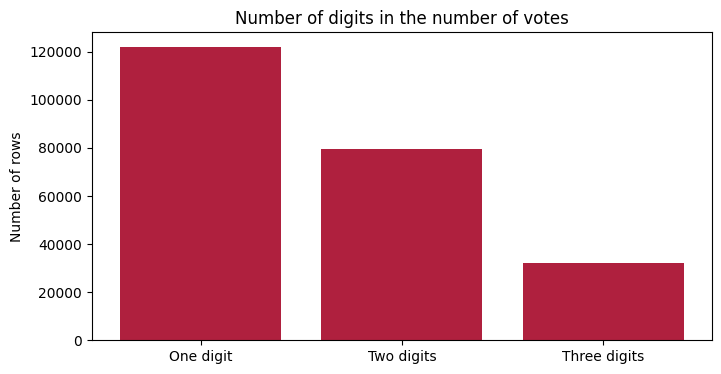

,digit,value,percentage,difference
0,One digit,121959,1.000000,0
1,Two digits,79576,0.652482,-42383
2,Three digits,32089,0.263113,-47487


In [591]:
#count the number of rows in election_18_grouped['VOTI_LISTA']
onep=election_18_grouped['VOTI_LISTA'].shape[0]

#count the number of rows in election_18_grouped['VOTI_LISTA'] with values bigger or equal to 10. In other words values that have 2 digits or more
twop=election_18_grouped[election_18_grouped['VOTI_LISTA'] >= 10].shape[0]

#count the number of rows in election_18_grouped['VOTI_LISTA'] with values bigger or equal to 100. In other words values that have 3 digits or more
threep=election_18_grouped[election_18_grouped['VOTI_LISTA'] >= 100].shape[0]

#plot in bar chart onep, twop, threep
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(['One digit', 'Two digits', 'Three digits'], [onep, twop, threep], color='#af203e')
ax.set_title('Number of digits in the number of votes')
ax.set_ylabel('Number of rows')
plt.show()

#visualize the number of onep, twop, threep
onep, twop, threep

#write the difference between the number of onep, twop, threep in a table with the value and the percentage and the values of onep, twop, threep
#I want a table with 4 columns: digit, value, percentage, difference
data = {'digit': ['One digit', 'Two digits', 'Three digits'],
        'value': [onep, twop, threep],
        'percentage': [onep/onep, twop/onep, threep/onep],
        'difference': [0, twop-onep, threep-twop]}

digits = pd.DataFrame(data)
digits



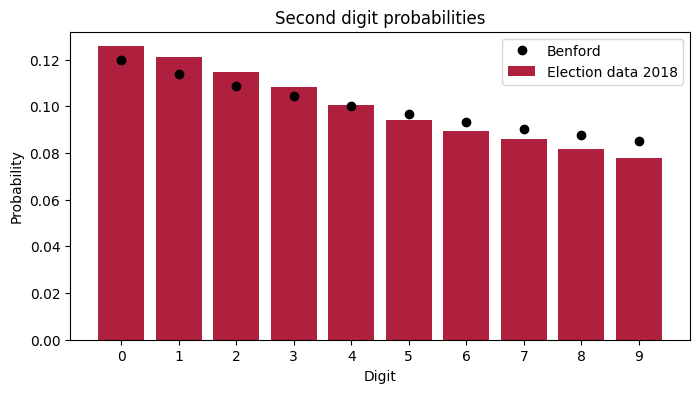

In [592]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(benford_nth_digit_probabilities(2).keys()), list(benford_nth_digit_probabilities(2).values()), 'ko', label='Benford')
ax.bar(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 2).keys(), data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 2).values(), label='Election data 2018', color='#af203e')
ax.set_title('Second digit probabilities')
ax.set_xlabel('Digit')
ax.set_ylabel('Probability')
ax.legend()
plt.xticks(range(10))

plt.show()


In [593]:
Benford_theory = pd.DataFrame(benford_nth_digit_probabilities(2).items(), columns=['Second digit', 'Benford probabilities'])
Benford_theory['Election data 2018 probabilities'] = data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 2).values()
Benford_theory['Difference'] = Benford_theory['Election data 2018 probabilities'] - Benford_theory['Benford probabilities']
#Benford_theory = Benford_theory.round(3)
Benford_theory

Benford_theory.to_latex('italy_second_digit.tex', float_format="%.3f")


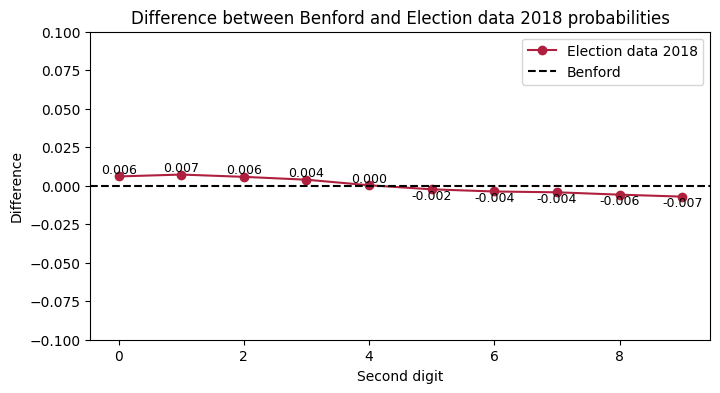

In [594]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(Benford_theory['Second digit'], Benford_theory['Difference'], 'o-', color='#af203e')
ax.axhline(0, color='black', linestyle='--')
ax.set_title('Difference between Benford and Election data 2018 probabilities')
ax.set_xlabel('Second digit')
ax.set_ylabel('Difference')

for i, (x, y) in enumerate(zip(Benford_theory['Second digit'], Benford_theory['Difference'])):
    ax.text(x, y, f'{y:.3f}', ha='center', va='bottom' if y > 0 else 'top', fontsize=9, color='black')

ax.set_ylim(-0.1, 0.1)
ax.legend(['Election data 2018', 'Benford'], loc='upper right')

plt.show()


##### Z-Statistic

In [595]:
#apply z-statistic to the election data 2018, second position
BP=list(benford_nth_digit_probabilities(2).values())
print(BP)
AP=list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 2).values())
print(AP)
N=twop
print(N)
z_value = calculate_z_statistic(AP, BP, N)
print(f"Z-statistic value: {z_value}")

#print z-statistic values i for LaTeX table, with digits from 1 to 9, diffrences between percentages and z-statistic values
#write the result for a LaTeX table called z_statistic_18_first.tex
Benford_theory = pd.DataFrame(benford_nth_digit_probabilities(2).items(), columns=['Second digit', 'Benford probabilities'])
Benford_theory['Election data 2018 probabilities'] = data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 2).values()
Benford_theory['Difference'] = Benford_theory['Election data 2018 probabilities'] - Benford_theory['Benford probabilities']
Benford_theory['Z-statistic'] = z_value
Benford_theory.to_latex('z_statistic_18_second.tex', float_format="%.3f")

[0.11967926859688076, 0.1138901034075564, 0.10882149900550823, 0.10432956023095939, 0.10030820226757937, 0.09667723580232243, 0.09337473578303615, 0.09035198926960332, 0.08757005357886138, 0.08499735205769224]
[0.12570372976776917, 0.1211420528802654, 0.114582286116417, 0.10823615160349855, 0.1006082235850005, 0.0943374886900573, 0.08962501256660299, 0.08608123052176536, 0.08177088569417915, 0.07791293857444456]
79576
N: 79576
Z-Statistics and Hypothesis Tests

Digit 1:
  Actual proportion (DP): 0.1257
  Expected proportion (BP): 0.1197
  Z-statistic: 5.2303
  p-value: 0.0000
  Critical value at alpha=0.1%: 3.2905
  Reject null hypothesis at alpha=0.1%
  Critical value at alpha=1.0%: 2.5758
  Reject null hypothesis at alpha=1.0%
  Critical value at alpha=5.0%: 1.9600
  Reject null hypothesis at alpha=5.0%
Digit 2:
  Actual proportion (DP): 0.1211
  Expected proportion (BP): 0.1139
  Z-statistic: 6.4340
  p-value: 0.0000
  Critical value at alpha=0.1%: 3.2905
  Reject null hypothesis at

In [596]:
#Compute the chi-square test for the election data 2018, second digit
#It's not possible because we have 0 values in the Benford's Law

In [597]:
(election_18_grouped['VOTI_LISTA'], 2)

(0          343
 1           47
 2           72
 3           48
 4         1408
           ... 
 121954       2
 121955     165
 121956       1
 121957       1
 121958       2
 Name: VOTI_LISTA, Length: 121959, dtype: int32,
 2)

##### MAD


In [598]:
#apply MAD function to the election data, second position
BP=list(benford_nth_digit_probabilities(2).values())
AP=list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 2).values())
K=len(BP)   #number of digits
mad = calculate_mad(AP, BP, K)
print(f"Mean Absolute Deviation (MAD) from Benford's Law: {mad}")

Number of digits (K): 10
Mean Absolute Deviation (MAD) from Benford's Law: 0.004648762088893263


##### Chi-square test

In [599]:
#apply chi square to the election data, second position
BP=list(benford_nth_digit_probabilities(2).values())
AP=list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 2).values())
N=twop
calculate_chi_square(AP, BP, N)


N: 79576
Chi-Square statistic: 206.9584
Critical value (alpha=0.1%): 27.8772
Chi-Square statistic > Critical value: Reject the null hypothesis
Critical value (alpha=1.0%): 21.6660
Chi-Square statistic > Critical value: Reject the null hypothesis
Critical value (alpha=5.0%): 16.9190
Chi-Square statistic > Critical value: Reject the null hypothesis


{0.001: {'chi_square': 206.95842466011368,
  'critical_value': 27.877164871256568,
  'p_value': 0.0,
  'decision': 'Reject the null hypothesis'},
 0.01: {'chi_square': 206.95842466011368,
  'critical_value': 21.665994333461924,
  'p_value': 0.0,
  'decision': 'Reject the null hypothesis'},
 0.05: {'chi_square': 206.95842466011368,
  'critical_value': 16.918977604620448,
  'p_value': 0.0,
  'decision': 'Reject the null hypothesis'}}

##### SSD mean

In [600]:
print("Benford's Law FSD Mean:", calculate_fsd_mean(list(benford_nth_digit_probabilities(2).values()), start_digit=0, num_digits=10), 
    " | Uniform FSD Mean:", calculate_fsd_mean(uniform_other_digits, start_digit=0, num_digits=10),
    " | Election data 2018 FSD Mean:", calculate_fsd_mean(list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 2).values()), start_digit=0, num_digits=10))

Benford's Law FSD Mean: 4.1873897069289425  | Uniform FSD Mean: 4.500000000000001  | Election data 2018 FSD Mean: 4.044837639489293


##### Kolmogorov-Smirnov test


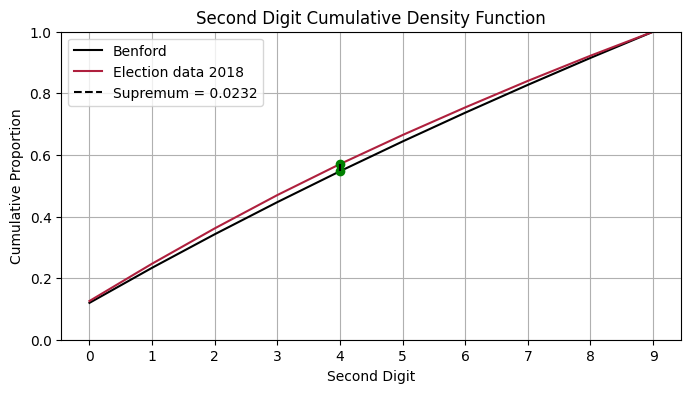

(4, 0.02324381044446644)

In [601]:
# Calculate cumulative proportions for Benford's law and second position of the election data
benford_digits = list(benford_nth_digit_probabilities(2).keys())
benford_probs = list(benford_nth_digit_probabilities(2).values())
benford_cumulative = [sum(benford_probs[:i+1]) for i in range(len(benford_probs))]

election_digits = list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 2).keys())
election_probs = list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 2).values())
election_cumulative = [sum(election_probs[:i+1]) for i in range(len(election_probs))]


# Calculate the supremum (maximum difference) and find the corresponding x value
differences = [abs(b - u) for b, u in zip(benford_cumulative, election_cumulative)]
supremum = max(differences)
supremum_index = differences.index(supremum)
supremum_x = benford_digits[supremum_index]
supremum_y_benford = benford_cumulative[supremum_index]
supremum_y_el = election_cumulative[supremum_index]

# Plot cumulative density functions
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(benford_digits, benford_cumulative, 'black', label='Benford')
ax.plot(election_digits, election_cumulative, color="#af203e", label='Election data 2018')

# Highlight the supremum point
ax.plot([supremum_x], [supremum_y_benford], 'go')  # Point on Benford curve
ax.plot([supremum_x], [supremum_y_el], 'go')  # Point on Uniform curve
ax.vlines(supremum_x, supremum_y_el, supremum_y_benford, colors='k', linestyle='--', label=f'Supremum = {supremum:.4f}')

ax.set_xticks(range(10))
# Add title, labels, and legend
ax.set_title('Second Digit Cumulative Density Function')
ax.set_xlabel('Second Digit')
ax.set_ylabel('Cumulative Proportion')
ax.set_ylim(0, 1)  # Ensure the y-axis starts at 0 and ends at 1
ax.legend()
ax.grid(True)
plt.show()

supremum_x, supremum

In [602]:
#calculate the ks statistic for the second position of the election data
N=twop
print(N)
calculate_ks_statistic(list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 2).values()), list(benford_nth_digit_probabilities(2).values()),N)


79576
KS statistic: 0.0232
Alpha=0.001: Reject null hypothesis (KS=0.0232 > Critical=0.0069)
Alpha=0.010: Reject null hypothesis (KS=0.0232 > Critical=0.0058)
Alpha=0.050: Reject null hypothesis (KS=0.0232 > Critical=0.0048)


(0.02324381044446644,
 {0.001: 'Reject null hypothesis (KS=0.0232 > Critical=0.0069)',
  0.01: 'Reject null hypothesis (KS=0.0232 > Critical=0.0058)',
  0.05: 'Reject null hypothesis (KS=0.0232 > Critical=0.0048)'})

#### First-two digits

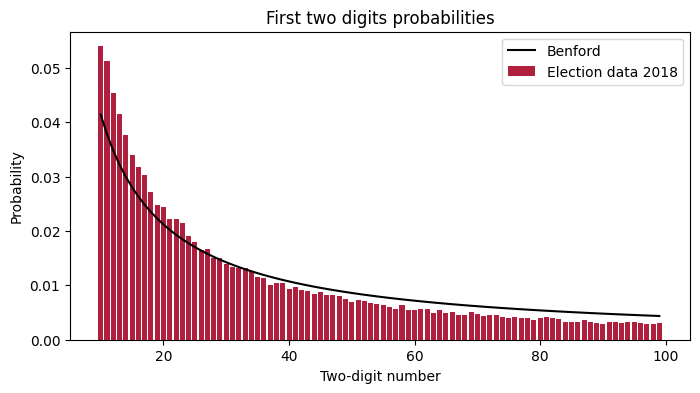

In [603]:
#use our dataset for the first two digits
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(Benford_theory_firsttwo_digits().keys()), list(Benford_theory_firsttwo_digits().values()), 'black', label='Benford')
ax.bar(data_digit_probabilities_firsttwo(election_18_grouped['VOTI_LISTA']).keys(), data_digit_probabilities_firsttwo(election_18_grouped['VOTI_LISTA']).values(), label='Election data 2018',color='#af203e')
ax.set_title('First two digits probabilities')
ax.set_xlabel('Two-digit number')
ax.set_ylabel('Probability')
ax.legend()
plt.show()


##### Z-Statistic

In [604]:
# Count rows with 'VOTI_LISTA' between 10 and 99
firsttwo = election_18_grouped[(election_18_grouped['VOTI_LISTA'] >= 10)].shape[0]
N = firsttwo

BP = list(Benford_theory_firsttwo_digits().values())
AP = list(data_digit_probabilities_firsttwo(election_18_grouped['VOTI_LISTA']).values())
z_values = calculate_z_statistic(AP, BP, N)


N: 79576
Z-Statistics and Hypothesis Tests

Digit 1:
  Actual proportion (DP): 0.0539
  Expected proportion (BP): 0.0414
  Z-statistic: 17.7719
  p-value: 0.0000
  Critical value at alpha=0.1%: 3.2905
  Reject null hypothesis at alpha=0.1%
  Critical value at alpha=1.0%: 2.5758
  Reject null hypothesis at alpha=1.0%
  Critical value at alpha=5.0%: 1.9600
  Reject null hypothesis at alpha=5.0%
Digit 2:
  Actual proportion (DP): 0.0512
  Expected proportion (BP): 0.0378
  Z-statistic: 19.7885
  p-value: 0.0000
  Critical value at alpha=0.1%: 3.2905
  Reject null hypothesis at alpha=0.1%
  Critical value at alpha=1.0%: 2.5758
  Reject null hypothesis at alpha=1.0%
  Critical value at alpha=5.0%: 1.9600
  Reject null hypothesis at alpha=5.0%
Digit 3:
  Actual proportion (DP): 0.0453
  Expected proportion (BP): 0.0348
  Z-statistic: 16.2227
  p-value: 0.0000
  Critical value at alpha=0.1%: 3.2905
  Reject null hypothesis at alpha=0.1%
  Critical value at alpha=1.0%: 2.5758
  Reject null hyp

In [605]:
Benford_theory

,Second digit,Benford probabilities,Election data 2018 probabilities,Difference,Z-statistic
0,0,0.119679,0.125704,0.006024,NaN
1,1,0.113890,0.121142,0.007252,NaN
2,2,0.108821,0.114582,0.005761,NaN
3,3,0.104330,0.108236,0.003907,NaN
4,4,0.100308,0.100608,0.000300,NaN
5,5,0.096677,0.094337,-0.002340,NaN
6,6,0.093375,0.089625,-0.003750,NaN
7,7,0.090352,0.086081,-0.004271,NaN
8,8,0.087570,0.081771,-0.005799,NaN
9,9,0.084997,0.077913,-0.007084,NaN


##### MAD

In [606]:
#apply MAD function to the election data, first two digits
BP=list(Benford_theory_firsttwo_digits().values())
AP=list(data_digit_probabilities_firsttwo(election_18_grouped['VOTI_LISTA']).values())
K=len(BP)   #number of digits
mad = calculate_mad(AP, BP, K)
print(f"Mean Absolute Deviation (MAD) from Benford's Law: {mad}")

Number of digits (K): 90
Mean Absolute Deviation (MAD) from Benford's Law: 0.0020463571360578464


##### Chi-square test


In [607]:
BP=list(Benford_theory_firsttwo_digits().values())
AP=list(data_digit_probabilities_firsttwo(election_18_grouped['VOTI_LISTA']).values())
N=twop
calculate_chi_square(AP, BP, N)

N: 79576
Chi-Square statistic: 3593.0064
Critical value (alpha=0.1%): 135.9776
Chi-Square statistic > Critical value: Reject the null hypothesis
Critical value (alpha=1.0%): 122.9422
Chi-Square statistic > Critical value: Reject the null hypothesis
Critical value (alpha=5.0%): 112.0220
Chi-Square statistic > Critical value: Reject the null hypothesis


{0.001: {'chi_square': 3593.0063750260283,
  'critical_value': 135.97756707124026,
  'p_value': 0.0,
  'decision': 'Reject the null hypothesis'},
 0.01: {'chi_square': 3593.0063750260283,
  'critical_value': 122.9422067982886,
  'p_value': 0.0,
  'decision': 'Reject the null hypothesis'},
 0.05: {'chi_square': 3593.0063750260283,
  'critical_value': 112.02198574980785,
  'p_value': 0.0,
  'decision': 'Reject the null hypothesis'}}

##### FTSD mean

In [608]:
print("Benford's Law FSD Mean:", calculate_fsd_mean(list(Benford_theory_firsttwo_digits().values()), start_digit=10, num_digits=90),
       " | Uniform FSD Mean:", calculate_fsd_mean(uniform_10_99, start_digit=10, num_digits=90), 
         " | Election data 2018 FSD Mean:", calculate_fsd_mean(list(data_digit_probabilities_firsttwo(election_18_grouped['VOTI_LISTA']).values()), start_digit=10, num_digits=90))

Benford's Law FSD Mean: 38.589759378161006  | Uniform FSD Mean: 54.5  | Election data 2018 FSD Mean: 33.58879561676888


##### Kolmogorov-Smirnov test

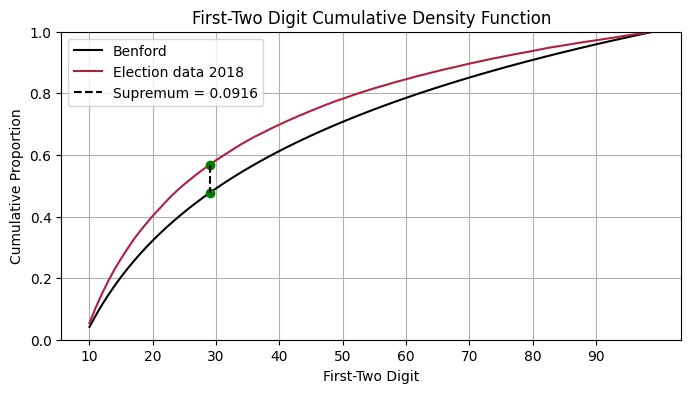

(29, 0.0916054970647951)

In [609]:
# Calculate cumulative proportions for Benford's law and first-two position of the election data
benford_digits = list(Benford_theory_firsttwo_digits().keys())
benford_probs = list(Benford_theory_firsttwo_digits().values())
benford_cumulative = [sum(benford_probs[:i+1]) for i in range(len(benford_probs))]

election_digits = list(data_digit_probabilities_firsttwo(election_18_grouped['VOTI_LISTA']).keys())
election_probs = list(data_digit_probabilities_firsttwo(election_18_grouped['VOTI_LISTA']).values())
election_cumulative = [sum(election_probs[:i+1]) for i in range(len(election_probs))]

# Calculate the supremum (maximum difference) and find the corresponding x value
differences = [abs(b - u) for b, u in zip(benford_cumulative, election_cumulative)]
supremum = max(differences)
supremum_index = differences.index(supremum)
supremum_x = benford_digits[supremum_index]
supremum_y_benford = benford_cumulative[supremum_index]
supremum_y_el = election_cumulative[supremum_index]

# Plot cumulative density functions
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(benford_digits, benford_cumulative, 'black', label='Benford')
ax.plot(election_digits, election_cumulative, color='#af203e', label='Election data 2018')

# Highlight the supremum point
ax.plot([supremum_x], [supremum_y_benford], 'go')  # Point on Benford curve
ax.plot([supremum_x], [supremum_y_el], 'go')  # Point on Uniform curve
ax.vlines(supremum_x, supremum_y_el, supremum_y_benford, colors='k', linestyle='--', label=f'Supremum = {supremum:.4f}')

# Add title, labels, and legend
ax.set_title('First-Two Digit Cumulative Density Function')
ax.set_xlabel('First-Two Digit')
ax.set_ylabel('Cumulative Proportion')
ax.set_ylim(0, 1)  # Ensure the y-axis starts at 0 and ends at 1
ax.legend()
ax.grid(True)
ax.set_xticks(range(10, 100,10))
plt.show()

#write the correspondent first two digits of the supremum
supremum_x, supremum



In [610]:
#calculate the ks statistic for the first two digits of the election data
N=firsttwo
calculate_ks_statistic(list(data_digit_probabilities_firsttwo(election_18_grouped['VOTI_LISTA']).values()), list(Benford_theory_firsttwo_digits().values()),N)


KS statistic: 0.0916
Alpha=0.001: Reject null hypothesis (KS=0.0916 > Critical=0.0069)
Alpha=0.010: Reject null hypothesis (KS=0.0916 > Critical=0.0058)
Alpha=0.050: Reject null hypothesis (KS=0.0916 > Critical=0.0048)


(0.0916054970647951,
 {0.001: 'Reject null hypothesis (KS=0.0916 > Critical=0.0069)',
  0.01: 'Reject null hypothesis (KS=0.0916 > Critical=0.0058)',
  0.05: 'Reject null hypothesis (KS=0.0916 > Critical=0.0048)'})

#### Third digit

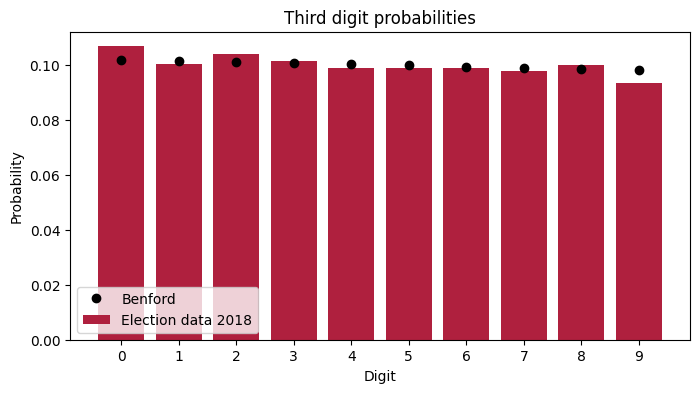

In [611]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(benford_nth_digit_probabilities(3).keys()), list(benford_nth_digit_probabilities(3).values()), 'ko', label='Benford')
ax.bar(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 3).keys(), data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 3).values(), label='Election data 2018', color='#af203e')
ax.set_title('Third digit probabilities')
ax.set_xlabel('Digit')
ax.set_ylabel('Probability')
ax.legend()

plt.xticks(range(10))

plt.show()

In [612]:
Benford_theory = pd.DataFrame(benford_nth_digit_probabilities(3).items(), columns=['Second digit', 'Benford probabilities'])
Benford_theory['Election data 2018 probabilities'] = data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 3).values()
Benford_theory['Difference'] = Benford_theory['Election data 2018 probabilities'] - Benford_theory['Benford probabilities']
#Benford_theory = Benford_theory.round(3)
Benford_theory

,Second digit,Benford probabilities,Election data 2018 probabilities,Difference
0,0,0.101784,0.106734,0.004950
1,1,0.101376,0.100284,-0.001092
2,2,0.100972,0.103930,0.002957
3,3,0.100573,0.101250,0.000677
4,4,0.100178,0.098975,-0.001203
5,5,0.099788,0.098975,-0.000813
6,6,0.099401,0.098694,-0.000707
7,7,0.099019,0.097822,-0.001198
8,8,0.098641,0.099816,0.001175
9,9,0.098267,0.093521,-0.004746


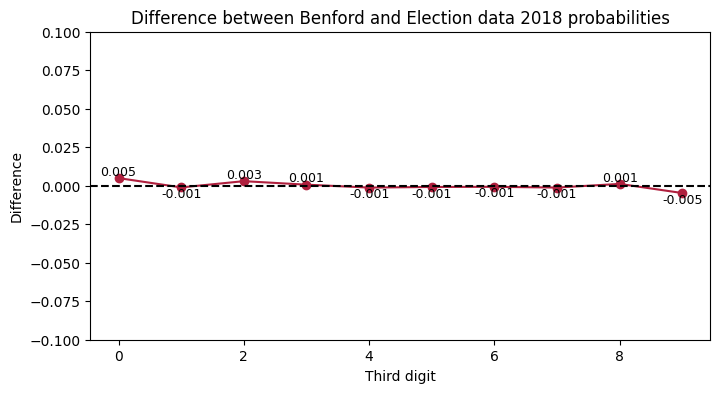

In [613]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(Benford_theory['Second digit'], Benford_theory['Difference'], 'o-', color='#af203e')
ax.axhline(0, color='black', linestyle='--')
ax.set_title('Difference between Benford and Election data 2018 probabilities')
ax.set_xlabel('Third digit')
ax.set_ylabel('Difference')

for i, (x, y) in enumerate(zip(Benford_theory['Second digit'], Benford_theory['Difference'])):
    ax.text(x, y, f'{y:.3f}', ha='center', va='bottom' if y > 0 else 'top', fontsize=9, color='black')

ax.set_ylim(-0.1, 0.1)

plt.show()

In [614]:
# Define the list of p_j as the probabilities of Benford_theory['Election data 2018 probabilities']
d= [ 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
p=list(benford_nth_digit_probabilities_gen(10, 3).values())

print(p)
# Compute the sum 
d_bar = sum(d[j] * p[j] for j in range(10))

# Print the result
print(d_bar)

[0.1017843646442167, 0.10137597744780127, 0.10097219813704164, 0.10057293211092619, 0.1001780876279476, 0.09978757569217742, 0.09940130994496177, 0.09901920656189599, 0.09864118415477718, 0.09826716367825328]
4.46776565097288


In [615]:
# Define the list of p_j as the probabilities of Benford_theory['Election data 2018 probabilities']
p=list(data_digit_probabilities(election_18_grouped['VOTI_LISTA'], 3).values())

print(p)
# Compute the sum 
d_bar = sum(d[j] * p[j] for j in range(10))

# Print the result
print(d_bar)

[0.10673439496400636, 0.10028358627567079, 0.10392969553429524, 0.10124964941257128, 0.0989747265418056, 0.0989747265418056, 0.09869425659883449, 0.09782168344292437, 0.09981613637071894, 0.09352114431736733]
4.419801177973761


In [616]:
#create a table that resum the result for first digit, second digit and first two digits with all the statistical test


#### Some corrections

We know that the Benford's law doesn't work for small numbers, so we can try to remove all the rows that has a number of votanti smaller than 1000.

In [617]:
#keep only rows with VOTANTI>1000 and voti_lista>0
election_data_18_small = election_data_18[(election_data_18['VOTANTI'] > 1000) & (election_data_18['VOTI_LISTA'] > 0)]
election_18_grouped_small = election_data_18_small.groupby(['COMUNE', 'LISTA'])['VOTI_LISTA'].sum().reset_index()
election_18_grouped_small

,COMUNE,LISTA,VOTI_LISTA
0,ABANO TERME,+EUROPA,343.0
1,ABANO TERME,10 VOLTE MEGLIO,47.0
2,ABANO TERME,CASAPOUND ITALIA,72.0
3,ABANO TERME,CIVICA POPOLARE LORENZIN,48.0
4,ABANO TERME,FORZA ITALIA,1408.0
...,...,...,...
80186,ZUNGRI,PARTITO COMUNISTA,2.0
80187,ZUNGRI,PARTITO DEMOCRATICO,165.0
80188,ZUNGRI,PARTITO VALORE UMANO,1.0
80189,ZUNGRI,PER UNA SINISTRA RIVOLUZIONARIA,1.0


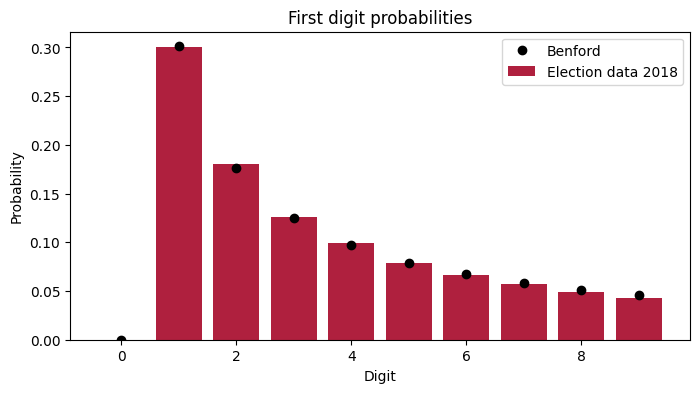

In [618]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(benford_nth_digit_probabilities(1).keys()), list(benford_nth_digit_probabilities(1).values()), 'ko', label='Benford')
ax.bar(data_digit_probabilities(election_18_grouped_small['VOTI_LISTA'], 1).keys(), data_digit_probabilities(election_18_grouped_small['VOTI_LISTA'], 1).values(), label='Election data 2018', color='#af203e')
ax.set_title('First digit probabilities')
ax.set_xlabel('Digit')
ax.set_ylabel('Probability')
ax.legend()
plt.show()

In [619]:
Benford_theory = pd.DataFrame(benford_nth_digit_probabilities(1).items(), columns=['First digit', 'Benford probabilities'])
Benford_theory['Election data 2018 probabilities'] = data_digit_probabilities(election_18_grouped_small['VOTI_LISTA'], 1).values()
Benford_theory['Difference'] = Benford_theory['Election data 2018 probabilities'] - Benford_theory['Benford probabilities']
#Benford_theory = Benford_theory.round(3)
Benford_theory

,First digit,Benford probabilities,Election data 2018 probabilities,Difference
0,0,0.000000,0.000000,0.000000
1,1,0.301030,0.300869,-0.000161
2,2,0.176091,0.180319,0.004228
3,3,0.124939,0.126161,0.001223
4,4,0.096910,0.098789,0.001879
5,5,0.079181,0.078301,-0.000881
6,6,0.066947,0.066628,-0.000318
7,7,0.057992,0.057188,-0.000803
8,8,0.051153,0.048684,-0.002469
9,9,0.045757,0.043060,-0.002698


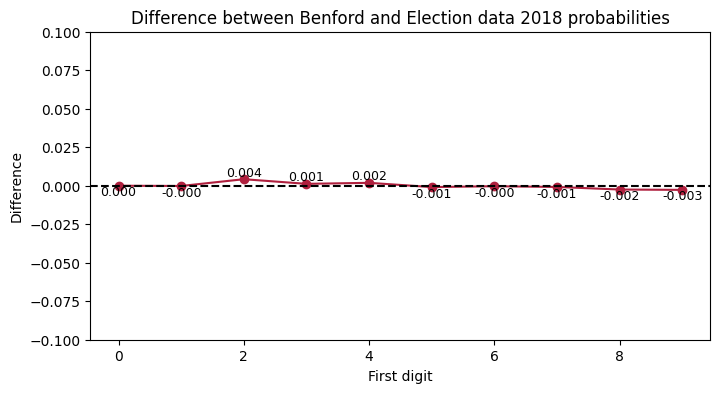

In [620]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(Benford_theory['First digit'], Benford_theory['Difference'], 'o-', color='#af203e')
ax.axhline(0, color='black', linestyle='--')
ax.set_title('Difference between Benford and Election data 2018 probabilities')
ax.set_xlabel('First digit')
ax.set_ylabel('Difference')

for i, (x, y) in enumerate(zip(Benford_theory['First digit'], Benford_theory['Difference'])):
    ax.text(x, y, f'{y:.3f}', ha='center', va='bottom' if y > 0 else 'top', fontsize=9, color='black')

ax.set_ylim(-0.1, 0.1)

plt.show()


### Italy, one region

In [712]:
election_data_18_region['CIRCOSCRIZIONE'].unique()

array(['PIEMONTE 1', 'PIEMONTE 2', 'LOMBARDIA 1', 'LOMBARDIA 2',
       'LOMBARDIA 3', 'LOMBARDIA 4', 'VENETO 1', 'VENETO 2',
       'FRIULI-VENEZIA GIULIA', 'LIGURIA', 'EMILIA-ROMAGNA', 'TOSCANA',
       'UMBRIA', 'MARCHE', 'LAZIO 1', 'LAZIO 2', 'ABRUZZO', 'MOLISE',
       'CAMPANIA 1', 'CAMPANIA 2', 'PUGLIA', 'BASILICATA', 'CALABRIA',
       'SICILIA 1', 'SICILIA 2', 'SARDEGNA',
       'TRENTINO-ALTO ADIGE/S_DTIROL', 'AOSTA'], dtype=object)

In [714]:
#check how many rows we have for each region
# first af all join together, in another dataset election_data_18_region['CIRCOSCRIZIONE']=='PIEMONTE 1' and 'PIEMONTE 2' in 'PIEMONTE'; 
# 'LOMBARDIA 1', 'LOMBARDIA 2', 'LOMBARDIA 3' and 'LOMBARDIA 4' in LOMBARDIA
# 'VENETO 1' and 'VENETO 2' in VENETO
# 'CAMPANIA 1', 'CAMPANIA 2' in CAMPANIA
# 'SICILIA 1', 'SICILIA 2' in SICILIA
# 'LAZIO 1', 'LAZIO 2' in LAZIO

election_data_18_region['CIRCOSCRIZIONE'] = election_data_18_region['CIRCOSCRIZIONE'].replace({'PIEMONTE 1': 'PIEMONTE', 'PIEMONTE 2': 'PIEMONTE',
                                                                                                'LOMBARDIA 1': 'LOMBARDIA', 'LOMBARDIA 2': 'LOMBARDIA', 'LOMBARDIA 3': 'LOMBARDIA', 'LOMBARDIA 4': 'LOMBARDIA',
                                                                                                'VENETO 1': 'VENETO', 'VENETO 2': 'VENETO',
                                                                                                'CAMPANIA 1': 'CAMPANIA', 'CAMPANIA 2': 'CAMPANIA',
                                                                                                'SICILIA 1': 'SICILIA', 'SICILIA 2': 'SICILIA',
                                                                                                'LAZIO 1': 'LAZIO', 'LAZIO 2': 'LAZIO'})

election_data_18_region['CIRCOSCRIZIONE'].unique()

#check how many rows we have for each region
election_data_18_region['CIRCOSCRIZIONE'].value_counts()


CIRCOSCRIZIONE
LOMBARDIA                       26524
PIEMONTE                        17681
VENETO                          10184
CAMPANIA                         9724
CALABRIA                         7290
LAZIO                            6618
SICILIA                          6170
SARDEGNA                         6032
EMILIA-ROMAGNA                   5574
ABRUZZO                          5185
FRIULI-VENEZIA GIULIA            4730
PUGLIA                           4496
TRENTINO-ALTO ADIGE/S_DTIROL     4380
TOSCANA                          4281
LIGURIA                          4248
MARCHE                           3584
BASILICATA                       2489
MOLISE                           2312
UMBRIA                           1656
AOSTA                             666
Name: count, dtype: int64

In [753]:
election_data_18_region
#isolate data of Veneto. So, keep only rows with CIRCOSCRIZIONE == "VENETO 1" or "VENETO 2"
veneto = election_data_18_region[election_data_18_region['CIRCOSCRIZIONE'].isin(["PUGLIA"])]
#keep only columns COMUNE, VOTANTI, LISTA, COGNOME, NOME, VOTI_LISTA
veneto = veneto[['COMUNE', 'VOTANTI', 'LISTA', 'COGNOME', 'NOME', 'VOTI_LISTA']]
veneto


,COMUNE,VOTANTI,LISTA,COGNOME,NOME,VOTI_LISTA
102301,BARI,123277,CASAPOUND ITALIA,CARADONNA,ANTONIO,744.0
102302,BARI,123277,PARTITO REPUBBLICANO ITALIANO - ALA,DIOGUARDI,GIUSEPPE,183.0
102303,BARI,123277,10 VOLTE MEGLIO,DISPOTO,ROBERTA,240.0
102304,BARI,123277,POTERE AL POPOLO!,JARBAN,BASSEM,1326.0
102305,BARI,123277,PARTITO DEMOCRATICO,LACARRA,MARCO,18267.0
...,...,...,...,...,...,...
106792,VIESTE,6908,ITALIA AGLI ITALIANI,MATRELLA,MARGHERITA ANNA TERESA,28.0
106793,VIESTE,6908,MOVIMENTO 5 STELLE,MENGA,ROSA,2176.0
106794,VIESTE,6908,PARTITO REPUBBLICANO ITALIANO - ALA,PAGANO,MAURO,2.0
106795,VIESTE,6908,10 VOLTE MEGLIO,PETRONE,DARIO,3.0


In [746]:
veneto = veneto.groupby(['COMUNE', 'LISTA'])['VOTI_LISTA'].sum().reset_index()
veneto

,COMUNE,LISTA,VOTI_LISTA
0,ACQUALAGNA,+EUROPA,28.0
1,ACQUALAGNA,CASAPOUND ITALIA,25.0
2,ACQUALAGNA,CIVICA POPOLARE LORENZIN,8.0
3,ACQUALAGNA,FORZA ITALIA,199.0
4,ACQUALAGNA,FRATELLI D'ITALIA CON GIORGIA MELONI,103.0
...,...,...,...
3579,VISSO,NOI CON L'ITALIA - UDC,1.0
3580,VISSO,PARTITO COMUNISTA,4.0
3581,VISSO,PARTITO DEMOCRATICO,76.0
3582,VISSO,PARTITO VALORE UMANO,0.0


In [747]:
#remove all the rows with VOTI_LISTA == 0
veneto = veneto[veneto['VOTI_LISTA'] != 0].reset_index(drop=True)
veneto['VOTI_LISTA'] = veneto['VOTI_LISTA'].astype(int)
veneto

,COMUNE,LISTA,VOTI_LISTA
0,ACQUALAGNA,+EUROPA,28
1,ACQUALAGNA,CASAPOUND ITALIA,25
2,ACQUALAGNA,CIVICA POPOLARE LORENZIN,8
3,ACQUALAGNA,FORZA ITALIA,199
4,ACQUALAGNA,FRATELLI D'ITALIA CON GIORGIA MELONI,103
...,...,...,...
3397,VISSO,MOVIMENTO 5 STELLE,163
3398,VISSO,NOI CON L'ITALIA - UDC,1
3399,VISSO,PARTITO COMUNISTA,4
3400,VISSO,PARTITO DEMOCRATICO,76


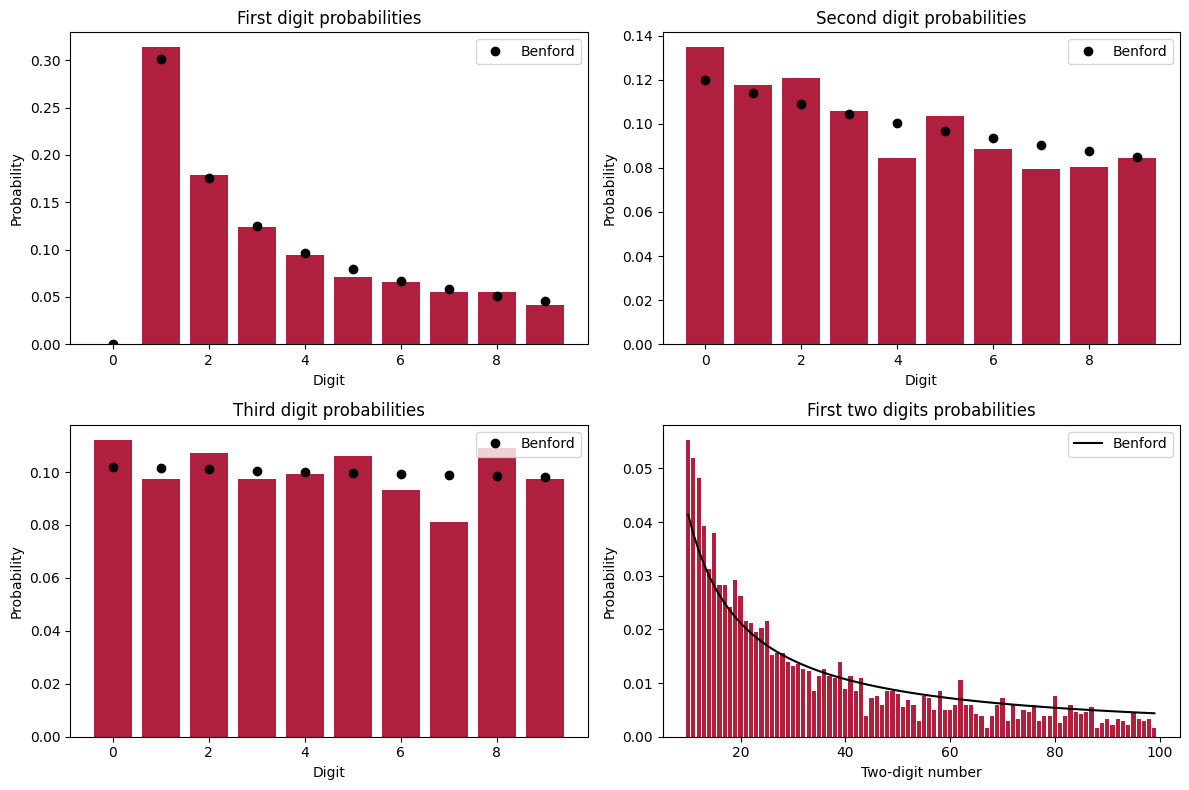

In [748]:
#visualize three plots: first digit, second digit, third digit and first two digits of veneto['VOTI_LISTA'] in color #af203e and Benford's Law in black
fig, ax = plt.subplots(2, 2, figsize=(12, 8))
ax[0, 0].plot(list(benford_nth_digit_probabilities(1).keys()), list(benford_nth_digit_probabilities(1).values()), 'ko', label='Benford')
ax[0, 0].bar(data_digit_probabilities(veneto['VOTI_LISTA'], 1).keys(), data_digit_probabilities(veneto['VOTI_LISTA'], 1).values(), color='#af203e')
ax[0, 0].set_title('First digit probabilities')
ax[0, 0].set_xlabel('Digit')
ax[0, 0].set_ylabel('Probability')
ax[0, 0].legend()

ax[0, 1].plot(list(benford_nth_digit_probabilities(2).keys()), list(benford_nth_digit_probabilities(2).values()), 'ko', label='Benford')
ax[0, 1].bar(data_digit_probabilities(veneto['VOTI_LISTA'], 2).keys(), data_digit_probabilities(veneto['VOTI_LISTA'], 2).values(), color='#af203e')
ax[0, 1].set_title('Second digit probabilities')
ax[0, 1].set_xlabel('Digit')
ax[0, 1].set_ylabel('Probability')
ax[0, 1].legend()

ax[1, 0].plot(list(benford_nth_digit_probabilities(3).keys()), list(benford_nth_digit_probabilities(3).values()), 'ko', label='Benford')
ax[1, 0].bar(data_digit_probabilities(veneto['VOTI_LISTA'], 3).keys(), data_digit_probabilities(veneto['VOTI_LISTA'], 3).values(), color='#af203e')
ax[1, 0].set_title('Third digit probabilities')
ax[1, 0].set_xlabel('Digit')
ax[1, 0].set_ylabel('Probability')
ax[1, 0].legend()

ax[1, 1].plot(list(Benford_theory_firsttwo_digits().keys()), list(Benford_theory_firsttwo_digits().values()), 'k', label='Benford')
ax[1, 1].bar(data_digit_probabilities_firsttwo(veneto['VOTI_LISTA']).keys(), data_digit_probabilities_firsttwo(veneto['VOTI_LISTA']).values(), color='#af203e')
ax[1, 1].set_title('First two digits probabilities')
ax[1, 1].set_xlabel('Two-digit number')
ax[1, 1].set_ylabel('Probability')
ax[1, 1].legend()

plt.tight_layout()
plt.show()



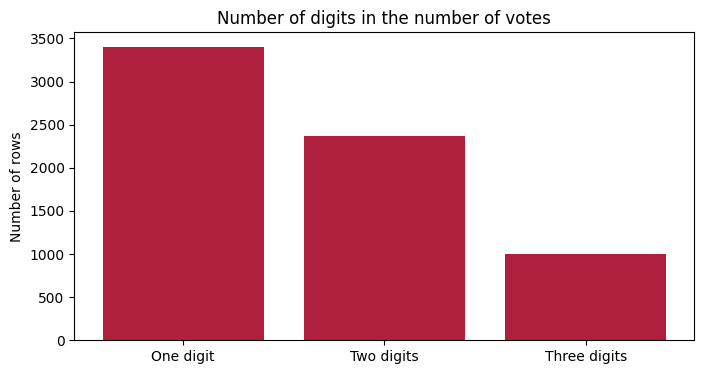

,digit,value,percentage,difference
0,One digit,3402,1.000000,0
1,Two digits,2367,0.695767,-1035
2,Three digits,998,0.293357,-1369


In [749]:
onep=veneto['VOTI_LISTA'].shape[0]
twop=veneto[veneto['VOTI_LISTA'] >= 10].shape[0]
threep=veneto[veneto['VOTI_LISTA'] >= 100].shape[0]

fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(['One digit', 'Two digits', 'Three digits'], [onep, twop, threep], color='#af203e')
ax.set_title('Number of digits in the number of votes')
ax.set_ylabel('Number of rows')
plt.show()

onep, twop, threep

data = {'digit': ['One digit', 'Two digits', 'Three digits'],
        'value': [onep, twop, threep],
        'percentage': [onep/onep, twop/onep, threep/onep],
        'difference': [0, twop-onep, threep-twop]}

digits = pd.DataFrame(data)
digits


##### Tests

In [741]:
onep

4231

In [750]:
#compute the z-statistic for the first, second and first-two digit of the veneto data and print the results
#first digit
BP=list(benford_nth_digit_probabilities(1).values())[1:]
AP=list(data_digit_probabilities(veneto['VOTI_LISTA'], 1).values())[1:]
N=onep
z_value1 = calculate_z_statistic(AP, BP, N)

#second digit
BP=list(benford_nth_digit_probabilities(2).values())
AP=list(data_digit_probabilities(veneto['VOTI_LISTA'], 2).values())
N=twop
z_value2 = calculate_z_statistic(AP, BP, N)

#first two digits
BP=list(Benford_theory_firsttwo_digits().values())
AP=list(data_digit_probabilities_firsttwo(veneto['VOTI_LISTA']).values())
N=twop
z_value12 = calculate_z_statistic(AP, BP, N)

z_value1, z_value2, z_value12




N: 3402
Z-Statistics and Hypothesis Tests

Digit 1:
  Actual proportion (DP): 0.3139
  Expected proportion (BP): 0.3010
  Z-statistic: 1.6220
  p-value: 0.1048
  Critical value at alpha=0.1%: 3.2905
  Fail to reject null hypothesis at alpha=0.1%
  Critical value at alpha=1.0%: 2.5758
  Fail to reject null hypothesis at alpha=1.0%
  Critical value at alpha=5.0%: 1.9600
  Fail to reject null hypothesis at alpha=5.0%
Digit 2:
  Actual proportion (DP): 0.1787
  Expected proportion (BP): 0.1761
  Z-statistic: 0.3798
  p-value: 0.7041
  Critical value at alpha=0.1%: 3.2905
  Fail to reject null hypothesis at alpha=0.1%
  Critical value at alpha=1.0%: 2.5758
  Fail to reject null hypothesis at alpha=1.0%
  Critical value at alpha=5.0%: 1.9600
  Fail to reject null hypothesis at alpha=5.0%
Digit 3:
  Actual proportion (DP): 0.1243
  Expected proportion (BP): 0.1249
  Z-statistic: 0.0799
  p-value: 0.9363
  Critical value at alpha=0.1%: 3.2905
  Fail to reject null hypothesis at alpha=0.1%
  Cr

({'Digit_1': 1.6219891228511276,
  'Digit_2': 0.37978697414343143,
  'Digit_3': 0.07993402370627346,
  'Digit_4': 0.4745190363616328,
  'Digit_5': 1.7063833121873444,
  'Digit_6': 0.2917480291817967,
  'Digit_7': 0.7180297443175669,
  'Digit_8': 1.1267906662374287,
  'Digit_9': 1.1623843001991014},
 {'Digit_1': 2.2302321653793546,
  'Digit_2': 0.5125730727020481,
  'Digit_3': 1.8427609026625942,
  'Digit_4': 0.2388292827954436,
  'Digit_5': 2.5267330921495654,
  'Digit_6': 1.0895501009391952,
  'Digit_7': 0.7430284099019157,
  'Digit_8': 1.8184386855481116,
  'Digit_9': 1.2200333118680233,
  'Digit_10': 0.05076185232531362},
 {'Digit_1': 3.355955299361355,
  'Digit_2': 3.5629991483044163,
  'Digit_3': 3.502975006914818,
  'Digit_4': 1.900507878281845,
  'Digit_5': 0.3106958087569967,
  'Digit_6': 2.8836081666864124,
  'Digit_7': 0.5365277802978488,
  'Digit_8': 1.0228515025864562,
  'Digit_9': 0.12491234451291638,
  'Digit_10': 2.1965996297336625,
  'Digit_11': 1.6191795402483244,
  'D

In [751]:
#compute the MAD for the first, second and first-two digit of the veneto data and print the results

#first digit
BP=list(benford_nth_digit_probabilities(1).values())[1:]
AP=list(data_digit_probabilities(veneto['VOTI_LISTA'], 1).values())[1:]
K=len(BP)   #number of digits

mad1 = calculate_mad(AP, BP, K)

#second digit
BP=list(benford_nth_digit_probabilities(2).values())
AP=list(data_digit_probabilities(veneto['VOTI_LISTA'], 2).values())
K=len(BP)   #number of digits

mad2 = calculate_mad(AP, BP, K)

#first two digits
BP=list(Benford_theory_firsttwo_digits().values())
AP=list(data_digit_probabilities_firsttwo(veneto['VOTI_LISTA']).values())
K=len(BP)   #number of digits

mad12 = calculate_mad(AP, BP, K)

mad1, mad2, mad12

Number of digits (K): 9
Number of digits (K): 10
Number of digits (K): 90


(0.004429591095284944, 0.007839266760344805, 0.002323198371170347)

In [752]:
#compute the chi-square for the first, second and first-two digit of the veneto data and print the results

#first digit
BP=list(benford_nth_digit_probabilities(1).values())[1:]
AP=list(data_digit_probabilities(veneto['VOTI_LISTA'], 1).values())[1:]
N=onep
cs_first_digit=calculate_chi_square(AP, BP, N)

#second digit
BP=list(benford_nth_digit_probabilities(2).values())
AP=list(data_digit_probabilities(veneto['VOTI_LISTA'], 2).values())
N=twop

cs_second_digit=calculate_chi_square(AP, BP, N)

#first two digits
BP=list(Benford_theory_firsttwo_digits().values())
AP=list(data_digit_probabilities_firsttwo(veneto['VOTI_LISTA']).values())
N=twop

cs_firsttwo_digits=calculate_chi_square(AP, BP, N)

cs_first_digit, cs_second_digit, cs_firsttwo_digits

N: 3402
Chi-Square statistic: 8.3425
Critical value (alpha=0.1%): 26.1245
Chi-Square statistic > Critical value: Fail to reject the null hypothesis
Critical value (alpha=1.0%): 20.0902
Chi-Square statistic > Critical value: Fail to reject the null hypothesis
Critical value (alpha=5.0%): 15.5073
Chi-Square statistic > Critical value: Fail to reject the null hypothesis
N: 2367
Chi-Square statistic: 20.1358
Critical value (alpha=0.1%): 27.8772
Chi-Square statistic > Critical value: Fail to reject the null hypothesis
Critical value (alpha=1.0%): 21.6660
Chi-Square statistic > Critical value: Fail to reject the null hypothesis
Critical value (alpha=5.0%): 16.9190
Chi-Square statistic > Critical value: Reject the null hypothesis
N: 2367
Chi-Square statistic: 166.2628
Critical value (alpha=0.1%): 135.9776
Chi-Square statistic > Critical value: Reject the null hypothesis
Critical value (alpha=1.0%): 122.9422
Chi-Square statistic > Critical value: Reject the null hypothesis
Critical value (alph

({0.001: {'chi_square': 8.342492777939134,
   'critical_value': 26.12448155837614,
   'p_value': 0.40074934691933295,
   'decision': 'Fail to reject the null hypothesis'},
  0.01: {'chi_square': 8.342492777939134,
   'critical_value': 20.090235029663233,
   'p_value': 0.40074934691933295,
   'decision': 'Fail to reject the null hypothesis'},
  0.05: {'chi_square': 8.342492777939134,
   'critical_value': 15.507313055865453,
   'p_value': 0.40074934691933295,
   'decision': 'Fail to reject the null hypothesis'}},
 {0.001: {'chi_square': 20.13582292328259,
   'critical_value': 27.877164871256568,
   'p_value': 0.017092445149737845,
   'decision': 'Fail to reject the null hypothesis'},
  0.01: {'chi_square': 20.13582292328259,
   'critical_value': 21.665994333461924,
   'p_value': 0.017092445149737845,
   'decision': 'Fail to reject the null hypothesis'},
  0.05: {'chi_square': 20.13582292328259,
   'critical_value': 16.918977604620448,
   'p_value': 0.017092445149737845,
   'decision': 'R

In [731]:
#compute the FSD mean for the first, ssd for the second and ftsd for the first-two digit of the veneto data and print the results

#first digit
print("Benford's Law FSD Mean:", calculate_fsd_mean(list(benford_nth_digit_probabilities(1).values())[1:], start_digit=1, num_digits=9), 
      " | Uniform FSD Mean:", calculate_fsd_mean(uniform_first_digit, start_digit=1, num_digits=9),
        " | Veneto FSD Mean:", calculate_fsd_mean(list(data_digit_probabilities(veneto['VOTI_LISTA'], 1).values())[1:], start_digit=1, num_digits=9))

#second digit
print("Benford's Law FSD Mean:", calculate_fsd_mean(list(benford_nth_digit_probabilities(2).values()), start_digit=0, num_digits=10), 
    " | Uniform FSD Mean:", calculate_fsd_mean(uniform_other_digits, start_digit=0, num_digits=10),
    " | Veneto FSD Mean:", calculate_fsd_mean(list(data_digit_probabilities(veneto['VOTI_LISTA'], 2).values()), start_digit=0, num_digits=10))

#first two digits
print("Benford's Law FSD Mean:", calculate_fsd_mean(list(Benford_theory_firsttwo_digits().values()), start_digit=10, num_digits=90),
       " | Uniform FSD Mean:", calculate_fsd_mean(uniform_10_99, start_digit=10, num_digits=90), 
         " | Veneto FSD Mean:", calculate_fsd_mean(list(data_digit_probabilities_firsttwo(veneto['VOTI_LISTA']).values()), start_digit=10, num_digits=90))



Benford's Law FSD Mean: 3.440236967123206  | Uniform FSD Mean: 5.0  | Veneto FSD Mean: 3.430142006413193
Benford's Law FSD Mean: 4.1873897069289425  | Uniform FSD Mean: 4.500000000000001  | Veneto FSD Mean: 4.033959975742874
Benford's Law FSD Mean: 38.589759378161006  | Uniform FSD Mean: 54.5  | Veneto FSD Mean: 34.79199514857486


In [732]:
# compute the KS statistic for the first, second and first-two digit of the veneto data and print the results

#first digit
N=onep
print(N)
calculate_ks_statistic(list(data_digit_probabilities(veneto['VOTI_LISTA'], 1).values())[1:], list(benford_nth_digit_probabilities(1).values())[1:],N)

#second digit
N=twop
print(N)
calculate_ks_statistic(list(data_digit_probabilities(veneto['VOTI_LISTA'], 2).values()), list(benford_nth_digit_probabilities(2).values()),N)

#first two digits
N=twop
print(N)
calculate_ks_statistic(list(data_digit_probabilities_firsttwo(veneto['VOTI_LISTA']).values()), list(Benford_theory_firsttwo_digits().values()),N)



4366
KS statistic: 0.0090
Alpha=0.001: Fail to reject null hypothesis (KS=0.0090 <= Critical=0.0295)
Alpha=0.010: Fail to reject null hypothesis (KS=0.0090 <= Critical=0.0247)
Alpha=0.050: Fail to reject null hypothesis (KS=0.0090 <= Critical=0.0206)
3298
KS statistic: 0.0291
Alpha=0.001: Fail to reject null hypothesis (KS=0.0291 <= Critical=0.0340)
Alpha=0.010: Reject null hypothesis (KS=0.0291 > Critical=0.0284)
Alpha=0.050: Reject null hypothesis (KS=0.0291 > Critical=0.0237)
3298
KS statistic: 0.0699
Alpha=0.001: Reject null hypothesis (KS=0.0699 > Critical=0.0340)
Alpha=0.010: Reject null hypothesis (KS=0.0699 > Critical=0.0284)
Alpha=0.050: Reject null hypothesis (KS=0.0699 > Critical=0.0237)


(0.06991929999988489,
 {0.001: 'Reject null hypothesis (KS=0.0699 > Critical=0.0340)',
  0.01: 'Reject null hypothesis (KS=0.0699 > Critical=0.0284)',
  0.05: 'Reject null hypothesis (KS=0.0699 > Critical=0.0237)'})

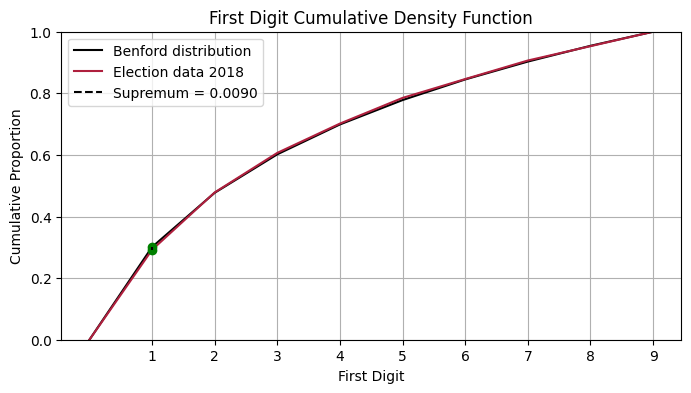

In [733]:
# Calculate cumulative proportions for Benford's law and first position of the election data
benford_digits = list(benford_nth_digit_probabilities(1).keys())
benford_probs = list(benford_nth_digit_probabilities(1).values())
benford_cumulative = [sum(benford_probs[:i+1]) for i in range(len(benford_probs))]

election_digits = list(data_digit_probabilities(veneto['VOTI_LISTA'], 1).keys())
election_probs = list(data_digit_probabilities(veneto['VOTI_LISTA'], 1).values())
election_cumulative = [sum(election_probs[:i+1]) for i in range(len(election_probs))]

# Calculate the supremum (maximum difference) and find the corresponding x value
differences = [abs(b - u) for b, u in zip(benford_cumulative, election_cumulative)]
supremum = max(differences)
supremum_index = differences.index(supremum)
supremum_x = benford_digits[supremum_index]
supremum_y_benford = benford_cumulative[supremum_index]
supremum_y_el = election_cumulative[supremum_index]

# Plot cumulative density functions
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(benford_digits, benford_cumulative, 'black', label='Benford distribution')
ax.plot(election_digits, election_cumulative, color="#af203e", label='Election data 2018')

# Highlight the supremum point
ax.plot([supremum_x], [supremum_y_benford], 'go')  # Point on Benford curve
ax.plot([supremum_x], [supremum_y_el], 'go')  # Point on Election curve
ax.vlines(supremum_x, supremum_y_el, supremum_y_benford, colors='k', linestyle='--', label=f'Supremum = {supremum:.4f}')

ax.set_xticks(range(1, 10))
# Add title, labels, and legend
ax.set_title('First Digit Cumulative Density Function')
ax.set_xlabel('First Digit')
ax.set_ylabel('Cumulative Proportion')
ax.set_ylim(0, 1)  # Ensure the y-axis starts at 0 and ends at 1
ax.legend()
ax.grid(True)
plt.show()


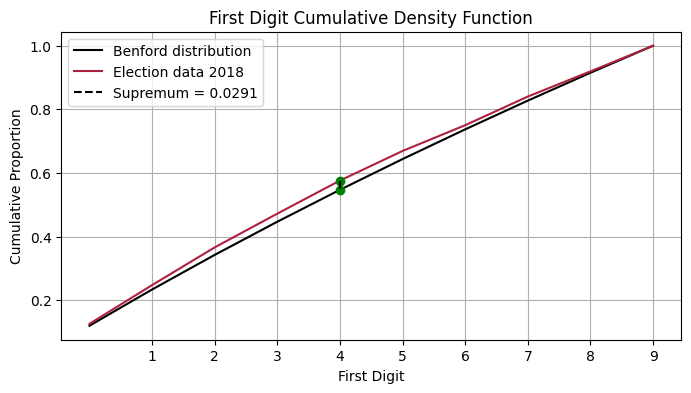

In [734]:
# Calculate cumulative proportions for Benford's law and first position of the election data
benford_digits = list(benford_nth_digit_probabilities(2).keys())
benford_probs = list(benford_nth_digit_probabilities(2).values())
benford_cumulative = [sum(benford_probs[:i+1]) for i in range(len(benford_probs))]

election_digits = list(data_digit_probabilities(veneto['VOTI_LISTA'], 2).keys())
election_probs = list(data_digit_probabilities(veneto['VOTI_LISTA'], 2).values())
election_cumulative = [sum(election_probs[:i+1]) for i in range(len(election_probs))]

# Calculate the supremum (maximum difference) and find the corresponding x value
differences = [abs(b - u) for b, u in zip(benford_cumulative, election_cumulative)]
supremum = max(differences)
supremum_index = differences.index(supremum)
supremum_x = benford_digits[supremum_index]
supremum_y_benford = benford_cumulative[supremum_index]
supremum_y_el = election_cumulative[supremum_index]

# Plot cumulative density functions
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(benford_digits, benford_cumulative, 'black', label='Benford distribution')
ax.plot(election_digits, election_cumulative, color="#af203e", label='Election data 2018')

# Highlight the supremum point
ax.plot([supremum_x], [supremum_y_benford], 'go')  # Point on Benford curve
ax.plot([supremum_x], [supremum_y_el], 'go')  # Point on Election curve
ax.vlines(supremum_x, supremum_y_el, supremum_y_benford, colors='k', linestyle='--', label=f'Supremum = {supremum:.4f}')

ax.set_xticks(range(1, 10))
# Add title, labels, and legend
ax.set_title('First Digit Cumulative Density Function')
ax.set_xlabel('First Digit')
ax.set_ylabel('Cumulative Proportion')
ax.legend()
ax.grid(True)
plt.show()

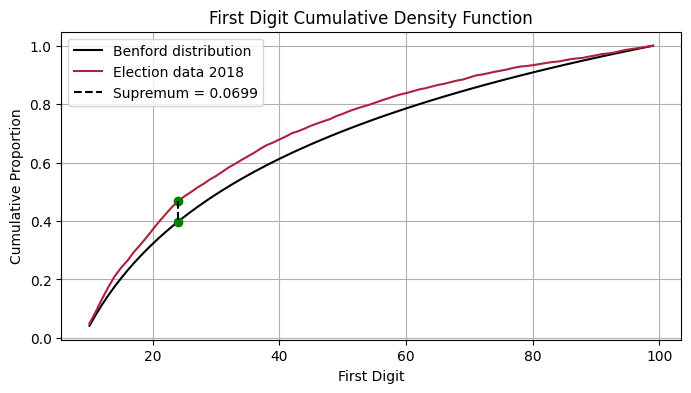

In [735]:
# Calculate cumulative proportions for Benford's law and first position of the election data
benford_digits = list(Benford_theory_firsttwo_digits().keys())
benford_probs = list(Benford_theory_firsttwo_digits().values())
benford_cumulative = [sum(benford_probs[:i+1]) for i in range(len(benford_probs))]

election_digits = list(data_digit_probabilities_firsttwo(veneto['VOTI_LISTA']).keys())
election_probs = list(data_digit_probabilities_firsttwo(veneto['VOTI_LISTA']).values())
election_cumulative = [sum(election_probs[:i+1]) for i in range(len(election_probs))]

# Calculate the supremum (maximum difference) and find the corresponding x value
differences = [abs(b - u) for b, u in zip(benford_cumulative, election_cumulative)]
supremum = max(differences)
supremum_index = differences.index(supremum)
supremum_x = benford_digits[supremum_index]
supremum_y_benford = benford_cumulative[supremum_index]
supremum_y_el = election_cumulative[supremum_index]

# Plot cumulative density functions
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(benford_digits, benford_cumulative, 'black', label='Benford distribution')
ax.plot(election_digits, election_cumulative, color="#af203e", label='Election data 2018')

# Highlight the supremum point
ax.plot([supremum_x], [supremum_y_benford], 'go')  # Point on Benford curve
ax.plot([supremum_x], [supremum_y_el], 'go')  # Point on Election curve
ax.vlines(supremum_x, supremum_y_el, supremum_y_benford, colors='k', linestyle='--', label=f'Supremum = {supremum:.4f}')

# Add title, labels, and legend
ax.set_title('First Digit Cumulative Density Function')
ax.set_xlabel('First Digit')
ax.set_ylabel('Cumulative Proportion')
ax.legend()
ax.grid(True)
plt.show()

### Brexit referendum

In [621]:
#read the csv data of the brexit referendum
file_path = "C:/Users/franc/Desktop/Tesi/Benford/Codice/Dati/EU-referendum-result-data.csv"
brexit_data = pd.read_csv(file_path)
brexit_data
#show me the name of the variables
brexit_data.columns



Index(['id', 'Region_Code', 'Region', 'Area_Code', 'Area', 'Electorate',
       'ExpectedBallots', 'VerifiedBallotPapers', 'Pct_Turnout', 'Votes_Cast',
       'Valid_Votes', 'Remain', 'Leave', 'Rejected_Ballots',
       'No_official_mark', 'Voting_for_both_answers', 'Writing_or_mark',
       'Unmarked_or_void', 'Pct_Remain', 'Pct_Leave', 'Pct_Rejected'],
      dtype='object')

In [622]:
#keep only the columns with area, expectedballots, remain, leave
brexit_data = brexit_data[['Area', 'Remain', 'Leave', 'Valid_Votes']]
brexit_data

,Area,Remain,Leave,Valid_Votes
0,Peterborough,34176,53216,87392
1,Luton,36708,47773,84481
2,Southend-on-Sea,39348,54522,93870
3,Thurrock,22151,57765,79916
4,Bedford,41497,44569,86066
...,...,...,...,...
377,Bradford,104575,123913,228488
378,Calderdale,46950,58975,105925
379,Kirklees,98485,118755,217240
380,Leeds,194863,192474,387337


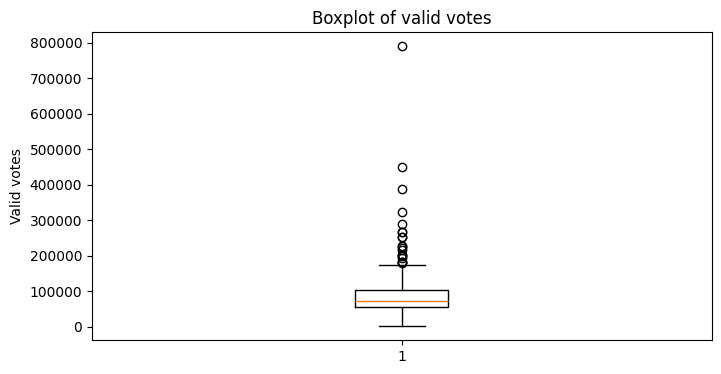

In [623]:
#plot a boxplot of the valid votes
fig, ax = plt.subplots(figsize=(8, 4))
ax.boxplot(brexit_data['Valid_Votes'])
ax.set_title('Boxplot of valid votes')
ax.set_ylabel('Valid votes')
plt.show()



In [624]:
#remove the outliers from the valid votes, that are the values greater than 1.5 times the interquartile range
Q1 = brexit_data['Valid_Votes'].quantile(0.25)
Q3 = brexit_data['Valid_Votes'].quantile(0.75)
IQR = Q3 - Q1
brexit_data_no_outliers = brexit_data[(brexit_data['Valid_Votes'] >= Q1 - 1.5 * IQR) & (brexit_data['Valid_Votes'] <= Q3 + 1.5 * IQR)]
brexit_data_no_outliers


,Area,Remain,Leave,Valid_Votes
0,Peterborough,34176,53216,87392
1,Luton,36708,47773,84481
2,Southend-on-Sea,39348,54522,93870
3,Thurrock,22151,57765,79916
4,Bedford,41497,44569,86066
...,...,...,...,...
373,Barnsley,38951,83958,122909
374,Doncaster,46922,104260,151182
375,Rotherham,44115,93272,137387
378,Calderdale,46950,58975,105925


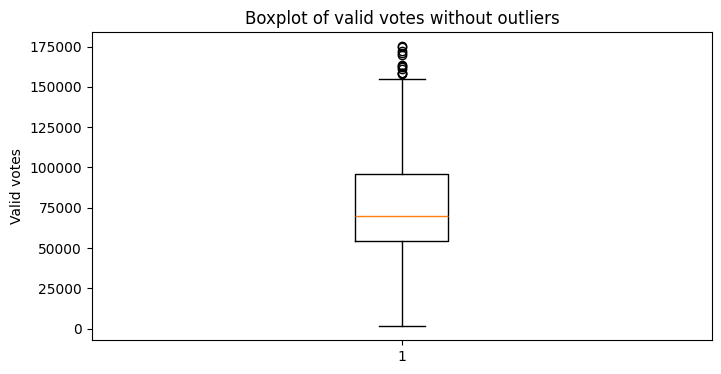

In [625]:
#do another boxplot of the valid votes
fig, ax = plt.subplots(figsize=(8, 4))
ax.boxplot(brexit_data_no_outliers['Valid_Votes'])
ax.set_title('Boxplot of valid votes without outliers')
ax.set_ylabel('Valid votes')
plt.show()


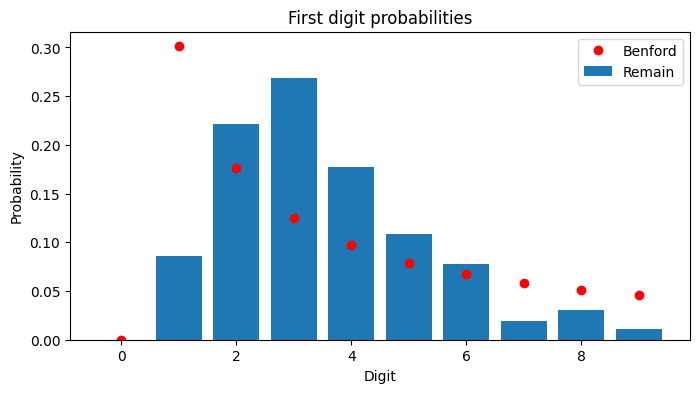

In [626]:
#apply the benford's law to the remain column
remain_benford = data_digit_probabilities(brexit_data_no_outliers['Leave'], 1)
remain_benford

#plot the remain_benford
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(benford_nth_digit_probabilities(1).keys()), list(benford_nth_digit_probabilities(1).values()), 'ro', label='Benford')
ax.bar(remain_benford.keys(), remain_benford.values(), label='Remain')
ax.set_title('First digit probabilities')
ax.set_xlabel('Digit')
ax.set_ylabel('Probability')
ax.legend()
plt.show()


In [627]:
N=len(brexit_data_no_outliers)
N


361

In [628]:
#compute the z-statistic for the remain_benford first digit
BP=list(benford_nth_digit_probabilities(1).values())[1:]
AP=list(data_digit_probabilities(remain_benford,1))[1:]
N=len(brexit_data_no_outliers)
z_value = calculate_z_statistic(AP, BP, N)
print(f"Z-statistic value: {z_value}")


N: 361
Z-Statistics and Hypothesis Tests

Digit 1:
  Actual proportion (DP): 1.0000
  Expected proportion (BP): 0.3010
  Z-statistic: 28.8946
  p-value: 0.0000
  Critical value at alpha=0.1%: 3.2905
  Reject null hypothesis at alpha=0.1%
  Critical value at alpha=1.0%: 2.5758
  Reject null hypothesis at alpha=1.0%
  Critical value at alpha=5.0%: 1.9600
  Reject null hypothesis at alpha=5.0%
Digit 2:
  Actual proportion (DP): 2.0000
  Expected proportion (BP): 0.1761
  Z-statistic: 90.9114
  p-value: 0.0000
  Critical value at alpha=0.1%: 3.2905
  Reject null hypothesis at alpha=0.1%
  Critical value at alpha=1.0%: 2.5758
  Reject null hypothesis at alpha=1.0%
  Critical value at alpha=5.0%: 1.9600
  Reject null hypothesis at alpha=5.0%
Digit 3:
  Actual proportion (DP): 3.0000
  Expected proportion (BP): 0.1249
  Z-statistic: 165.1291
  p-value: 0.0000
  Critical value at alpha=0.1%: 3.2905
  Reject null hypothesis at alpha=0.1%
  Critical value at alpha=1.0%: 2.5758
  Reject null hypo

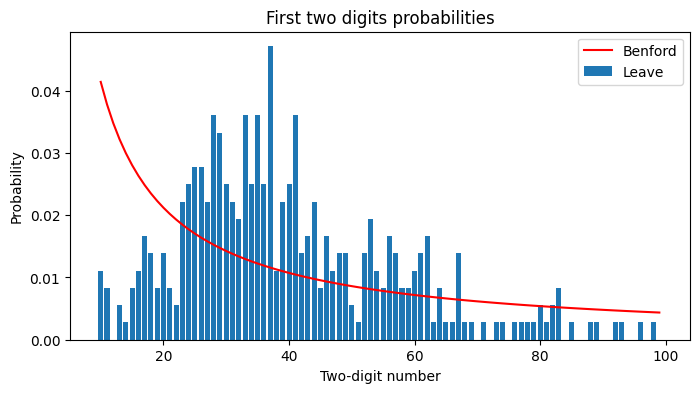

In [629]:
#use brexit_data_no_outliers for the first two digits
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(Benford_theory_firsttwo_digits().keys()), list(Benford_theory_firsttwo_digits().values()), 'r', label='Benford')
ax.bar(data_digit_probabilities_firsttwo(brexit_data_no_outliers['Leave']).keys(), data_digit_probabilities_firsttwo(brexit_data_no_outliers['Leave']).values(), label='Leave')
ax.set_title('First two digits probabilities')
ax.set_xlabel('Two-digit number')
ax.set_ylabel('Probability')
ax.legend()
plt.show()


In [630]:
AP

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [631]:
#chi-squared test


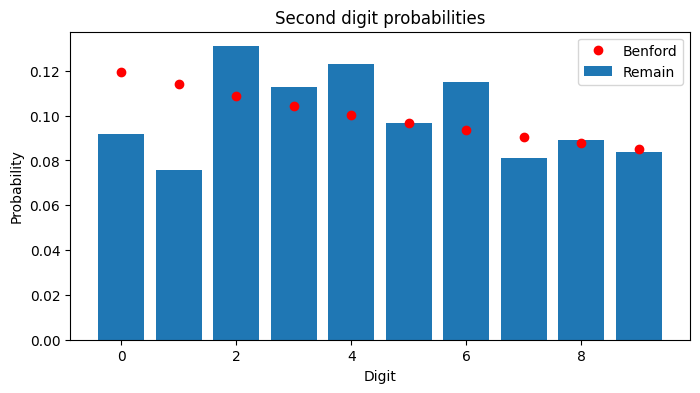

In [632]:
#do the same for the second digit
remain_benford = data_digit_probabilities(brexit_data['Remain'], 2)
remain_benford

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(benford_nth_digit_probabilities(2).keys()), list(benford_nth_digit_probabilities(2).values()), 'ro', label='Benford')
ax.bar(remain_benford.keys(), remain_benford.values(), label='Remain')
ax.set_title('Second digit probabilities')
ax.set_xlabel('Digit')
ax.set_ylabel('Probability')
ax.legend()
plt.show()


### United states presidential election of 2020

#### Data cleaning and preparation

Datased is charged from an Excel file, readinf only the sheet "9. 2020 Pres General Results"

In [633]:
# open the file "C:\Users\franc\Desktop\Tesi\Benford\Codice\Dati\federalelections2020.xlsx" 
file_path = "C:/Users/franc/Desktop/Tesi/Benford/Codice/Dati/federalelections2020.xlsx"
election_data_20 = pd.read_excel(file_path, sheet_name="9. 2020 Pres General Results")
election_data_20


,1,FEC ID,STATE,STATE ABBREVIATION,GENERAL ELECTION DATE,FIRST NAME,LAST NAME,"LAST NAME, FIRST",TOTAL VOTES,PARTY,GENERAL RESULTS,GENERAL %,TOTAL VOTES #,COMBINED GE PARTY TOTALS (NY),COMBINED % (NY),WINNER INDICATOR,ELECTORAL VOTES,FOOTNOTES
0,2,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,P80001571,Alabama,AL,2020-11-03,Donald J.,Trump,"Trump, Donald J.",NaN,R,1441170.0,0.620316,NaN,NaN,NaN,W,9,NaN
2,4,P80000722,Alabama,AL,2020-11-03,Joseph R.,Biden,"Biden, Joseph R.",NaN,D,849624.0,0.365700,NaN,NaN,NaN,NaN,NaN,NaN
3,5,P00013524,Alabama,AL,2020-11-03,Jo,Jorgensen,"Jorgensen, Jo",NaN,IND,25176.0,0.010836,NaN,NaN,NaN,NaN,NaN,NaN
4,6,NaN,Alabama,AL,2020-11-03,NaN,Scattered,Scattered,NaN,W,7312.0,0.003147,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
676,678,P00016550,Wyoming,WY,2020-11-03,Brock,Pierce,"Pierce, Brock",NaN,IND,2208.0,0.007978,NaN,NaN,NaN,NaN,NaN,NaN
677,679,NaN,Wyoming,WY,2020-11-03,NaN,Scattered,Scattered,NaN,W,1739.0,0.006283,NaN,NaN,NaN,NaN,NaN,NaN
678,680,NaN,Wyoming,WY,2020-11-03,NaN,NaN,NaN,Total State Votes:,NaN,NaN,NaN,276765.0,NaN,NaN,NaN,NaN,NaN
679,681,NaN,NaN,NaN,2020-11-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


All the rows without a name are removed.

In [634]:
election_data_20 = election_data_20.dropna(subset=['FIRST NAME'])
election_data_20

,1,FEC ID,STATE,STATE ABBREVIATION,GENERAL ELECTION DATE,FIRST NAME,LAST NAME,"LAST NAME, FIRST",TOTAL VOTES,PARTY,GENERAL RESULTS,GENERAL %,TOTAL VOTES #,COMBINED GE PARTY TOTALS (NY),COMBINED % (NY),WINNER INDICATOR,ELECTORAL VOTES,FOOTNOTES
1,3,P80001571,Alabama,AL,2020-11-03,Donald J.,Trump,"Trump, Donald J.",NaN,R,1441170.0,0.620316,NaN,NaN,NaN,W,9,NaN
2,4,P80000722,Alabama,AL,2020-11-03,Joseph R.,Biden,"Biden, Joseph R.",NaN,D,849624.0,0.365700,NaN,NaN,NaN,NaN,NaN,NaN
3,5,P00013524,Alabama,AL,2020-11-03,Jo,Jorgensen,"Jorgensen, Jo",NaN,IND,25176.0,0.010836,NaN,NaN,NaN,NaN,NaN,NaN
7,9,P80001571,Alaska,AK,2020-11-03,Donald J.,Trump,"Trump, Donald J.",NaN,R,189951.0,0.528331,NaN,NaN,NaN,W,3,NaN
8,10,P80000722,Alaska,AK,2020-11-03,"Joseph R., Jr.",Biden,"Biden, Joseph R., Jr.",NaN,D,153778.0,0.427720,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
670,672,P00007864,Wisconsin,WI,2020-11-03,Kasey,Wells,"Wells, Kasey",NaN,W,25.0,0.000008,NaN,NaN,NaN,NaN,NaN,NaN
673,675,P80001571,Wyoming,WY,2020-11-03,Donald J.,Trump,"Trump, Donald J.",NaN,R,193559.0,0.699362,NaN,NaN,NaN,W,3,NaN
674,676,P80000722,Wyoming,WY,2020-11-03,Joseph R.,Biden,"Biden, Joseph R.",NaN,D,73491.0,0.265536,NaN,NaN,NaN,NaN,NaN,NaN
675,677,P00013524,Wyoming,WY,2020-11-03,Jo,Jorgensen,"Jorgensen, Jo",NaN,LIB,5768.0,0.020841,NaN,NaN,NaN,NaN,NaN,NaN


Only interesting rows are kept.

In [635]:
election_data_20 = election_data_20[['STATE', 'FIRST NAME', 'LAST NAME', 'PARTY', 'GENERAL RESULTS']]
election_data_20


,STATE,FIRST NAME,LAST NAME,PARTY,GENERAL RESULTS
1,Alabama,Donald J.,Trump,R,1441170.0
2,Alabama,Joseph R.,Biden,D,849624.0
3,Alabama,Jo,Jorgensen,IND,25176.0
7,Alaska,Donald J.,Trump,R,189951.0
8,Alaska,"Joseph R., Jr.",Biden,D,153778.0
...,...,...,...,...,...
670,Wisconsin,Kasey,Wells,W,25.0
673,Wyoming,Donald J.,Trump,R,193559.0
674,Wyoming,Joseph R.,Biden,D,73491.0
675,Wyoming,Jo,Jorgensen,LIB,5768.0


We removed from the subset the rows where we the number of votes is NaM. This rows corresponds to the state of New York. In this state Conservative Party of New York State cross-endorsed the Republican ticket, nominating Donald Trump for president and Mike Pence for vice president and the Working Families Party cross-endorsed the Democratic ticket, nominating Joe Biden for president and Kamala Harris for vice president. So, in this state, Joe Biden and Donald Trump havve two parties that support them but the votes are counted as a candidate.

#we romove the row where the sum of combined parties is calculated so we have, in New York state, two Joe Biden and two Donald Trump.


In [636]:
election_data_20 = election_data_20.dropna(subset=['GENERAL RESULTS'])
#convert the 'GENERAL RESULTS' column to integer
election_data_20['GENERAL RESULTS'] = election_data_20['GENERAL RESULTS'].astype(int)
election_data_20

C:\Users\franc\AppData\Local\Temp\ipykernel_9944\1586286084.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  election_data_20['GENERAL RESULTS'] = election_data_20['GENERAL RESULTS'].astype(int)


,STATE,FIRST NAME,LAST NAME,PARTY,GENERAL RESULTS
1,Alabama,Donald J.,Trump,R,1441170
2,Alabama,Joseph R.,Biden,D,849624
3,Alabama,Jo,Jorgensen,IND,25176
7,Alaska,Donald J.,Trump,R,189951
8,Alaska,"Joseph R., Jr.",Biden,D,153778
...,...,...,...,...,...
670,Wisconsin,Kasey,Wells,W,25
673,Wyoming,Donald J.,Trump,R,193559
674,Wyoming,Joseph R.,Biden,D,73491
675,Wyoming,Jo,Jorgensen,LIB,5768


In [637]:
#compute the mean and the median of the 'GENERAL RESULTS' column
mean = election_data_20['GENERAL RESULTS'].mean()
median = election_data_20['GENERAL RESULTS'].median()
mean, median

(286145.38336347195, 1035.0)

#### First digit analysis

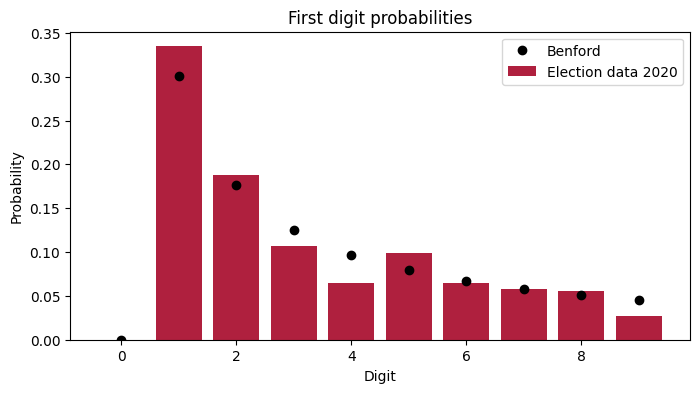

In [638]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(benford_nth_digit_probabilities(1).keys()), list(benford_nth_digit_probabilities(1).values()), 'ko', label='Benford')
ax.bar(data_digit_probabilities(election_data_20['GENERAL RESULTS'], 1).keys(), data_digit_probabilities(election_data_20['GENERAL RESULTS'], 1).values(), label='Election data 2020', color='#af203e')
ax.set_title('First digit probabilities')
ax.set_xlabel('Digit')
ax.set_ylabel('Probability')
ax.legend()
plt.show()


###### z-statistic

In [639]:
BP=list(benford_nth_digit_probabilities(1).values())[1:]
AP=list(data_digit_probabilities(election_data_20['GENERAL RESULTS'], 1).values())[1:]
N=len(election_data_20)

z_value = calculate_z_statistic(AP, BP, N)
print(f"Z-statistic value: {z_value}")


N: 553
Z-Statistics and Hypothesis Tests

Digit 1:
  Actual proportion (DP): 0.3345
  Expected proportion (BP): 0.3010
  Z-statistic: 1.6715
  p-value: 0.0946
  Critical value at alpha=0.1%: 3.2905
  Fail to reject null hypothesis at alpha=0.1%
  Critical value at alpha=1.0%: 2.5758
  Fail to reject null hypothesis at alpha=1.0%
  Critical value at alpha=5.0%: 1.9600
  Fail to reject null hypothesis at alpha=5.0%
Digit 2:
  Actual proportion (DP): 0.1881
  Expected proportion (BP): 0.1761
  Z-statistic: 0.6834
  p-value: 0.4943
  Critical value at alpha=0.1%: 3.2905
  Fail to reject null hypothesis at alpha=0.1%
  Critical value at alpha=1.0%: 2.5758
  Fail to reject null hypothesis at alpha=1.0%
  Critical value at alpha=5.0%: 1.9600
  Fail to reject null hypothesis at alpha=5.0%
Digit 3:
  Actual proportion (DP): 0.1067
  Expected proportion (BP): 0.1249
  Z-statistic: 1.2335
  p-value: 0.2174
  Critical value at alpha=0.1%: 3.2905
  Fail to reject null hypothesis at alpha=0.1%
  Cri

In [640]:
z_value.values()

dict_values([1.6715098452612058, 0.6834224287801542, 1.2334996634790962, 2.456750744148787, 1.687100714322389, 0.08874335411839705, 0.012653267107651111, 0.42709002058589696, 1.9951496943994196])

In [641]:
# create a table with digits from 1 to 9 as index, the Benford probabilities, the election data 2020 probabilities, the difference between the two and the z-statistic value
Benford_theory = pd.DataFrame(benford_nth_digit_probabilities(1).items(), columns=['First digit', 'Benford probabilities'])
Benford_theory['Election data 2020 probabilities'] = data_digit_probabilities(election_data_20['GENERAL RESULTS'], 1).values()
Benford_theory=Benford_theory[1:]
Benford_theory['Difference'] = Benford_theory['Election data 2020 probabilities'] - Benford_theory['Benford probabilities']
Benford_theory['Z-statistic'] = z_value.values()
Benford_theory


,First digit,Benford probabilities,Election data 2020 probabilities,Difference,Z-statistic
1,1,0.301030,0.334539,0.033509,1.671510
2,2,0.176091,0.188065,0.011974,0.683422
3,3,0.124939,0.106691,-0.018248,1.233500
4,4,0.096910,0.065099,-0.031811,2.456751
5,5,0.079181,0.099458,0.020276,1.687101
6,6,0.066947,0.065099,-0.001847,0.088743
7,7,0.057992,0.057866,-0.000126,0.012653
8,8,0.051153,0.056058,0.004905,0.427090
9,9,0.045757,0.027125,-0.018633,1.995150


##### MAD

In [642]:
BP=list(benford_nth_digit_probabilities(1).values())[1:]
AP=list(data_digit_probabilities(election_data_20['GENERAL RESULTS'], 1).values())[1:]
K=len(BP) 
mad = calculate_mad(AP, BP, K)
print(f"Mean Absolute Deviation (MAD) from Benford's Law: {mad}")


Number of digits (K): 9
Mean Absolute Deviation (MAD) from Benford's Law: 0.01570318350905698


##### Chi-squared test

In [643]:
BP=list(benford_nth_digit_probabilities(1).values())[1:]
AP=list(data_digit_probabilities(election_data_20['GENERAL RESULTS'], 1).values())[1:]
N=len(election_data_20)
calculate_chi_square(AP, BP, N)


N: 553
Chi-Square statistic: 17.1167
Critical value (alpha=0.1%): 26.1245
Chi-Square statistic > Critical value: Fail to reject the null hypothesis
Critical value (alpha=1.0%): 20.0902
Chi-Square statistic > Critical value: Fail to reject the null hypothesis
Critical value (alpha=5.0%): 15.5073
Chi-Square statistic > Critical value: Reject the null hypothesis


{0.001: {'chi_square': 17.116681440994665,
  'critical_value': 26.12448155837614,
  'p_value': 0.028916760247990503,
  'decision': 'Fail to reject the null hypothesis'},
 0.01: {'chi_square': 17.116681440994665,
  'critical_value': 20.090235029663233,
  'p_value': 0.028916760247990503,
  'decision': 'Fail to reject the null hypothesis'},
 0.05: {'chi_square': 17.116681440994665,
  'critical_value': 15.507313055865453,
  'p_value': 0.028916760247990503,
  'decision': 'Reject the null hypothesis'}}

##### FSD mean

In [644]:
print("Benford's Law FSD Mean:", calculate_fsd_mean(list(benford_nth_digit_probabilities(1).values())[1:], start_digit=1, num_digits=9), 
      " | Uniform FSD Mean:", calculate_fsd_mean(uniform_first_digit, start_digit=1, num_digits=9),
        " | Election data 2020 FSD Mean:", calculate_fsd_mean(list(data_digit_probabilities(election_data_20['GENERAL RESULTS'], 1).values())[1:], start_digit=1, num_digits=9))

Benford's Law FSD Mean: 3.440236967123206  | Uniform FSD Mean: 5.0  | Election data 2020 FSD Mean: 3.2766726943942137


##### Kolmogorov-Smirnov test

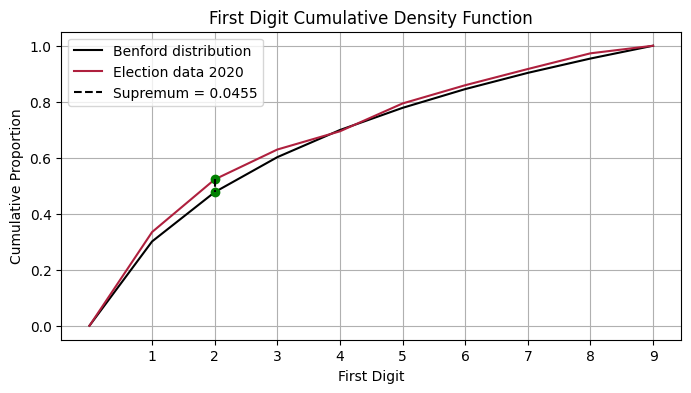

In [663]:
benford_digits = list(benford_nth_digit_probabilities(1).keys())
benford_probs = list(benford_nth_digit_probabilities(1).values())
benford_cumulative = [sum(benford_probs[:i+1]) for i in range(len(benford_probs))]

election_digits = list(data_digit_probabilities(election_data_20['GENERAL RESULTS'], 1).keys())
election_probs = list(data_digit_probabilities(election_data_20['GENERAL RESULTS'], 1).values())
election_cumulative = [sum(election_probs[:i+1]) for i in range(len(election_probs))]

differences = [abs(b - u) for b, u in zip(benford_cumulative, election_cumulative)]
supremum = max(differences)
supremum_index = differences.index(supremum)
supremum_x = benford_digits[supremum_index]
supremum_y_benford = benford_cumulative[supremum_index]
supremum_y_el = election_cumulative[supremum_index]

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(benford_digits, benford_cumulative, 'black', label='Benford distribution')
ax.plot(election_digits, election_cumulative, color="#af203e", label='Election data 2020')

ax.plot([supremum_x], [supremum_y_benford], 'go')  # Point on Benford curve
ax.plot([supremum_x], [supremum_y_el], 'go')  # Point on Election curve
ax.vlines(supremum_x, supremum_y_el, supremum_y_benford, colors='k', linestyle='--', label=f'Supremum = {supremum:.4f}')

ax.set_xticks(range(1, 10))
ax.set_title('First Digit Cumulative Density Function')
ax.set_xlabel('First Digit')
ax.set_ylabel('Cumulative Proportion')
ax.legend()
ax.grid(True)
plt.show()



In [646]:
#calculate the ks statistic for the first position of the election data 2020
N=len(election_data_20)
calculate_ks_statistic(list(data_digit_probabilities(election_data_20['GENERAL RESULTS'], 1).values()), list(benford_nth_digit_probabilities(1).values()),N)


KS statistic: 0.0455
Alpha=0.001: Fail to reject null hypothesis (KS=0.0455 <= Critical=0.0829)
Alpha=0.010: Fail to reject null hypothesis (KS=0.0455 <= Critical=0.0693)
Alpha=0.050: Fail to reject null hypothesis (KS=0.0455 <= Critical=0.0578)


(0.04548272358051836,
 {0.001: 'Fail to reject null hypothesis (KS=0.0455 <= Critical=0.0829)',
  0.01: 'Fail to reject null hypothesis (KS=0.0455 <= Critical=0.0693)',
  0.05: 'Fail to reject null hypothesis (KS=0.0455 <= Critical=0.0578)'})

#### Second digit analysis

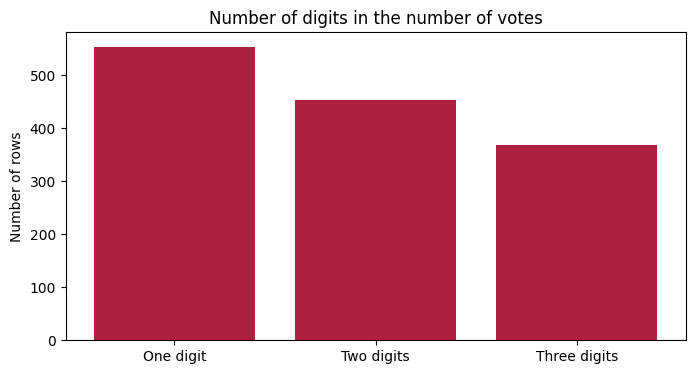

,digit,value,percentage,difference
0,One digit,553,1.000000,0
1,Two digits,453,0.819168,-100
2,Three digits,368,0.665461,-85


In [647]:
onep=election_data_20['GENERAL RESULTS'].shape[0]
twop=election_data_20[election_data_20['GENERAL RESULTS'] >= 10].shape[0]
threep=election_data_20[election_data_20['GENERAL RESULTS'] >= 100].shape[0]

#plot in bar chart onep, twop, threep
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(['One digit', 'Two digits', 'Three digits'], [onep, twop, threep], color='#af203e')
ax.set_title('Number of digits in the number of votes')
ax.set_ylabel('Number of rows')
plt.show()

#visualize the number of onep, twop, threep
onep, twop, threep

#write the difference between the number of onep, twop, threep in a table with the value and the percentage and the values of onep, twop, threep
#I want a table with 4 columns: digit, value, percentage, difference
data = {'digit': ['One digit', 'Two digits', 'Three digits'],
        'value': [onep, twop, threep],
        'percentage': [onep/onep, twop/onep, threep/onep],
        'difference': [0, twop-onep, threep-twop]}

digits = pd.DataFrame(data)
digits

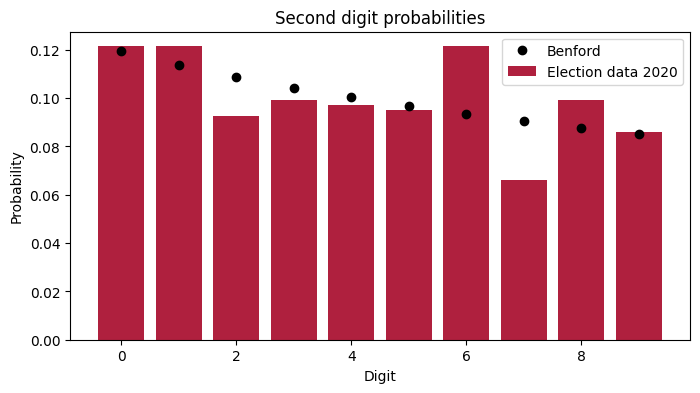

In [648]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(benford_nth_digit_probabilities(2).keys()), list(benford_nth_digit_probabilities(2).values()), 'ko', label='Benford')
ax.bar(data_digit_probabilities(election_data_20['GENERAL RESULTS'], 2).keys(), data_digit_probabilities(election_data_20['GENERAL RESULTS'], 2).values(), label='Election data 2020', color='#af203e')
ax.set_title('Second digit probabilities')
ax.set_xlabel('Digit')
ax.set_ylabel('Probability')
ax.legend()
plt.show()

##### Z-Statistic

In [649]:
BP=list(benford_nth_digit_probabilities(2).values())
print(BP)
AP=list(data_digit_probabilities(election_data_20['GENERAL RESULTS'], 2).values())
print(AP)
N=twop
print(N)
z_value = calculate_z_statistic(AP, BP, N)
print(f"Z-statistic value: {z_value}")

[0.11967926859688076, 0.1138901034075564, 0.10882149900550823, 0.10432956023095939, 0.10030820226757937, 0.09667723580232243, 0.09337473578303615, 0.09035198926960332, 0.08757005357886138, 0.08499735205769224]
[0.12141280353200883, 0.12141280353200883, 0.09271523178807947, 0.09933774834437085, 0.09713024282560706, 0.09492273730684327, 0.12141280353200883, 0.06622516556291391, 0.09933774834437085, 0.08609271523178808]
453
N: 453
Z-Statistics and Hypothesis Tests

Digit 1:
  Actual proportion (DP): 0.1214
  Expected proportion (BP): 0.1197
  Z-statistic: 0.0413
  p-value: 0.9671
  Critical value at alpha=0.1%: 3.2905
  Fail to reject null hypothesis at alpha=0.1%
  Critical value at alpha=1.0%: 2.5758
  Fail to reject null hypothesis at alpha=1.0%
  Critical value at alpha=5.0%: 1.9600
  Fail to reject null hypothesis at alpha=5.0%
Digit 2:
  Actual proportion (DP): 0.1214
  Expected proportion (BP): 0.1139
  Z-statistic: 0.4301
  p-value: 0.6672
  Critical value at alpha=0.1%: 3.2905
  

##### MAD

In [650]:
BP=list(benford_nth_digit_probabilities(2).values())
AP=list(data_digit_probabilities(election_data_20['GENERAL RESULTS'], 2).values())
K=len(BP)   #number of digits
mad = calculate_mad(AP, BP, K)
print(f"Mean Absolute Deviation (MAD) from Benford's Law: {mad}")

Number of digits (K): 10
Mean Absolute Deviation (MAD) from Benford's Law: 0.010031472149631666


##### Chi-squared test

In [653]:
BP=list(benford_nth_digit_probabilities(2).values())
AP=list(data_digit_probabilities(election_data_20['GENERAL RESULTS'], 2).values())
N=twop
calculate_chi_square(AP, BP, N)

N: 453
Chi-Square statistic: 8.9397
Critical value (alpha=0.1%): 27.8772
Chi-Square statistic > Critical value: Fail to reject the null hypothesis
Critical value (alpha=1.0%): 21.6660
Chi-Square statistic > Critical value: Fail to reject the null hypothesis
Critical value (alpha=5.0%): 16.9190
Chi-Square statistic > Critical value: Fail to reject the null hypothesis


{0.001: {'chi_square': 8.939683878119007,
  'critical_value': 27.877164871256568,
  'p_value': 0.442860465619239,
  'decision': 'Fail to reject the null hypothesis'},
 0.01: {'chi_square': 8.939683878119007,
  'critical_value': 21.665994333461924,
  'p_value': 0.442860465619239,
  'decision': 'Fail to reject the null hypothesis'},
 0.05: {'chi_square': 8.939683878119007,
  'critical_value': 16.918977604620448,
  'p_value': 0.442860465619239,
  'decision': 'Fail to reject the null hypothesis'}}

##### SSD mean

In [654]:
print("Benford's Law FSD Mean:", calculate_fsd_mean(list(benford_nth_digit_probabilities(2).values()), start_digit=0, num_digits=10), 
    " | Uniform FSD Mean:", calculate_fsd_mean(uniform_other_digits, start_digit=0, num_digits=10),
    " | Election data 2020 FSD Mean:", calculate_fsd_mean(list(data_digit_probabilities(election_data_20['GENERAL RESULTS'], 2).values()), start_digit=0, num_digits=10))

Benford's Law FSD Mean: 4.1873897069289425  | Uniform FSD Mean: 4.500000000000001  | Election data 2020 FSD Mean: 4.229580573951435


##### Kolmogorov-Smirnov test

{0: 0.12141280353200883,
 1: 0.12141280353200883,
 2: 0.09271523178807947,
 3: 0.09933774834437085,
 4: 0.09713024282560706,
 5: 0.09492273730684327,
 6: 0.12141280353200883,
 7: 0.06622516556291391,
 8: 0.09933774834437085,
 9: 0.08609271523178808}

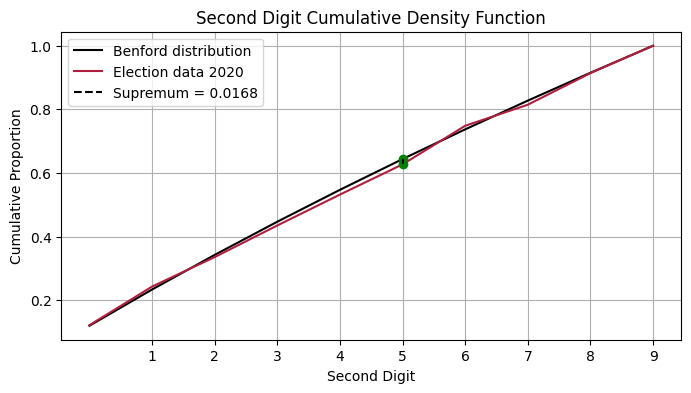

In [662]:
benford_digits = list(benford_nth_digit_probabilities(2).keys())
benford_probs = list(benford_nth_digit_probabilities(2).values())
benford_cumulative = [sum(benford_probs[:i+1]) for i in range(len(benford_probs))]

election_digits = list(data_digit_probabilities(election_data_20['GENERAL RESULTS'], 2).keys())
election_probs = list(data_digit_probabilities(election_data_20['GENERAL RESULTS'], 2).values())
election_cumulative = [sum(election_probs[:i+1]) for i in range(len(election_probs))]

# Calculate the supremum (maximum difference) and find the corresponding x value
differences = [abs(b - u) for b, u in zip(benford_cumulative, election_cumulative)]
supremum = max(differences)
supremum_index = differences.index(supremum)
supremum_x = benford_digits[supremum_index]
supremum_y_benford = benford_cumulative[supremum_index]
supremum_y_el = election_cumulative[supremum_index]

# Plot cumulative density functions
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(benford_digits, benford_cumulative, 'black', label='Benford distribution')
ax.plot(election_digits, election_cumulative, color="#af203e", label='Election data 2020')

# Highlight the supremum point
ax.plot([supremum_x], [supremum_y_benford], 'go')  # Point on Benford curve
ax.plot([supremum_x], [supremum_y_el], 'go')  # Point on Election curve
ax.vlines(supremum_x, supremum_y_el, supremum_y_benford, colors='k', linestyle='--', label=f'Supremum = {supremum:.4f}')

ax.set_xticks(range(1, 10))
ax.set_title('Second Digit Cumulative Density Function')
ax.set_xlabel('Second Digit')
ax.set_ylabel('Cumulative Proportion')
ax.legend()
ax.grid(True)
plt.show()

In [664]:
N=twop
calculate_ks_statistic(list(data_digit_probabilities(election_data_20['GENERAL RESULTS'], 2).values()), list(benford_nth_digit_probabilities(2).values()),N)

KS statistic: 0.0168
Alpha=0.001: Fail to reject null hypothesis (KS=0.0168 <= Critical=0.0916)
Alpha=0.010: Fail to reject null hypothesis (KS=0.0168 <= Critical=0.0766)
Alpha=0.050: Fail to reject null hypothesis (KS=0.0168 <= Critical=0.0639)


(0.01677430198188823,
 {0.001: 'Fail to reject null hypothesis (KS=0.0168 <= Critical=0.0916)',
  0.01: 'Fail to reject null hypothesis (KS=0.0168 <= Critical=0.0766)',
  0.05: 'Fail to reject null hypothesis (KS=0.0168 <= Critical=0.0639)'})

#### First-two digits

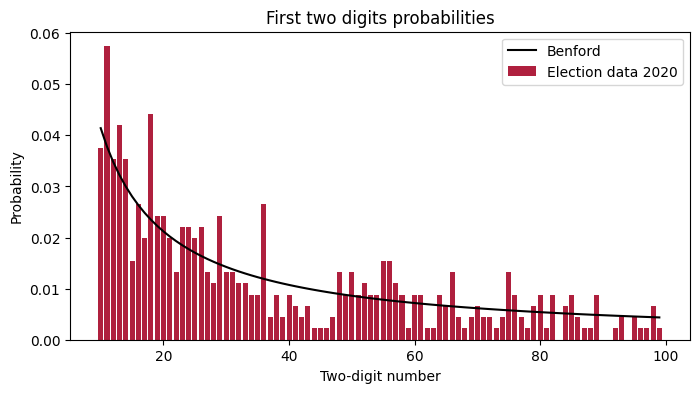

In [673]:
#compute the first-two digit of the 'GENERAL RESULTS' column and plot it in a graph, with a line black for Benford's Law and a bar chart for the election data
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(Benford_theory_firsttwo_digits().keys()), list(Benford_theory_firsttwo_digits().values()), 'k', label='Benford')
ax.bar(data_digit_probabilities_firsttwo(election_data_20['GENERAL RESULTS']).keys(), data_digit_probabilities_firsttwo(election_data_20['GENERAL RESULTS']).values(), label='Election data 2020', color='#af203e')
ax.set_title('First two digits probabilities')
ax.set_xlabel('Two-digit number')
ax.set_ylabel('Probability')
ax.legend()
plt.show()


##### Z-Statistic

In [666]:
BP=list(Benford_theory_firsttwo_digits().values())
AP=list(data_digit_probabilities_firsttwo(election_data_20['GENERAL RESULTS']).values())
N=twop
z_values = calculate_z_statistic(AP, BP, N)
print(f"Z-statistic value: {z_values}")


N: 453
Z-Statistics and Hypothesis Tests

Digit 1:
  Actual proportion (DP): 0.0375
  Expected proportion (BP): 0.0414
  Z-statistic: 0.2950
  p-value: 0.7680
  Critical value at alpha=0.1%: 3.2905
  Fail to reject null hypothesis at alpha=0.1%
  Critical value at alpha=1.0%: 2.5758
  Fail to reject null hypothesis at alpha=1.0%
  Critical value at alpha=5.0%: 1.9600
  Fail to reject null hypothesis at alpha=5.0%
Digit 2:
  Actual proportion (DP): 0.0574
  Expected proportion (BP): 0.0378
  Z-statistic: 2.0652
  p-value: 0.0389
  Critical value at alpha=0.1%: 3.2905
  Fail to reject null hypothesis at alpha=0.1%
  Critical value at alpha=1.0%: 2.5758
  Fail to reject null hypothesis at alpha=1.0%
  Critical value at alpha=5.0%: 1.9600
  Reject null hypothesis at alpha=5.0%
Digit 3:
  Actual proportion (DP): 0.0353
  Expected proportion (BP): 0.0348
  Z-statistic: 0.0648
  p-value: 0.9483
  Critical value at alpha=0.1%: 3.2905
  Fail to reject null hypothesis at alpha=0.1%
  Critical va

##### MAD

In [669]:
BP=list(Benford_theory_firsttwo_digits().values())
AP=list(data_digit_probabilities_firsttwo(election_data_20['GENERAL RESULTS']).values())
K=len(BP)   #number of digits
mad = calculate_mad(AP, BP, K)
print(f"Mean Absolute Deviation (MAD) from Benford's Law: {mad}")


Number of digits (K): 90
Mean Absolute Deviation (MAD) from Benford's Law: 0.003972184101429304


##### Chi-squared test

In [671]:
BP=list(Benford_theory_firsttwo_digits().values())
AP=list(data_digit_probabilities_firsttwo(election_data_20['GENERAL RESULTS']).values())
N=twop
calculate_chi_square(AP, BP, N)


N: 453
Chi-Square statistic: 96.3510
Critical value (alpha=0.1%): 135.9776
Chi-Square statistic > Critical value: Fail to reject the null hypothesis
Critical value (alpha=1.0%): 122.9422
Chi-Square statistic > Critical value: Fail to reject the null hypothesis
Critical value (alpha=5.0%): 112.0220
Chi-Square statistic > Critical value: Fail to reject the null hypothesis


{0.001: {'chi_square': 96.35104729460281,
  'critical_value': 135.97756707124026,
  'p_value': 0.27888168434297755,
  'decision': 'Fail to reject the null hypothesis'},
 0.01: {'chi_square': 96.35104729460281,
  'critical_value': 122.9422067982886,
  'p_value': 0.27888168434297755,
  'decision': 'Fail to reject the null hypothesis'},
 0.05: {'chi_square': 96.35104729460281,
  'critical_value': 112.02198574980785,
  'p_value': 0.27888168434297755,
  'decision': 'Fail to reject the null hypothesis'}}

##### FTSD mean

In [672]:
print("Benford's Law FSD Mean:", calculate_fsd_mean(list(Benford_theory_firsttwo_digits().values()), start_digit=10, num_digits=90),
       " | Uniform FSD Mean:", calculate_fsd_mean(uniform_10_99, start_digit=10, num_digits=90), 
         " | Election data 2020 FSD Mean:", calculate_fsd_mean(list(data_digit_probabilities_firsttwo(election_data_20['GENERAL RESULTS']).values()), start_digit=10, num_digits=90))

Benford's Law FSD Mean: 38.589759378161006  | Uniform FSD Mean: 54.5  | Election data 2020 FSD Mean: 36.4812362030905


##### Kolmogorov-Smirnov test

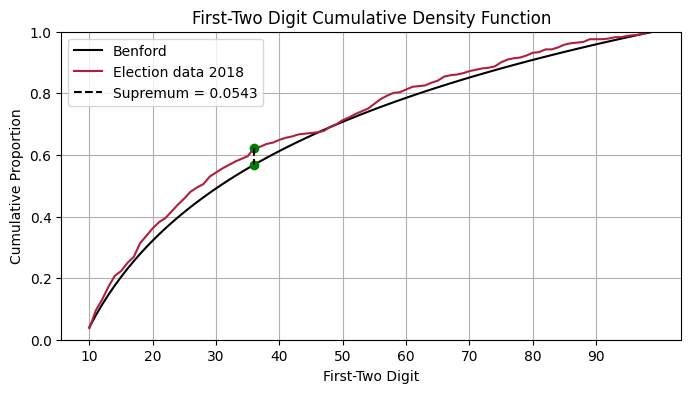

(36, 0.05431483222439604)

In [652]:
# Calculate cumulative proportions for Benford's law and first-two position of the election data
benford_digits = list(Benford_theory_firsttwo_digits().keys())
benford_probs = list(Benford_theory_firsttwo_digits().values())
benford_cumulative = [sum(benford_probs[:i+1]) for i in range(len(benford_probs))]

election_digits = list(data_digit_probabilities_firsttwo(election_data_20['GENERAL RESULTS']).keys())
election_probs = list(data_digit_probabilities_firsttwo(election_data_20['GENERAL RESULTS']).values())
election_cumulative = [sum(election_probs[:i+1]) for i in range(len(election_probs))]

# Calculate the supremum (maximum difference) and find the corresponding x value
differences = [abs(b - u) for b, u in zip(benford_cumulative, election_cumulative)]
supremum = max(differences)
supremum_index = differences.index(supremum)
supremum_x = benford_digits[supremum_index]
supremum_y_benford = benford_cumulative[supremum_index]
supremum_y_el = election_cumulative[supremum_index]

# Plot cumulative density functions
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(benford_digits, benford_cumulative, 'black', label='Benford')
ax.plot(election_digits, election_cumulative, color='#af203e', label='Election data 2018')

# Highlight the supremum point
ax.plot([supremum_x], [supremum_y_benford], 'go')  # Point on Benford curve
ax.plot([supremum_x], [supremum_y_el], 'go')  # Point on Uniform curve
ax.vlines(supremum_x, supremum_y_el, supremum_y_benford, colors='k', linestyle='--', label=f'Supremum = {supremum:.4f}')

# Add title, labels, and legend
ax.set_title('First-Two Digit Cumulative Density Function')
ax.set_xlabel('First-Two Digit')
ax.set_ylabel('Cumulative Proportion')
ax.set_ylim(0, 1)  # Ensure the y-axis starts at 0 and ends at 1
ax.legend()
ax.grid(True)
ax.set_xticks(range(10, 100,10))
plt.show()

#write the correspondent first two digits of the supremum
supremum_x, supremum

In [674]:
N=twop
calculate_ks_statistic(list(data_digit_probabilities_firsttwo(election_data_20['GENERAL RESULTS']).values()), list(Benford_theory_firsttwo_digits().values()),N)


KS statistic: 0.0543
Alpha=0.001: Fail to reject null hypothesis (KS=0.0543 <= Critical=0.0916)
Alpha=0.010: Fail to reject null hypothesis (KS=0.0543 <= Critical=0.0766)
Alpha=0.050: Fail to reject null hypothesis (KS=0.0543 <= Critical=0.0639)


(0.05431483222439604,
 {0.001: 'Fail to reject null hypothesis (KS=0.0543 <= Critical=0.0916)',
  0.01: 'Fail to reject null hypothesis (KS=0.0543 <= Critical=0.0766)',
  0.05: 'Fail to reject null hypothesis (KS=0.0543 <= Critical=0.0639)'})